In [ ]:
from google.colab import drive

ROOT = "/content/drive"    
print(ROOT)               

drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.0 MB/s 


# Load Data and Split Datasets

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import sklearn
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set()

In [ ]:
def load_nacc_data(path, file_name):
  data_path = os.path.join(path, file_name)
  return pd.read_csv(data_path, compression = 'gzip')

In [ ]:
PATH_TO_DATA = 'NACC_Prediction/imputed_data_v2/'

#separate datasets by year (2019 vs. 2021) and survival prediction timespan (OYS, TYS, FYS, TenYS)
OYS_2019_data = load_nacc_data(PATH_TO_DATA, 'OYS/NACC_2019_OYS_data_imputed.csv.gz')
OYS_2021_data = load_nacc_data(PATH_TO_DATA, 'OYS/NACC_2021_OYS_data_imputed.csv.gz')
TYS_2019_data = load_nacc_data(PATH_TO_DATA, 'TYS/NACC_2019_TYS_data_imputed.csv.gz')
TYS_2021_data = load_nacc_data(PATH_TO_DATA, 'TYS/NACC_2021_TYS_data_imputed.csv.gz')
FYS_2019_data = load_nacc_data(PATH_TO_DATA, 'FYS/NACC_2019_FYS_data_imputed.csv.gz')
FYS_2021_data = load_nacc_data(PATH_TO_DATA, 'FYS/NACC_2021_FYS_data_imputed.csv.gz')
TenYS_2019_data = load_nacc_data(PATH_TO_DATA, 'TenYS/NACC_2019_TenYS_data_imputed.csv.gz')
TenYS_2021_data = load_nacc_data(PATH_TO_DATA, 'TenYS/NACC_2021_TenYS_data_imputed.csv.gz') 

In [ ]:
def remove_cols(data, columns_to_remove):
  return data[data.columns.difference(columns_to_remove)]

In [ ]:
COLUMNS_TO_REMOVE = ['NACCID','NACCAUTP','NACCDSYR','NACCACTV',
                    'NACCDSMO','NACCDSDY','NACCNOVS', 'NACCDAYS', 'NACCFDYS',
                     'NACCAVST', 'NACCVNUM', 'NACCNVST', 'NACCMDSS', 
                     'VISITYR', 'VISITMO', 'VISITDAY', 'BIRTHYR', 'BIRTHMO', 'NACCIDEM', 'NACCAGEB',
                     'NACCNORM', 'NACCMCII', 'NACCYOD', 'NACCMOD', 'NACCDIED', 'NACCMRSA'] #and NACCETPR

EXTRA_COLUMNS_TO_REMOVE = ['NEOP', 'NEOPIF', 'NEOPSTAT', 'HIV', 'HIVIF', 'DIABET',
                    'CANCER', 'CANCSITE']

OYS_2019_data = remove_cols(OYS_2019_data, COLUMNS_TO_REMOVE)
OYS_2021_data = remove_cols(OYS_2021_data, COLUMNS_TO_REMOVE)
TYS_2019_data = remove_cols(TYS_2019_data, COLUMNS_TO_REMOVE)
TYS_2021_data = remove_cols(TYS_2021_data, COLUMNS_TO_REMOVE)
FYS_2019_data = remove_cols(FYS_2019_data, COLUMNS_TO_REMOVE)
FYS_2021_data = remove_cols(FYS_2021_data, COLUMNS_TO_REMOVE)
TenYS_2019_data = remove_cols(TenYS_2019_data, COLUMNS_TO_REMOVE)
TenYS_2021_data = remove_cols(TenYS_2021_data, COLUMNS_TO_REMOVE)

In [ ]:
#create datasets containing only dementia patients
OYS_2019_data_dementia = OYS_2019_data.copy()[OYS_2019_data['NACCETPR'] != 88]
TYS_2019_data_dementia = TYS_2019_data.copy()[TYS_2019_data['NACCETPR'] != 88]
FYS_2019_data_dementia = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] != 88]
TenYS_2019_data_dementia = TenYS_2019_data.copy()[TenYS_2019_data['NACCETPR'] != 88]

#same for validation datasets
OYS_2021_data_dementia = OYS_2021_data.copy()[OYS_2021_data['NACCETPR'] != 88]
TYS_2021_data_dementia = TYS_2021_data.copy()[TYS_2021_data['NACCETPR'] != 88]
FYS_2021_data_dementia = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] != 88]
TenYS_2021_data_dementia = TenYS_2021_data.copy()[TenYS_2021_data['NACCETPR'] != 88]

In [ ]:
#1-year survival dataset
target_one = OYS_2019_data_dementia['OYS']
feature_one = OYS_2019_data_dementia[OYS_2019_data_dementia.columns.difference(['OYS'])]

#split datasets into training and testing dataset
x_train1, x_test1, y_train1, y_test1 = train_test_split(feature_one, target_one, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val1, y_val1 = OYS_2021_data_dementia[OYS_2021_data_dementia.columns.difference(['OYS'])], OYS_2021_data_dementia['OYS']

In [ ]:
#3-year survival dataset
target_three = TYS_2019_data_dementia['TYS']
feature_three = TYS_2019_data_dementia[TYS_2019_data_dementia.columns.difference(['TYS'])]

#split datasets into training and testing dataset
x_train3, x_test3, y_train3, y_test3 = train_test_split(feature_three, target_three, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val3, y_val3 = TYS_2021_data_dementia[TYS_2021_data_dementia.columns.difference(['TYS'])], TYS_2021_data_dementia['TYS']

In [ ]:
#5-year survival dataset
target_five = FYS_2019_data_dementia['FYS']
feature_five = FYS_2019_data_dementia[FYS_2019_data_dementia.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5, x_test5, y_train5, y_test5 = train_test_split(feature_five, target_five, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val5, y_val5 = FYS_2021_data_dementia[FYS_2021_data_dementia.columns.difference(['FYS'])], FYS_2021_data_dementia['FYS']

In [ ]:
#10-year survival dataset
target_ten = TenYS_2019_data_dementia['TenYS']
feature_ten = TenYS_2019_data_dementia[TenYS_2019_data_dementia.columns.difference(['TenYS'])]

#split datasets into training and testing dataset
x_train10, x_test10, y_train10, y_test10 = train_test_split(feature_ten, target_ten, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val10, y_val10 = TenYS_2021_data_dementia[TenYS_2021_data_dementia.columns.difference(['TenYS'])], TenYS_2021_data_dementia['TenYS']

In [ ]:
x_train10.STROKE.value_counts()

0    30660
1     1909
Name: STROKE, dtype: int64

## Check Class Distribution


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


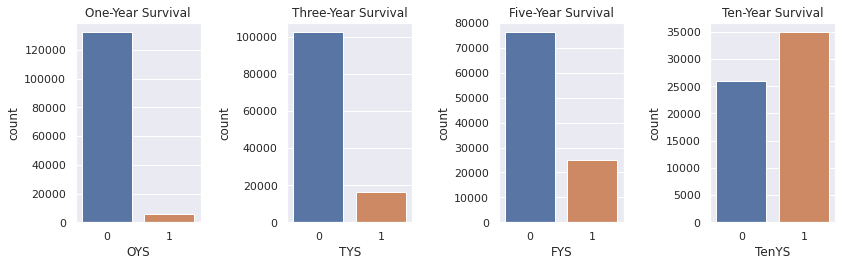

In [ ]:
#for all patients
fig, ax = plt.subplots(1,4, figsize=(12,4))
sns.countplot(OYS_2019_data['OYS'], ax = ax[0]).set_title('One-Year Survival')
sns.countplot(TYS_2019_data['TYS'], ax = ax[1]).set_title('Three-Year Survival')
sns.countplot(FYS_2019_data['FYS'], ax = ax[2]).set_title('Five-Year Survival')
sns.countplot(TenYS_2019_data['TenYS'], ax = ax[3]).set_title('Ten-Year Survival')
fig.tight_layout(pad = 1.5)
fig.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


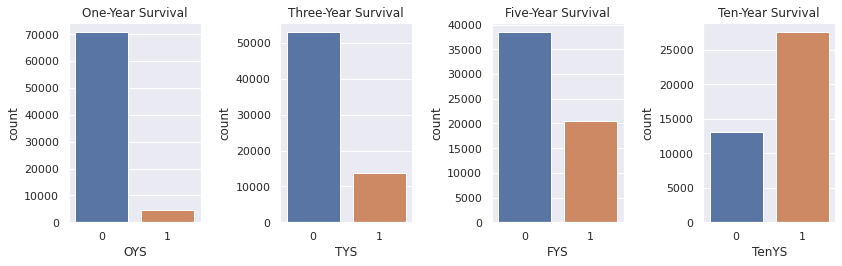

In [ ]:
#for dementia patients
fig, ax = plt.subplots(1,4, figsize=(12,4))
sns.countplot(OYS_2019_data_dementia['OYS'], ax = ax[0]).set_title('One-Year Survival')
sns.countplot(TYS_2019_data_dementia['TYS'], ax = ax[1]).set_title('Three-Year Survival')
sns.countplot(FYS_2019_data_dementia['FYS'], ax = ax[2]).set_title('Five-Year Survival')
sns.countplot(TenYS_2019_data_dementia['TenYS'], ax = ax[3]).set_title('Ten-Year Survival')
fig.tight_layout(pad = 1.5)
fig.show()

#Correlation Matrices



In [ ]:
def corr_selection(X, y, target, num_features, show=True):
  data = X.join(y)
  cor = data.corr()
  cor_target = abs(cor[target])
  cor_features = list(cor_target.sort_values(axis = 0, ascending = False)[:num_features+1].index)
  if show:
    plt.figure(figsize=(12,10))
    cor_filtered = data[cor_features].corr()
    sns.heatmap(cor_filtered, cmap='Reds', annot=True)
    plt.show()
  return cor_features

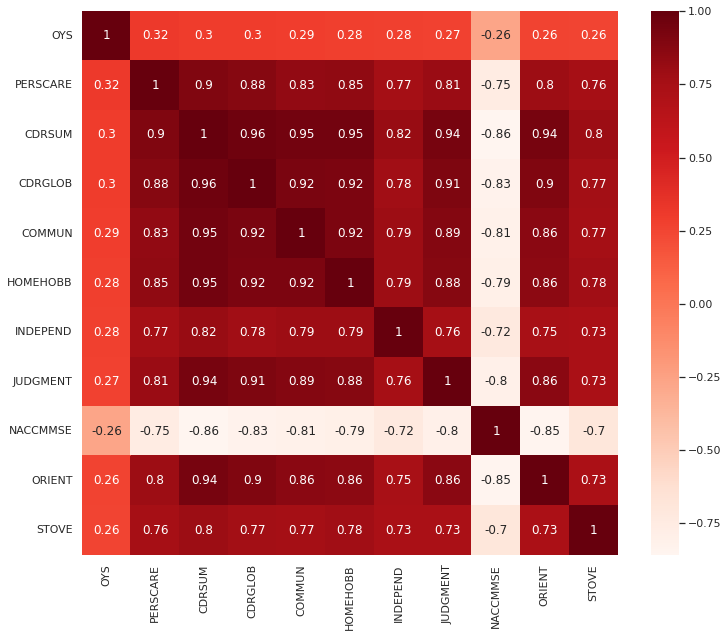

In [ ]:
cor1_features = corr_selection(x_train1, y_train1, 'OYS', 10, True)

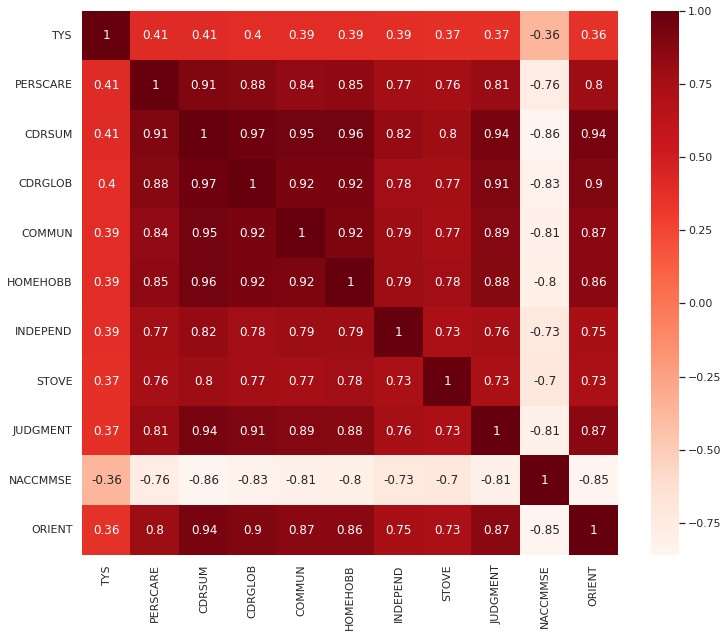

In [ ]:
cor3_features = corr_selection(x_train3, y_train3, 'TYS', 10, True)

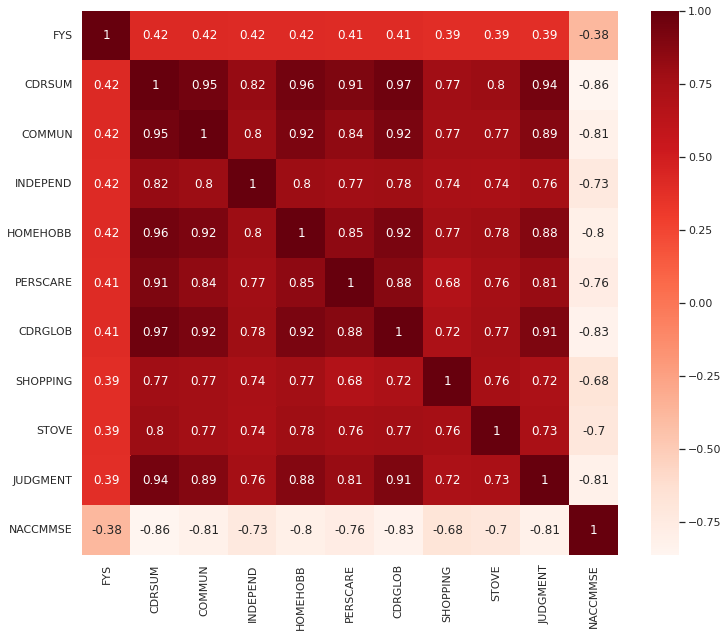

In [ ]:
cor5_features = corr_selection(x_train5, y_train5, 'FYS', 10, True)

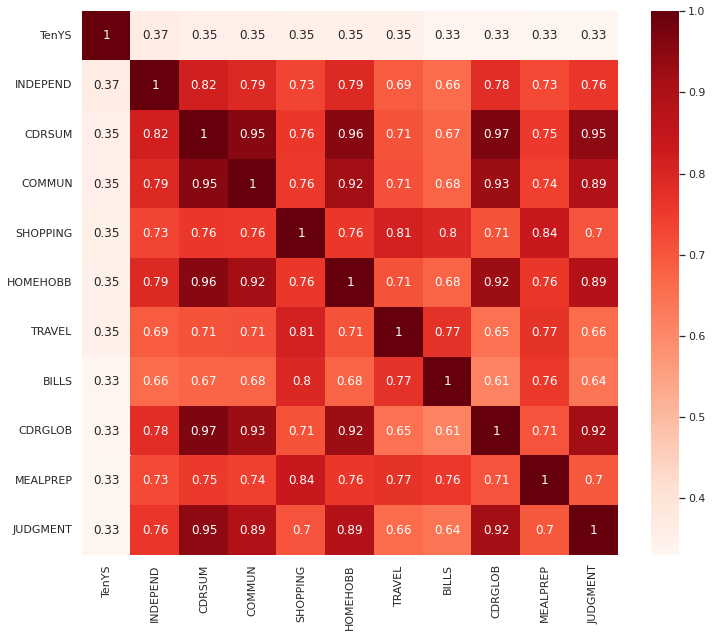

In [ ]:
cor_10_features = corr_selection(x_train10, y_train10, 'TenYS', 10, True)

# Feature Selection Using SHAP




Build baseline models for each of the 4 datasets (only dementia patients), and use SHAP on the train set to select the top features.

In [ ]:
import shap
from sklearn.model_selection import StratifiedKFold
from functools import reduce
from sklearn.base import clone

def shapBeeswarmPlot(model, data, num_features, title = "", f_name = None, save = False):
  xgb_explainer = shap.TreeExplainer(model)
  xgb_shap_values = xgb_explainer(data)

  plt.figure(figsize=(10,8))
  plt.title(title, fontdict = {'weight': 'bold', 'size': 18})
  plt.ylabel('Features')

  shap.plots.beeswarm(shap_values = xgb_shap_values, color = plt.get_cmap('cool'), max_display=num_features+1, show=False)
  
  if save:
    plt.savefig('NACC_Prediction/out/' + f_name, bbox_inches = 'tight', dpi =300)
  
  plt.show()

def shapBarPlot(model, data, num_features, title = "", f_name = None, save = False):
  xgb_explainer = shap.TreeExplainer(model)
  xgb_shap_values = xgb_explainer(data)

  plt.figure(figsize=(10,8))
  plt.title(title, fontdict = {'weight': 'bold', 'size': 18})
  plt.ylabel('Features')

  shap.plots.bar(shap_values = xgb_shap_values, max_display=num_features+1, show=False)
  
  if save:
    plt.savefig('NACC_Prediction/out/' + f_name, bbox_inches = 'tight', dpi =300)
  
  plt.show()

def shapBarPlotCV(X, y, num_features, num_folds = 5, title = "", f_name = None, save = False):
  folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state=42)
  model = XGBClassifier()
  cols = list(X.columns)
  X, y = np.array(X), np.array(y)
  shap_vals_list = []

  for train_idx, test_idx in folds.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    model.fit(X_train, y_train)
    xgb_explainer = shap.TreeExplainer(model)
    xgb_shap_values = xgb_explainer.shap_values(X_test)
  
    shap_vals_list.append(xgb_shap_values)

  #combine all shap values across CV splits
  all_shap_vals = reduce(lambda a, b: np.concatenate((np.array(a), np.array(b)), axis=0), shap_vals_list)

  plt.figure(figsize=(10,8))
  plt.title(title, fontdict = {'weight': 'bold', 'size': 32})

  shap.summary_plot(all_shap_vals, feature_names=cols, max_display=num_features, plot_type='bar', color='b', show=False)

  plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontdict={'weight': 'normal', 'size': 20})
  plt.ylabel('Features', fontdict={'weight': 'normal', 'size': 20})
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  
  if save:
    plt.savefig('NACC_Prediction/out/' + f_name, bbox_inches = 'tight', dpi =300)
  
  plt.show()

#must pass original dataset (not split into train and test)
def shapPlotBoot(model, X, y, n_iter, num_features, plot_type, title="", f_name=None, save=False):
  test_model = clone(model)
  cols = list(X.columns)
  shap_vals_list = []

  for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 + i)
    test_model.fit(X_train, y_train)

    #get shap values
    xgb_explainer = shap.TreeExplainer(test_model)
    xgb_shap_values = xgb_explainer(X_test)
    shap_vals_list.append(xgb_shap_values)

  vals = [x.values for x in shap_vals_list]
  base_vals = [x.base_values for x in shap_vals_list]
  data_vals = [x.data for x in shap_vals_list]  

  all_vals = reduce(lambda a, b: np.concatenate((a, b), axis=0), vals)
  all_base_vals = reduce(lambda a, b: np.concatenate((a, b), axis=0), base_vals)
  all_data_vals = reduce(lambda a, b: np.concatenate((a, b), axis=0), data_vals)

  #reconstuct the SHAP Explanation object
  shap_exp = shap.Explanation(values=all_vals, base_values=all_base_vals, data=all_data_vals)
  shap_exp.feature_names = cols

  plt.figure(figsize=(10,8))
  plt.title(title, fontdict = {'weight': 'bold', 'size': 32})

  if plot_type == "beeswarm":
    shap.plots.beeswarm(shap_values = shap_exp, color = plt.get_cmap('cool'), max_display=num_features+1, show=False)
  elif plot_type == "bar":
    shap.plots.bar(shap_values = shap_exp, max_display=num_features+1, show=False)
  else:
    raise Exception("Only accepting 'beeswarm' and 'bar' as valid plot types")

  plt.xlabel('SHAP Value (impact on model output)', fontdict={'weight': 'normal', 'size': 20})
  plt.ylabel('Features', fontdict={'weight': 'normal', 'size': 20})
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.legend(fontsize='large')

  if save:
    plt.savefig('NACC_Prediction/out/' + f_name, bbox_inches = 'tight', dpi =300)
  
  plt.show()

  return shap_exp

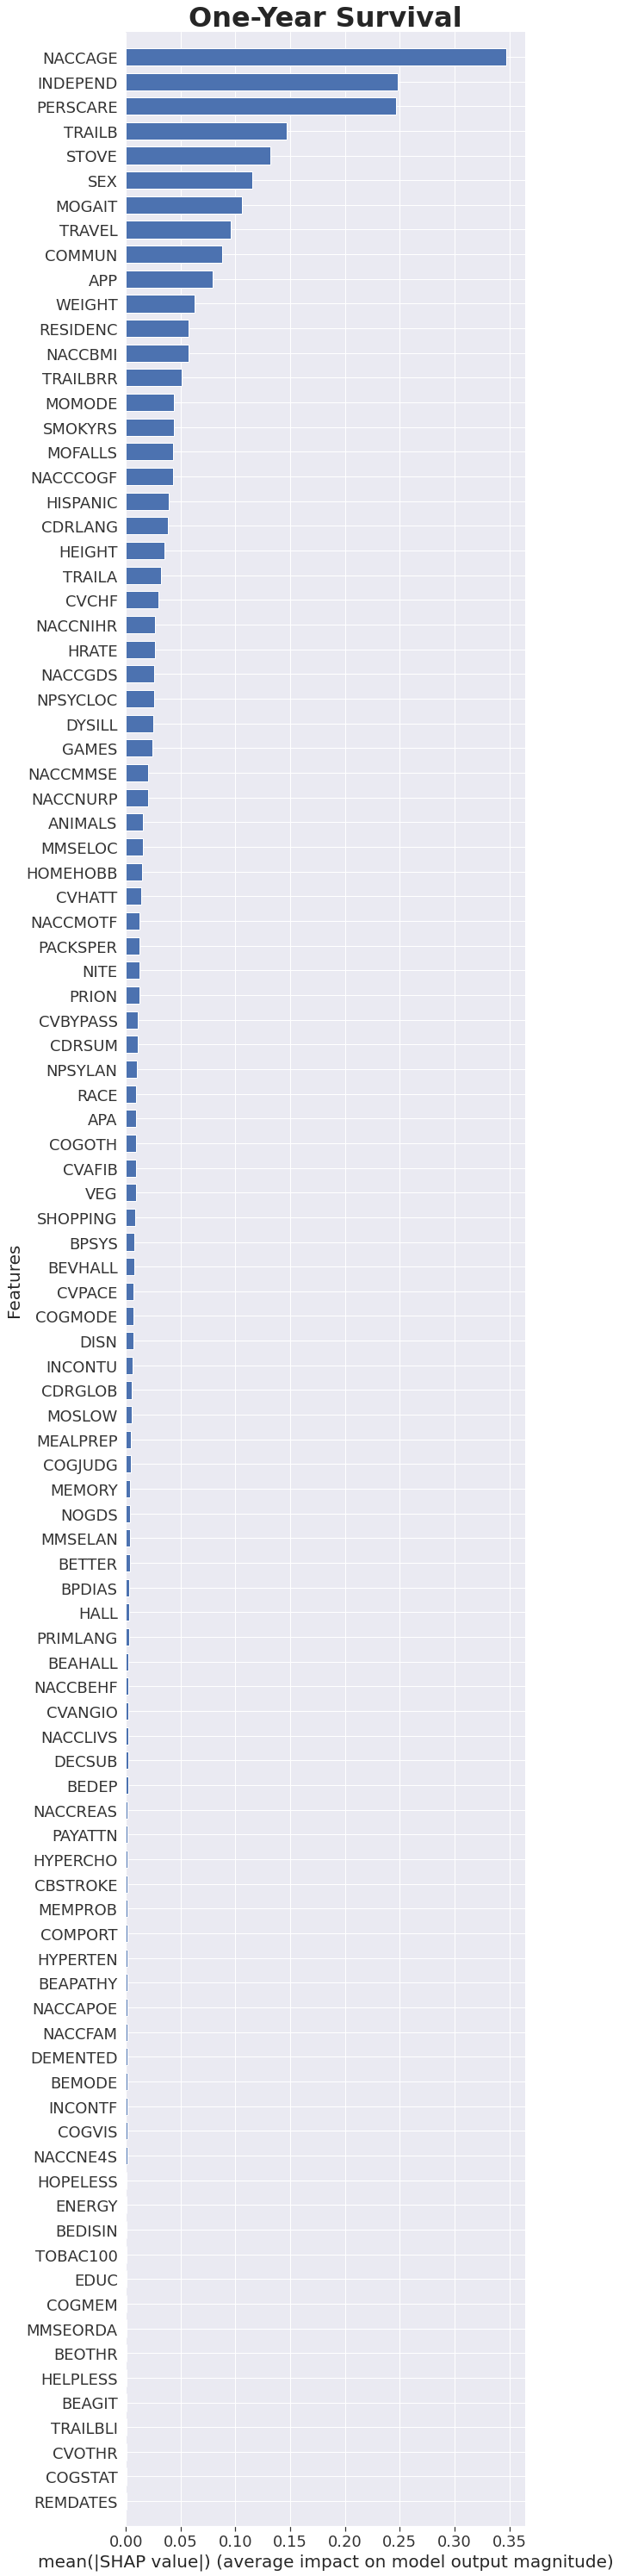

In [ ]:
shapBarPlotCV(x_train1[x_train1.columns.difference(['NACCETPR', 'NACCADC'])], y_train1, , title="One-Year Survival", f_name='OYS_all_features_shap_plot.svg', save=True)

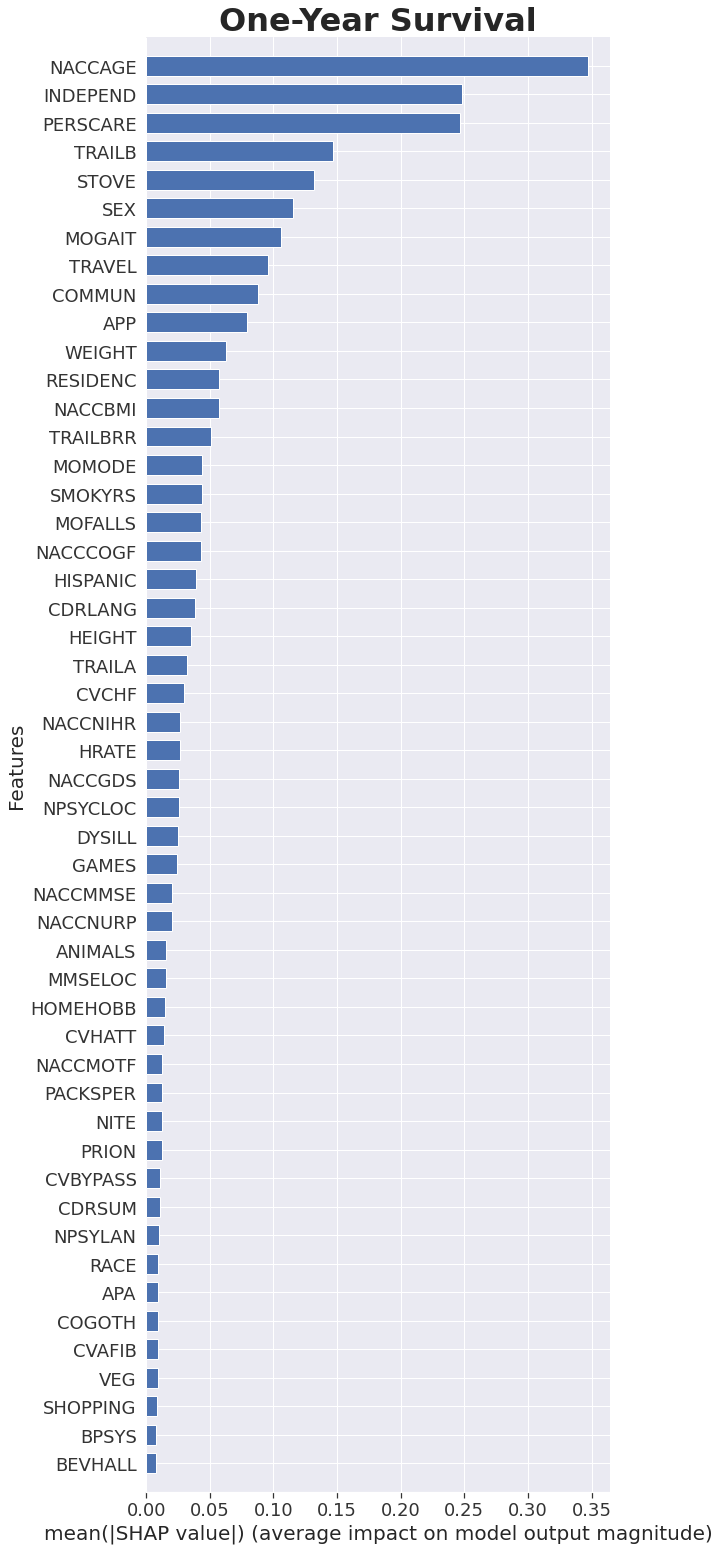

In [ ]:
shapBarPlotCV(x_train1[x_train1.columns.difference(['NACCETPR', 'NACCADC'])], y_train1, 50, title="One-Year Survival", f_name='OYS_all_features_shap_plot.svg', save=True)

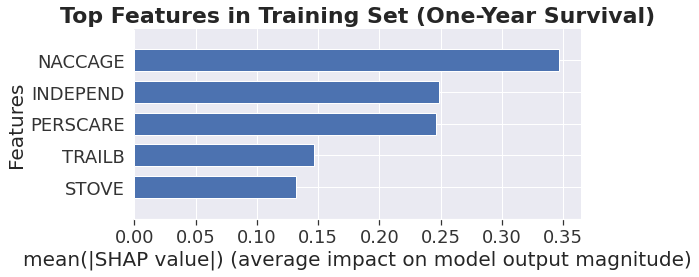

In [ ]:
shapBarPlotCV(x_train1[x_train1.columns.difference(['NACCETPR', 'NACCADC'])], y_train1, 5, title="Top Features in Training Set (One-Year Survival)", f_name='OYS_feature_selection_shap_bar_plot.svg', save=True)

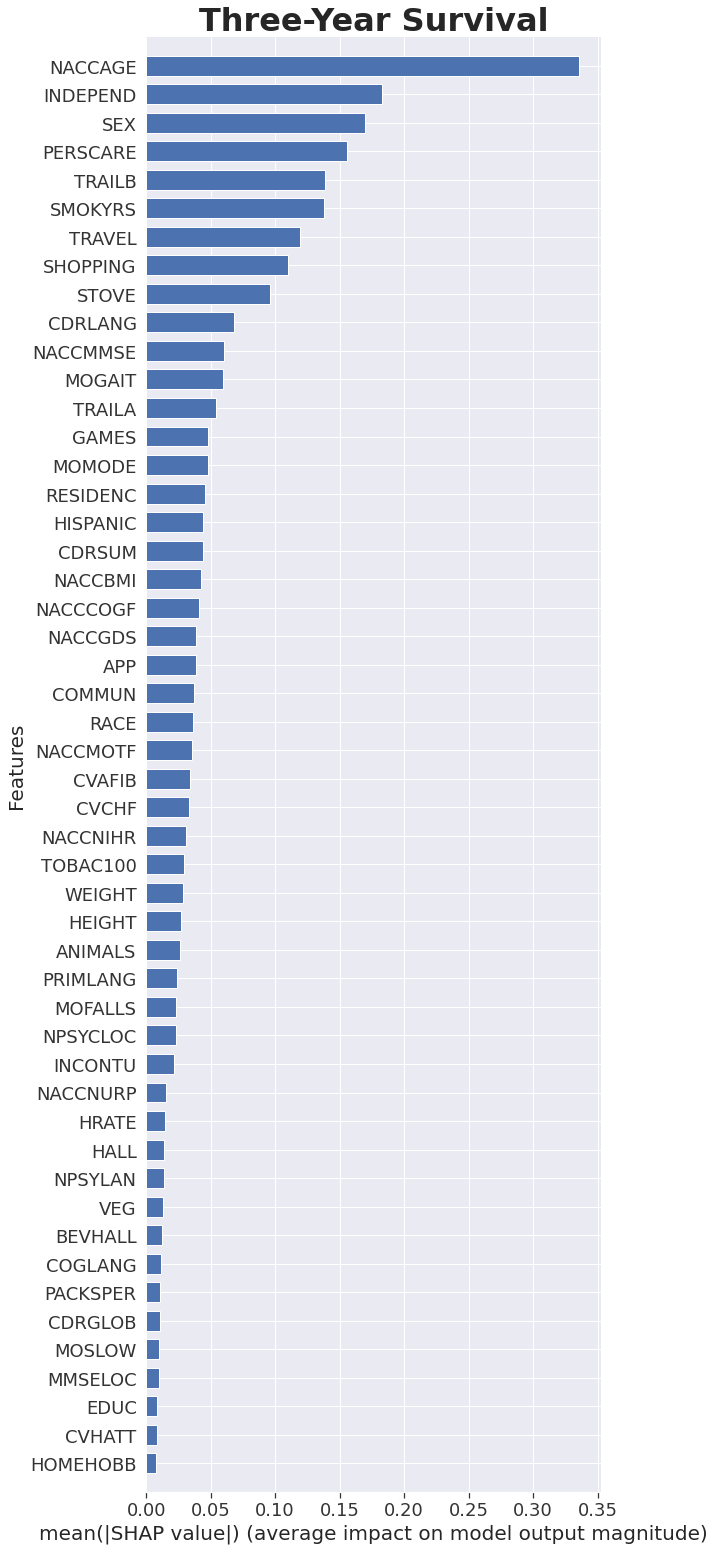

In [ ]:
shapBarPlotCV(x_train3[x_train3.columns.difference(['NACCETPR', 'NACCADC'])], y_train3, 50, title="Three-Year Survival", f_name='TYS_all_features_shap_plot.svg', save=True)

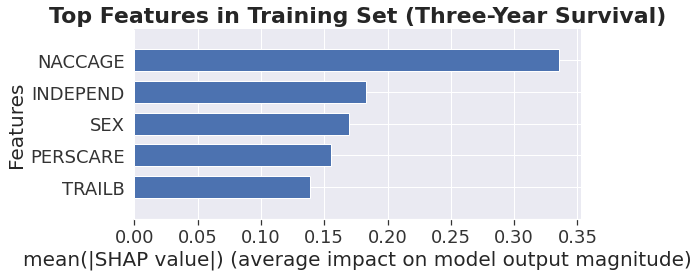

In [ ]:
shapBarPlotCV(x_train3[x_train3.columns.difference(['NACCETPR', 'NACCADC'])], y_train3, 5, title="Top Features in Training Set (Three-Year Survival)", f_name='TYS_feature_selection_shap_bar_plot.svg', save=True)

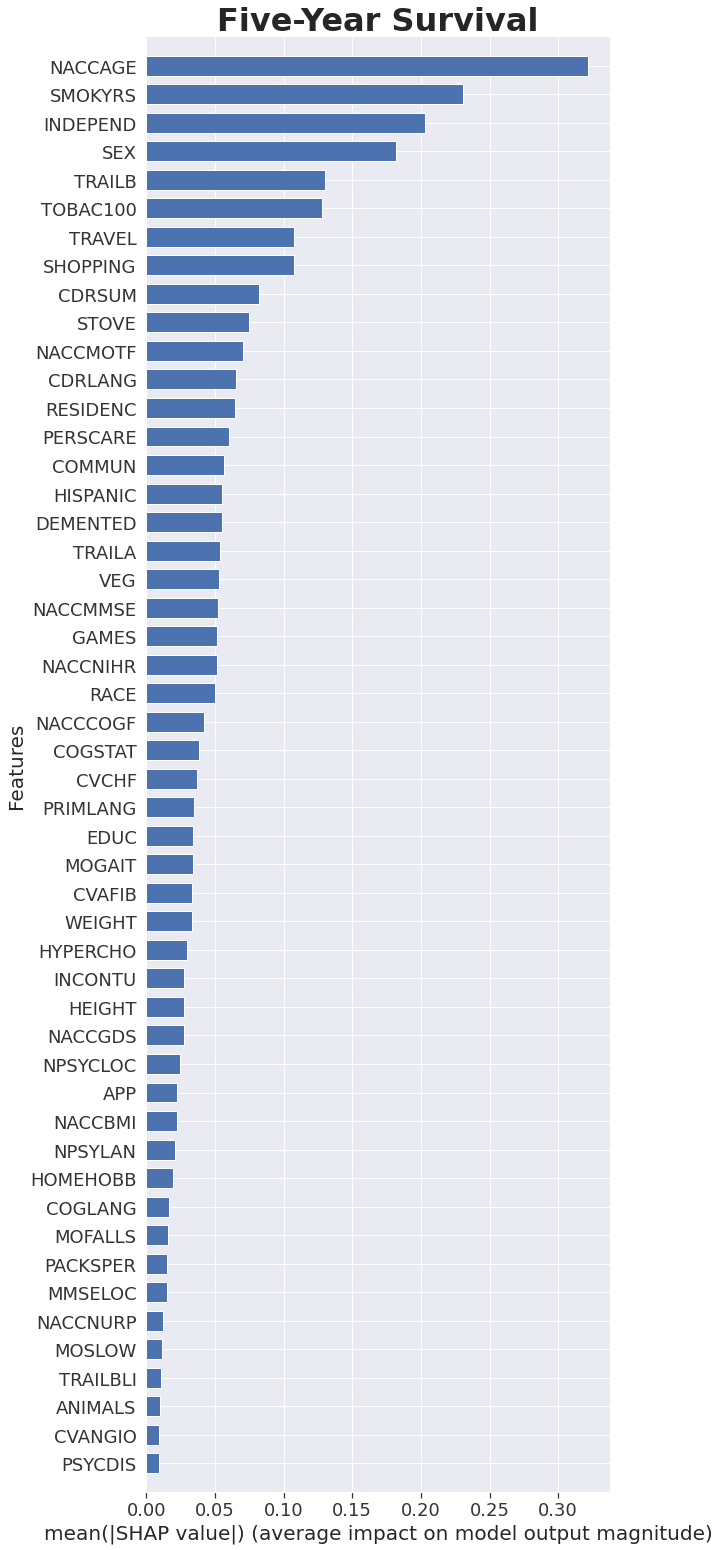

In [ ]:
shapBarPlotCV(x_train5[x_train5.columns.difference(['NACCETPR', 'NACCADC'])], y_train5, 50, title="Five-Year Survival",  f_name='FYS_all_features_shap_plot.svg', save=True)

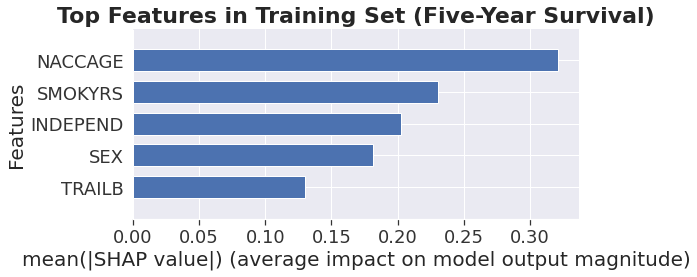

In [ ]:
shapBarPlotCV(x_train5[x_train5.columns.difference(['NACCETPR', 'NACCADC'])], y_train5, 5, title="Top Features in Training Set (Five-Year Survival)", f_name='FYS_feature_selection_shap_bar_plot.svg', save=True)

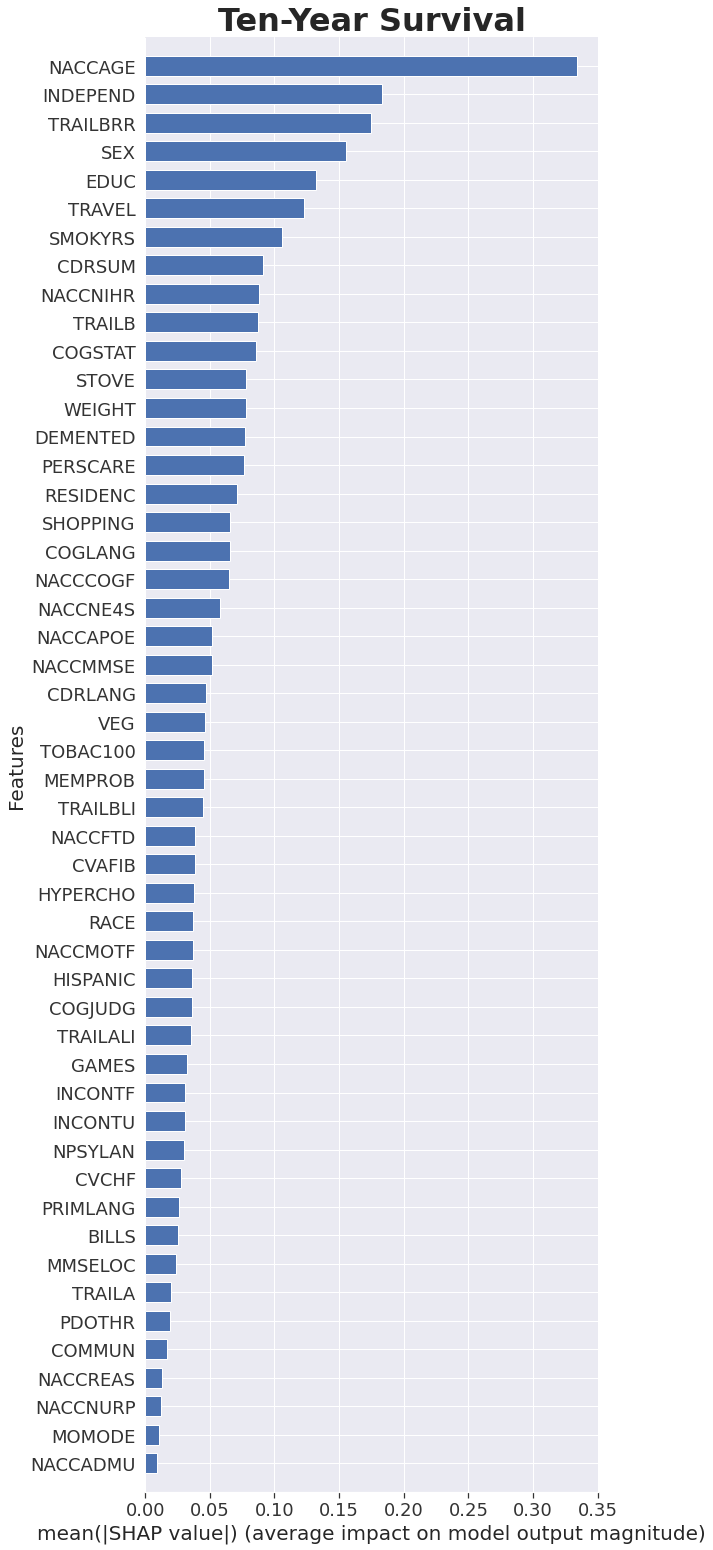

In [ ]:
shapBarPlotCV(x_train10[x_train10.columns.difference(['NACCETPR', 'NACCADC'])], y_train10, 50, title="Ten-Year Survival",  f_name='TenYS_all_features_shap_plot.svg', save=True)

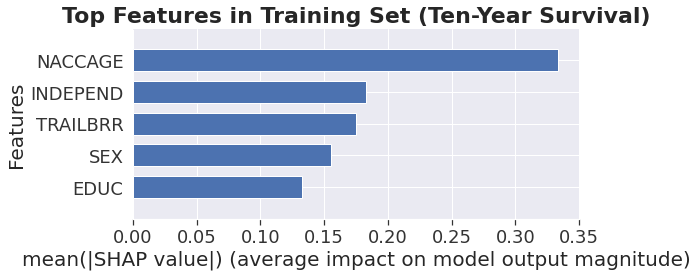

In [ ]:
shapBarPlotCV(x_train10[x_train10.columns.difference(['NACCETPR', 'NACCADC'])], y_train10, 5, title="Top Features in Training Set (Ten-Year Survival)", f_name='TenYS_feature_selection_shap_bar_plot.svg', save=True)

In [ ]:
#feature_subset = ['NACCAGE', 'INDEPEND', 'TRAILA', 'PERSCARE', 'SEX', 'TRAVEL', 'DEMENTED']
feature_subset = ['NACCAGE', 'INDEPEND', 'PERSCARE', 'TRAILB', 'STOVE', 'SEX', 'SMOKYRS', 'TRAILBRR', 'EDUC']

In [ ]:
x_train1_new, x_train3_new, x_train5_new, x_train10_new = x_train1[feature_subset], x_train3[feature_subset], x_train5[feature_subset], x_train10[feature_subset]
x_test1_new, x_test3_new, x_test5_new, x_test10_new = x_test1[feature_subset], x_test3[feature_subset], x_test5[feature_subset], x_test10[feature_subset]
x_val1_new, x_val3_new, x_val5_new, x_val10_new = x_val1[feature_subset], x_val3[feature_subset], x_val5[feature_subset], x_val10[feature_subset]

# Testing Feature Selection Using Permutation Importances

In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.1 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
def perm_selection(model, X, y, num_features, show=False):
  perm = PermutationImportance(model, scoring='roc_auc', random_state=88).fit(X, y)
  perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=X.columns.tolist()))
  if show: 
    display(eli5.show_weights(perm, feature_names=X.columns.tolist(), top=num_features))
  return list(perm_df.sort_values(by='weight', axis = 0, ascending=False).feature[:num_features]) #return top features as list

In [ ]:
dec1 = XGBClassifier()
dec1.fit(x_train1[x_train1.columns.difference(['NACCETPR', 'NACCADC'])], y_train1) #exclude NACCETPR and NACCADC from the permutation

XGBClassifier()

In [ ]:
perm1_features = perm_selection(dec1, x_train1[x_train1.columns.difference(['NACCETPR', 'NACCADC'])], y_train1, 10, True)

In [ ]:
dec3 = XGBClassifier()
dec3.fit(x_train3[x_train3.columns.difference(['NACCETPR', 'NACCADC'])], y_train3)

XGBClassifier()

In [ ]:
perm3_features = perm_selection(dec3, x_train3[x_train3.columns.difference(['NACCETPR', 'NACCADC'])], y_train3, 10, True)

In [ ]:
dec5 = XGBClassifier()
dec5.fit(x_train5[x_train5.columns.difference(['NACCETPR', 'NACCADC'])], y_train5)

XGBClassifier()

In [ ]:
perm5_features = perm_selection(dec5, x_train5[x_train5.columns.difference(['NACCETPR', 'NACCADC'])], y_train5, 10, True)

In [ ]:
dec10 = XGBClassifier()
dec10.fit(x_train10[x_train10.columns.difference(['NACCETPR', 'NACCADC'])], y_train10)

XGBClassifier()

In [ ]:
perm10_features = perm_selection(dec10, x_train10[x_train10.columns.difference(['NACCETPR', 'NACCADC'])], y_train10, 10, True)

In [ ]:
#take union of top 3 features from each survival threshold
from functools import reduce
#feature_subset = list(reduce(set.intersection, [set(x) for x in [perm1_features, perm3_features, perm5_features, perm10_features]]))
feature_subset = list(reduce(set.union, [set(x) for x in [perm1_features[:3], perm3_features[:3], perm5_features[:3], perm10_features[:3]]]))
print(feature_subset) #7 features remaining

['TOBAC100', 'SMOKYRS', 'EDUC', 'NACCAGE', 'PERSCARE', 'TRAILBRR', 'SEX']


In [ ]:
feature_subset = ['TOBAC100', 'SMOKYRS', 'EDUC', 'NACCAGE', 'PERSCARE', 'TRAILBRR', 'SEX']

In [ ]:
x_train1_new, x_train3_new, x_train5_new, x_train10_new = x_train1[feature_subset], x_train3[feature_subset], x_train5[feature_subset], x_train10[feature_subset]
x_test1_new, x_test3_new, x_test5_new, x_test10_new = x_test1[feature_subset], x_test3[feature_subset], x_test5[feature_subset], x_test10[feature_subset]
x_val1_new, x_val3_new, x_val5_new, x_val10_new = x_val1[feature_subset], x_val3[feature_subset], x_val5[feature_subset], x_val10[feature_subset]

# Hyperparameter Optimization

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=ac7fa33740f852fb4a871dee3b73a9e011550b4ad7ad120fa13b98a6bb56f8d0
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy import stats

### randomized search
def rs_tune_xgb(model, X, y, n_iter, num_folds, params):
    folds = StratifiedKFold(n_splits = num_folds, shuffle = True)
    params['scale_pos_weight'] = (sum(y == 0) / sum(y), sum(y == 0) / sum(y))
    optimized_model = RandomizedSearchCV(estimator = model, 
                                           param_distributions = params,
                                           n_iter = n_iter,
                                           scoring = 'roc_auc',
                                           cv = folds,
                                           random_state = np.random.seed(20),
                                           n_jobs = -1,
                                           verbose = 2)
    optimized_model.fit(X, y)
    print(f"Optimal Parameters: {optimized_model.best_params_}")
  
    return optimized_model.best_estimator_

### grid search
def gs_tune_xgb(model, X, y, num_folds, params): 
    folds = StratifiedKFold(n_splits = num_folds, shuffle = True)
    params['scale_pos_weight'] = (sum(y == 0) / sum(y), sum(y == 0) / sum(y))
    optimized_model = GridSearchCV(estimator = model, 
                                   param_grid = params,
                                   scoring = 'roc_auc',
                                   cv = folds,
                                   n_jobs = -1,
                                   verbose = 2)
    optimized_model.fit(X, y)
    print(f"Optimal Parameters: {optimized_model.best_params_}")
  
    return optimized_model.best_estimator_

### bayesian optimization
def bo_tune_xgb(X, y):
  def xgb_eval(n_estimators, learning_rate, max_depth, gamma, min_child_weight, subsample, colsample_bytree, scale_pos_weight):
    params = {'n_estimators' : int(n_estimators),
              'learning_rate' : learning_rate,
              'max_depth': int(max_depth),
              'gamma': gamma,
              'min_child_weight': int(min_child_weight),
              'subsample' : subsample,
              'colsample_bytree' : colsample_bytree,
              'eval_metric': 'auc',
              'scale_pos_weight': scale_pos_weight}
    dtrain = xgb.DMatrix(X, label = y)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
    #cv_result = xgb.cv(params, dtrain, num_boost_round=1000, stratified=True, nfold=5, metrics = "auc", early_stopping_rounds= 10)
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, folds=cv, maximize=True, metrics = "auc", early_stopping_rounds= 10, seed=42)                 
    return cv_result['test-auc-mean'].max()

    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
    #return cross_val_score(XGBClassifier(**params), X, y, cv=cv, scoring='roc_auc').mean()

  optimizer = BayesianOptimization(f= xgb_eval, 
                                      pbounds= {'n_estimators' : (50, 300),
                                        'learning_rate': (0.01, 0.2),
                                        'max_depth': (2, 10),
                                        'gamma': (0.01, 15), #to handle overfitting
                                        'min_child_weight': (1, 25),
                                        'subsample': (0.2, 1.0),
                                        'colsample_bytree' :(0.2, 1.0),
                                        'scale_pos_weight': (sum(y == 0) / sum(y), sum(y == 0) / sum(y))  #to handle class imbalance
                                        },
                                      random_state = np.random.seed(42),
                                      verbose = 10)

  # optimizer.maximize(init_points = 15, n_iter = 35, acq = 'ei')
  optimizer.maximize(init_points = 15, n_iter = 35, acq = 'ucb', kappa=5)
  best_params = optimizer.max['params']
  best_params['max_depth'] = int(best_params['max_depth'])
  best_params['n_estimators'] = int(best_params['n_estimators'])
  best_params['min_child_weight'] = int(best_params['min_child_weight'])

  print(f"Optimal Parameters: {best_params}")
  return XGBClassifier(**best_params) #return optimized model

In [ ]:
#bayesian optimization (OYS)
dec1_opt = bo_tune_xgb(x_train1_new, y_train1)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8424   |  0.4908   |  9.129    |  0.1936   |  6.45     |  1.214    |  283.0    |  15.08    |  0.5754   |
|  2        |  0.8391   |  0.3285   |  5.594    |  0.1442   |  8.834    |  24.62    |  284.2    |  15.08    |  0.3633   |
|  3        |  0.8437   |  0.6266   |  3.099    |  0.1517   |  2.607    |  11.84    |  199.4    |  15.08    |  0.6597   |
|  4        |  0.8264   |  0.9149   |  2.65     |  0.1362   |  9.97     |  23.07    |  73.71    |  15.08    |  0.3139   |
|  5        |  0.8417   |  0.5686   |  9.014    |  0.1087   |  9.849    |  22.85    |  154.4    |  15.08    |  0.7948   |
|  6        |  0.841    |  0.9449   |  13.04    |  0.1856   |  9.729    |  12.28    |  268.7    |  15.08    |  0.7334   |
|  7        |  0.8385   

In [ ]:
#bayesian optimization (TYS)
dec3_opt = bo_tune_xgb(x_train3_new, y_train3)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8048   |  0.3601   |  6.219    |  0.01265  |  3.084    |  6.866    |  292.8    |  3.862    |  0.8121   |
|  2        |  0.8171   |  0.2462   |  13.27    |  0.1438   |  9.58     |  12.18    |  293.1    |  3.862    |  0.7897   |
|  3        |  0.8214   |  0.593    |  1.214    |  0.1317   |  6.761    |  11.76    |  295.0    |  3.862    |  0.8711   |
|  4        |  0.8187   |  0.4335   |  7.693    |  0.08373  |  8.486    |  4.695    |  253.2    |  3.862    |  0.3153   |
|  5        |  0.8174   |  0.3278   |  12.05    |  0.06615  |  6.546    |  7.746    |  291.4    |  3.862    |  0.6392   |
|  6        |  0.8218   |  0.8478   |  4.254    |  0.0132   |  7.137    |  8.441    |  181.1    |  3.862    |  0.8343   |
|  7        |  0.8205   

In [ ]:
#bayesian optimization (FYS)
dec5_opt = bo_tune_xgb(x_train5_new, y_train5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8102   |  0.8608   |  8.548    |  0.09167  |  2.358    |  12.86    |  181.8    |  1.872    |  0.2902   |
|  2        |  0.8096   |  0.3827   |  14.03    |  0.1355   |  6.476    |  24.87    |  200.3    |  1.872    |  0.497    |
|  3        |  0.8181   |  0.5699   |  2.018    |  0.09742  |  9.249    |  18.39    |  295.8    |  1.872    |  0.6092   |
|  4        |  0.8165   |  0.5879   |  4.32     |  0.03582  |  7.291    |  18.55    |  105.3    |  1.872    |  0.6832   |
|  5        |  0.7904   |  0.3408   |  13.73    |  0.02319  |  7.808    |  13.53    |  92.86    |  1.872    |  0.4216   |
|  6        |  0.8092   |  0.553    |  8.629    |  0.1826   |  5.088    |  10.3     |  282.7    |  1.872    |  0.2321   |
|  7        |  0.8079   

In [ ]:
#bayesian optimization (TenYS)
dec10_opt = bo_tune_xgb(x_train10_new, y_train10)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7944   |  0.7315   |  11.79    |  0.1366   |  7.129    |  1.345    |  180.8    |  0.4755   |  0.2321   |
|  2        |  0.793    |  0.2478   |  11.4     |  0.06471  |  2.253    |  6.277    |  51.74    |  0.4755   |  0.2504   |
|  3        |  0.8069   |  0.9809   |  9.802    |  0.09936  |  6.428    |  7.204    |  50.63    |  0.4755   |  0.7989   |
|  4        |  0.7914   |  0.962    |  14.42    |  0.1964   |  9.576    |  7.535    |  247.4    |  0.4755   |  0.2791   |
|  5        |  0.7913   |  0.386    |  12.0     |  0.1752   |  4.637    |  21.29    |  123.0    |  0.4755   |  0.2238   |
|  6        |  0.8087   |  0.9686   |  8.655    |  0.1509   |  7.316    |  5.452    |  115.4    |  0.4755   |  0.7764   |
|  7        |  0.8181   

# Nine-Feature Models

In [ ]:
from numpy.lib.function_base import percentile
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, average_precision_score, auc
from sklearn.base import clone

##to evaluate model performance
def class_report(model, X, y):
  testing_predictions = model.predict(X)
  predictions = [round(value) for value in testing_predictions]
  return classification_report(y, predictions, digits = 4)

def get_performance_metrics(model, X, y):
  predictions = model.predict(X)
  scores = model.predict_proba(X)[:,1]
  print(f'Accuracy: {accuracy_score(y, predictions)}')
  print(f'Precision: {precision_score(y, predictions)}')
  print(f'Recall/Sensitivity/TPR: {recall_score(y, predictions)}')
  print(f'Specificity/1-FPR: {recall_score(y, predictions, pos_label=0)}')
  print(f'ROC-AUC: {roc_auc_score(y, scores)}')
  print(f'PR-AUC: {average_precision_score(y, scores)}')

#to bootstrap a model
def bootstrap(model, X, y, n_iter): #must pass original dataset (not split into train and test)
  #metrics to track
  accuracy_vals = []
  precision_vals = []
  sens_vals = [] #same as tpr and recall
  spec_vals = [] # 1 - fpr
  roc_aucs = []
  pr_aucs = []
  #interp_tprs = [] #for plotting ROC curve with CIs

  #clone model to not affect original model
  test_model = clone(model)

  for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 + i)
  
    test_model.fit(X_train, y_train)
    predictions = test_model.predict(X_test)
    scores = test_model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, scores)

    accuracy_vals.append(accuracy_score(y_test, predictions))
    precision_vals.append(precision_score(y_test, predictions))
    sens_vals.append(recall_score(y_test, predictions))
    spec_vals.append(recall_score(y_test, predictions, pos_label=0))
    roc_aucs.append(roc_auc_score(y_test, scores))
    pr_aucs.append(average_precision_score(y_test, scores))
    #interp_tprs.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))

  return {'accuracy': accuracy_vals,
          'precision': precision_vals,
          'sensitivity': sens_vals,
          'specificity': spec_vals,
          'roc_auc': roc_aucs,
          'pr_auc': pr_aucs
          }

#to get confidence intervals
def getCI(values, alpha):
  mean = np.mean(values)
  lower_ci = np.percentile(values, alpha/2)
  upper_ci = np.percentile(values, 100 - alpha/2)

  return lower_ci, upper_ci

# plot ROC curve
def draw_roc_curve(model, X_list, y_list, names, figsize = (10,8), title = "Receiver Operating Characteristic Curve", alphas = None, f_name = None, save=False):
  plt.figure(figsize=figsize)
  ax = plt.gca()
  ax.spines['bottom'].set_color('black')
  ax.spines['left'].set_color('black')
  ax.set_facecolor((0.96, 0.96, 0.96))

  plt.title(title, fontdict = {'weight': 'bold', 'size': 36})
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate', fontdict={'weight': 'normal', 'size': 22})
  plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=20)
  plt.xlim([-0.01, 1.01])
  plt.xlabel('False Positive Rate', fontdict={'weight': 'normal', 'size': 22})
  plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=20) 
  
  assert len(X_list) == len(y_list) == len(names), "The number of X datasets, y datasets, and names must be the same"

  for i in range(len(X_list)):
    if alphas:
      RocCurveDisplay.from_estimator(estimator=model, X=X_list[i], y=y_list[i], name = names[i], alpha=alphas[i], ax=ax)
    else:
      RocCurveDisplay.from_estimator(estimator=model, X=X_list[i], y=y_list[i], name = names[i], ax=ax)

  plt.legend(loc = 'lower right', fontsize='large')
  
  if save:
    plt.savefig('NACC_Prediction/out/' + f_name, bbox_inches = 'tight', dpi =300)

  plt.show()

# plot PR curve
def draw_pr_curve(model, X_list, y_list, names, figsize=(10,8), title = "Precision-Recall Curve", alphas = None, f_name = None, save=False):
  plt.figure(figsize=figsize)
  ax = plt.gca()
  ax.spines['bottom'].set_color('black')
  ax.spines['left'].set_color('black')
  ax.set_facecolor((0.96, 0.96, 0.96))

  plt.title(title, fontdict = {'weight': 'bold', 'size': 20})
  plt.plot([0, 0], [1, 1],'r--')
  plt.ylim([-0.01, 1.01])
  plt.ylabel('Precision', fontdict={'weight': 'normal', 'size': 16})
  plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize='large')
  plt.xlim([-0.01, 1.01])
  plt.xlabel('Recall', fontdict={'weight': 'normal', 'size': 16})
  plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize='large') 

  assert len(X_list) == len(y_list) == len(names), "The number of X datasets, y datasets, and names must be the same"

  for i in range(len(X_list)):
    if alphas:
      PrecisionRecallDisplay.from_estimator(estimator=model, X=X_list[i], y=y_list[i], name = names[i], alpha = alphas[i], ax=ax)
    else:
      PrecisionRecallDisplay.from_estimator(estimator=model, X=X_list[i], y=y_list[i], name = names[i], ax=ax)
  
  plt.legend(loc = 'lower right', fontsize='large')

  if save:
    plt.savefig('NACC_Prediction/out/' + f_name, bbox_inches = 'tight', dpi =300)

  plt.show()

## One-Year Survival Model

In [ ]:
dec1_opt = XGBClassifier(**{'colsample_bytree': 0.4702083757721486, 
                            'gamma': 3.491734298234034, 
                            'learning_rate': 0.01947957043058029, 
                            'max_depth': 3, 
                            'min_child_weight': 11,
                            'n_estimators': 101, 
                            'scale_pos_weight': 15.080713905167821, 
                            'subsample': 0.3250728888913934})

In [ ]:
dec1_opt.fit(x_train1_new, y_train1)

XGBClassifier(colsample_bytree=0.4702083757721486, gamma=3.491734298234034,
              learning_rate=0.01947957043058029, min_child_weight=11,
              n_estimators=101, scale_pos_weight=15.080713905167821,
              subsample=0.3250728888913934)

In [ ]:
get_performance_metrics(dec1_opt, x_test1_new, y_test1)

Accuracy: 0.7804797243572754
Precision: 0.19088243135163957
Recall/Sensitivity/TPR: 0.7203219315895373
Specificity/1-FPR: 0.7847212370549014
ROC-AUC: 0.8247132104586663
PR-AUC: 0.25915868382006507


In [ ]:
get_performance_metrics(dec1_opt, x_val1_new, y_val1)

Accuracy: 0.8169000388953714
Precision: 0.19945479327578375
Recall/Sensitivity/TPR: 0.7839285714285714
Specificity/1-FPR: 0.8187988482106129
ROC-AUC: 0.8704089109419992
PR-AUC: 0.30041033520367155


In [ ]:
boot_1 = bootstrap(dec1_opt, feature_one[feature_subset], target_one, 50)

In [ ]:
#to get 95% CIs
for stat in boot_1.keys():
  print(f'{stat}: {getCI(boot_1[stat], 0.05)}')

accuracy: (0.7703678770209382, 0.7884155347203816)
precision: (0.17476942333770254, 0.19506720251734636)
sensitivity: (0.7024379376242585, 0.768828108057648)
specificity: (0.7720142970163371, 0.7908193347221566)
roc_auc: (0.8199861056626104, 0.8504720657476665)
pr_auc: (0.25664018509155456, 0.3008121806884072)


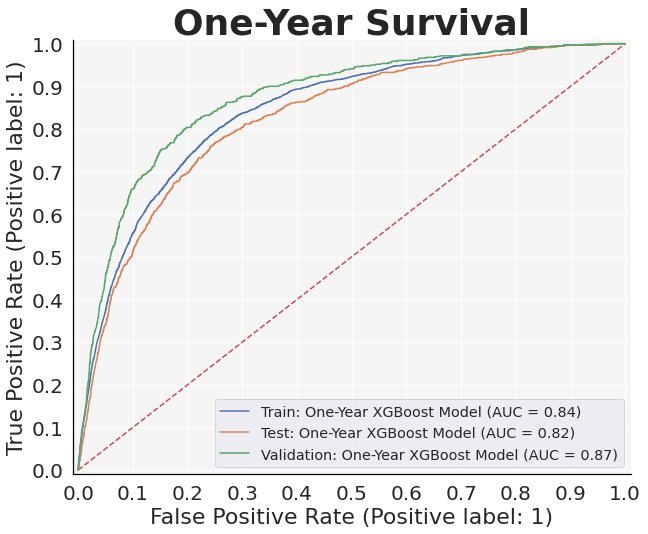

In [ ]:
X1 = [x_train1_new, x_test1_new, x_val1_new]
Y1 = [y_train1, y_test1, y_val1]
NAMES1 = ['Train: One-Year XGBoost Model', 'Test: One-Year XGBoost Model', 'Validation: One-Year XGBoost Model']
draw_roc_curve(dec1_opt, X1, Y1, NAMES1, title="One-Year Survival", f_name = 'roc_oys_all_dementia.svg', save=True)

No handles with labels found to put in legend.


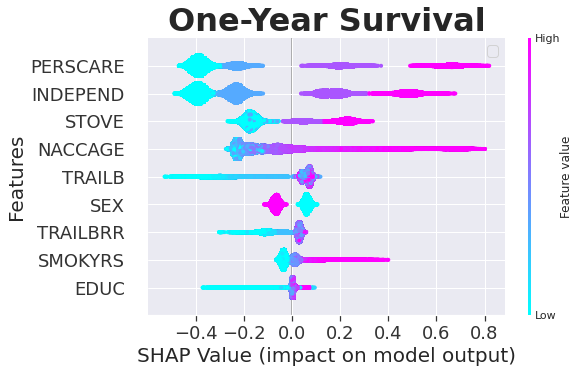

.values =
array([[-0.18435328, -0.20368522, -0.41043997, ..., -0.04950327,
         0.03077051, -0.00306415],
       [-0.18025394, -0.3688296 , -0.43806493, ...,  0.01816089,
        -0.0524913 ,  0.00621851],
       [ 0.01578202, -0.20332094, -0.40378436, ..., -0.046173  ,
         0.03478742, -0.00385145],
       ...,
       [-0.16535653, -0.25091246, -0.3612136 , ..., -0.02231407,
         0.03324144, -0.06864458],
       [-0.02219695, -0.3965046 , -0.42214283, ..., -0.03544995,
        -0.10215265,  0.00465294],
       [ 0.19947024,  0.4486961 ,  0.18956494, ..., -0.02353214,
         0.01862902, -0.00794123]], dtype=float32)

.base_values =
array([0.0299496 , 0.0299496 , 0.0299496 , ..., 0.01967026, 0.01967026,
       0.01967026], dtype=float32)

.data =
array([[74,  2,  0, ...,  0,  5, 12],
       [73,  1,  0, ..., 17,  2, 18],
       [83,  2,  0, ...,  0,  5, 12],
       ...,
       [75,  2,  0, ..., 10,  4,  6],
       [82,  1,  0, ...,  1,  0, 16],
       [89,  4,  2, ...,  0,

In [ ]:
#one-year XGBoost SHAP plot (bootstrapped)
shapPlotBoot(dec1_opt, feature_one[feature_subset], target_one, 50, 9, 'beeswarm', title='One-Year Survival', f_name='oys_shap_all.svg', save=True)

## Three-Year Survival Model

In [ ]:
dec3_opt = XGBClassifier(**{'colsample_bytree': 0.8239440221398204,
                            'gamma': 0.3984835894629145, 
                            'learning_rate': 0.022065849803950155, 
                            'max_depth': 5, 
                            'min_child_weight': 20,
                            'n_estimators': 226, 
                            'scale_pos_weight': 3.8619147576891484, 
                            'subsample': 0.8650497733862141})

In [ ]:
dec3_opt.fit(x_train3_new, y_train3)

XGBClassifier(colsample_bytree=0.8239440221398204, gamma=0.3984835894629145,
              learning_rate=0.022065849803950155, max_depth=5,
              min_child_weight=20, n_estimators=226,
              scale_pos_weight=3.8619147576891484,
              subsample=0.8650497733862141)

In [ ]:
get_performance_metrics(dec3_opt, x_test3_new, y_test3)

Accuracy: 0.7501877158732543
Precision: 0.4329059829059829
Recall/Sensitivity/TPR: 0.75064838829196
Specificity/1-FPR: 0.7500706281194086
ROC-AUC: 0.8246237589399916
PR-AUC: 0.5662771229394826


In [ ]:
get_performance_metrics(dec3_opt, x_val3_new, y_val3)

Accuracy: 0.7518178670360111
Precision: 0.3923154701718908
Recall/Sensitivity/TPR: 0.7702233250620347
Specificity/1-FPR: 0.7479291181713327
ROC-AUC: 0.8373035566583954
PR-AUC: 0.5389729917670947


In [ ]:
boot_3 = bootstrap(dec3_opt, feature_three[feature_subset], target_three, 50)

In [ ]:
#to get 95% CIs
for stat in boot_3.keys():
  print(f'{stat}: {getCI(boot_3[stat], 0.05)}')

accuracy: (0.7431360376933474, 0.7575964296440907)
precision: (0.4215210685035192, 0.4513967623651434)
sensitivity: (0.7250580228621444, 0.7532196674975296)
specificity: (0.7414596137554721, 0.760532642569604)
roc_auc: (0.8170608953373047, 0.8301274204362101)
pr_auc: (0.544747731337948, 0.5877386643963719)


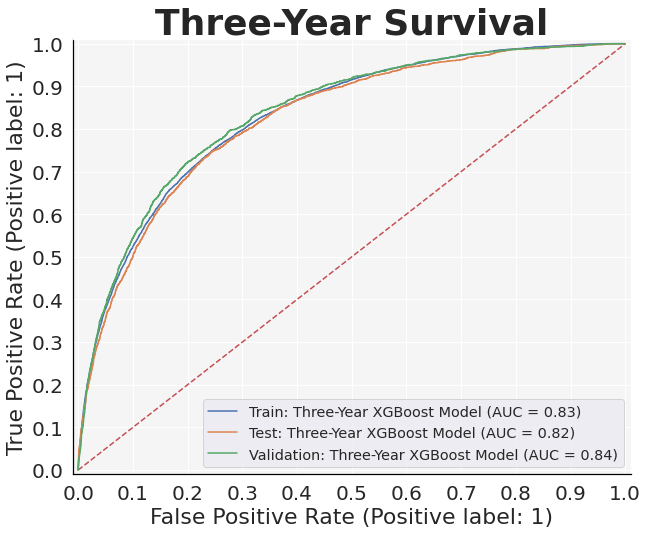

In [ ]:
X3 = [x_train3_new, x_test3_new, x_val3_new]
Y3 = [y_train3, y_test3, y_val3]
NAMES3 = ['Train: Three-Year XGBoost Model', 'Test: Three-Year XGBoost Model', 'Validation: Three-Year XGBoost Model']
draw_roc_curve(dec3_opt, X3, Y3, NAMES3, title="Three-Year Survival", f_name = 'roc_tys_all_dementia.svg', save=True)

No handles with labels found to put in legend.


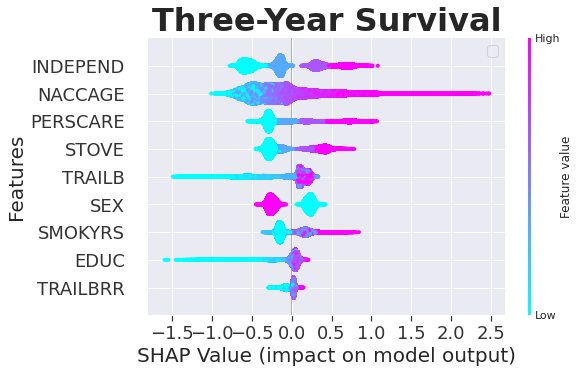

.values =
array([[-3.1753391e-01, -1.2210619e-01, -2.6556370e-01, ...,
        -1.3426444e-01,  5.7989690e-02, -1.5452581e-03],
       [ 1.0157242e+00, -1.4956725e-01, -1.9322953e-01, ...,
        -1.5854436e-01,  3.6785826e-02,  2.8642064e-02],
       [-5.8664310e-01, -6.0027707e-01, -2.9964033e-01, ...,
         1.2836853e-01, -5.5725116e-02,  7.8717126e-03],
       ...,
       [-1.8582328e-01,  4.4421038e-01, -3.6435133e-01, ...,
        -1.3416909e-01,  1.5141520e-02,  5.2422240e-02],
       [ 5.3890723e-01, -5.0487435e-01, -2.5010064e-01, ...,
         2.6336852e-01,  4.8625219e-04,  4.8865378e-02],
       [-3.6027861e-01,  4.5847985e-01, -3.3670071e-01, ...,
        -1.5231505e-01,  1.5064073e-02,  7.3034197e-02]], dtype=float32)

.base_values =
array([ 0.00484376,  0.00484376,  0.00484376, ..., -0.00790008,
       -0.00790008, -0.00790008], dtype=float32)

.data =
array([[72,  2,  0, ...,  0,  8, 12],
       [92,  2,  0, ...,  0,  5, 17],
       [71,  1,  0, ..., 24,  0, 16],
  

In [ ]:
#three-year XGBoost SHAP plot (bootstrapped)
shapPlotBoot(dec3_opt, feature_three[feature_subset], target_three, 50, 9, 'beeswarm', title='Three-Year Survival', f_name='tys_shap_all.svg', save=True)

## Five-Year Survival Model

In [ ]:
dec5_opt = XGBClassifier(**{'colsample_bytree': 0.8146919649958615, 
                            'gamma': 1.9476924368591892, 
                            'learning_rate': 0.011888302858035129, 
                            'max_depth': 9, 
                            'min_child_weight': 20, 
                            'n_estimators': 264, 
                            'scale_pos_weight': 1.8720258017404003,
                            'subsample': 0.763523668594309})

In [ ]:
dec5_opt.fit(x_train5_new, y_train5)

XGBClassifier(colsample_bytree=0.8146919649958615, gamma=1.9476924368591892,
              learning_rate=0.011888302858035129, max_depth=9,
              min_child_weight=20, n_estimators=264,
              scale_pos_weight=1.8720258017404003, subsample=0.763523668594309)

In [ ]:
get_performance_metrics(dec5_opt, x_test5_new, y_test5)

Accuracy: 0.7435593220338983
Precision: 0.6087652591554933
Recall/Sensitivity/TPR: 0.7396061269146609
Specificity/1-FPR: 0.7456745154156368
ROC-AUC: 0.8233726737045449
PR-AUC: 0.722035582900265


In [ ]:
get_performance_metrics(dec5_opt, x_val5_new, y_val5)

Accuracy: 0.7102977667493796
Precision: 0.5046620046620046
Recall/Sensitivity/TPR: 0.7832378655411516
Specificity/1-FPR: 0.6799297100539726
ROC-AUC: 0.8172832242617922
PR-AUC: 0.6667651842914906


In [ ]:
boot_5 = bootstrap(dec5_opt, feature_five[feature_subset], target_five, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5.keys():
  print(f'{stat}: {getCI(boot_5[stat], 0.05)}')

accuracy: (0.7349422457627118, 0.7494057415254237)
precision: (0.5968325996296258, 0.6217789998068113)
sensitivity: (0.7256869014555595, 0.7521073940359961)
specificity: (0.7374453683142014, 0.756495457452149)
roc_auc: (0.8127089741099529, 0.8260893482031942)
pr_auc: (0.702120072536277, 0.7299077982451665)


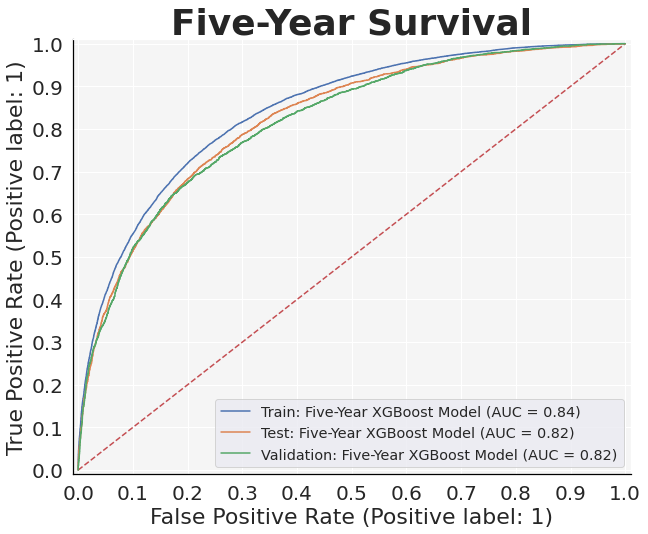

In [ ]:
X5 = [x_train5_new, x_test5_new, x_val5_new]
Y5 = [y_train5, y_test5, y_val5]
NAMES5 = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_opt, X5, Y5, NAMES5, title="Five-Year Survival", f_name = 'roc_fys_all_dementia.svg', save=True)

No handles with labels found to put in legend.


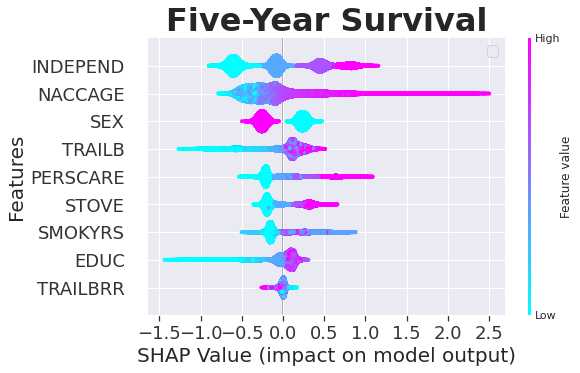

.values =
array([[ 0.63460326, -0.5539594 , -0.1948836 , ..., -0.18860483,
        -0.01392743, -0.08703507],
       [ 1.1257516 ,  0.28720614, -0.30810577, ..., -0.1577175 ,
        -0.02297584, -0.4869221 ],
       [ 0.07527465, -0.07202869, -0.18611734, ...,  0.38258284,
        -0.00730742,  0.13866436],
       ...,
       [-0.13003196, -0.08569444, -0.21465795, ..., -0.20196737,
        -0.05265769,  0.06400677],
       [-0.3509811 , -0.607779  , -0.21942559, ..., -0.1468102 ,
        -0.02002279, -0.02697792],
       [-0.61194557, -0.64732116, -0.21399885, ...,  0.01274187,
        -0.03039918,  0.04605164]], dtype=float32)

.base_values =
array([0.00656004, 0.00656004, 0.00656004, ..., 0.00806175, 0.00806175,
       0.00806175], dtype=float32)

.data =
array([[86,  1,  0, ...,  0,  0, 12],
       [95,  3,  0, ...,  0,  3,  8],
       [82,  2,  0, ..., 55,  1, 16],
       ...,
       [79,  2,  0, ...,  0,  0, 16],
       [74,  1,  0, ...,  8,  0, 15],
       [65,  1,  0, ..., 30,

In [ ]:
#five-year XGBoost SHAP plot (bootstrapped)
shapPlotBoot(dec5_opt, feature_five[feature_subset], target_five, 50, 9, 'beeswarm', title='Five-Year Survival', f_name='fys_shap_all.svg', save=True)

## Ten-Year Survival Model

In [ ]:
dec10_opt = XGBClassifier(**{'colsample_bytree': 0.6190663935568624, 
                             'gamma': 1.0746222391334157, 
                             'learning_rate': 0.04553578809710836, 
                             'max_depth': 8, 
                             'min_child_weight': 7, 
                             'n_estimators': 299, 
                             'scale_pos_weight': 0.47551307026684186,
                             'subsample': 0.6652283651543935})

In [ ]:
dec10_opt.fit(x_train10_new, y_train10)

XGBClassifier(colsample_bytree=0.6190663935568624, gamma=1.0746222391334157,
              learning_rate=0.04553578809710836, max_depth=8,
              min_child_weight=7, n_estimators=299,
              scale_pos_weight=0.47551307026684186,
              subsample=0.6652283651543935)

In [ ]:
get_performance_metrics(dec10_opt, x_test10_new, y_test10)

Accuracy: 0.7484956404273609
Precision: 0.8553147574819402
Recall/Sensitivity/TPR: 0.7546894918958296
Specificity/1-FPR: 0.7356711915535445
ROC-AUC: 0.8289577034461713
PR-AUC: 0.9049028171234066


In [ ]:
get_performance_metrics(dec10_opt, x_val10_new, y_val10)

Accuracy: 0.6930499020051258
Precision: 0.5962750315081922
Recall/Sensitivity/TPR: 0.7817147053423903
Specificity/1-FPR: 0.6312827727330861
ROC-AUC: 0.7886043592344351
PR-AUC: 0.7409921137943956


In [ ]:
boot_10 = bootstrap(dec10_opt, feature_ten[feature_subset], target_ten, 50)

In [ ]:
#to get 95% CIs
for stat in boot_10.keys():
  print(f'{stat}: {getCI(boot_10[stat], 0.05)}')

accuracy: (0.7334056858651602, 0.7548529104752548)
precision: (0.8436718969884605, 0.8699907246740122)
sensitivity: (0.7333169972096946, 0.7616166655348868)
specificity: (0.716511754774503, 0.7567856104328523)
roc_auc: (0.8139374487278277, 0.8320887913193985)
pr_auc: (0.896057178202446, 0.9109580750394963)


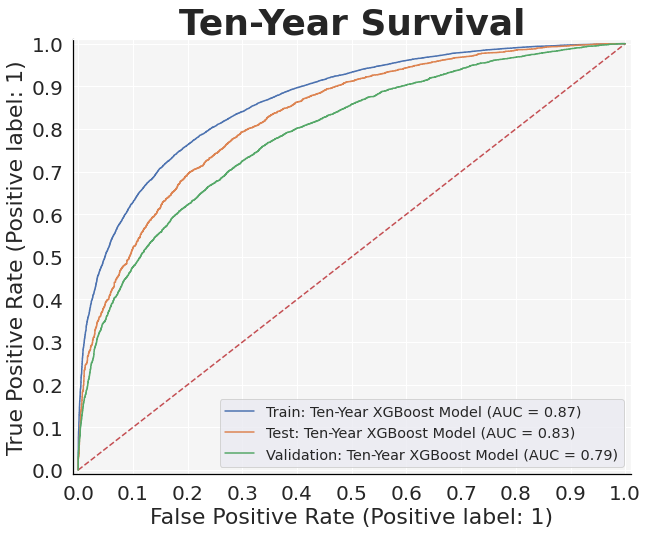

In [ ]:
X10 = [x_train10_new, x_test10_new, x_val10_new]
Y10 = [y_train10, y_test10, y_val10]
NAMES10 = ['Train: Ten-Year XGBoost Model', 'Test: Ten-Year XGBoost Model', 'Validation: Ten-Year XGBoost Model']
draw_roc_curve(dec10_opt, X10, Y10, NAMES10, title="Ten-Year Survival", f_name = 'roc_tenys_all_dementia.svg', save=True)

No handles with labels found to put in legend.


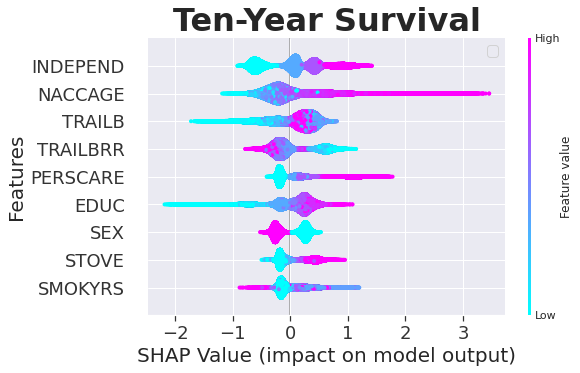

.values =
array([[-0.05642931, -0.01891339,  0.04583765, ...,  0.07096369,
        -0.01429297,  0.32339078],
       [-0.22088419,  0.10750887, -0.1548019 , ...,  0.04597568,
         0.42923418,  0.25285268],
       [-0.49359348,  0.03964429,  0.06119418, ..., -0.07711922,
         0.42149082,  0.28091714],
       ...,
       [-0.31820023, -0.64791304, -0.26290163, ..., -0.10571063,
         0.52728575,  0.00357833],
       [-0.19705155,  0.16891558, -0.24715023, ..., -0.13170391,
        -0.32683098,  0.19408703],
       [-0.2384539 , -0.6223506 , -0.264001  , ...,  0.14057365,
        -0.353746  ,  0.14376639]], dtype=float32)

.base_values =
array([-0.03849839, -0.03849839, -0.03849839, ..., -0.03335015,
       -0.03335015, -0.03335015], dtype=float32)

.data =
array([[80,  2,  1, ..., 30,  3, 16],
       [63,  2,  0, ...,  1,  1, 16],
       [66,  2,  1, ...,  0,  1, 20],
       ...,
       [44,  1,  0, ...,  0,  0, 14],
       [77,  2,  0, ...,  0,  4, 16],
       [78,  1,  0, ..

In [ ]:
#ten-year XGBoost SHAP plot (bootstrapped)
shapPlotBoot(dec10_opt, feature_ten[feature_subset], target_ten, 50, 9, 'beeswarm', title='Ten-Year Survival', f_name='tenys_shap_all.svg', save=True)

## Sub-ADC Analysis

Verify model performance within each ADC

In [ ]:
#only take ADCs with at least 200 patients in the test set
OYS_ADCs = [x for x in x_test1.NACCADC.unique() if len(x_test1[x_test1['NACCADC'] == x]) >= 200]
TYS_ADCs = [x for x in x_test3.NACCADC.unique() if len(x_test3[x_test3['NACCADC'] == x]) >= 200]
FYS_ADCs = [x for x in x_test5.NACCADC.unique() if len(x_test5[x_test5['NACCADC'] == x]) >= 200]
TenYS_ADCs = [x for x in x_test10.NACCADC.unique() if len(x_test10[x_test10['NACCADC'] == x]) >= 200]

### OYS

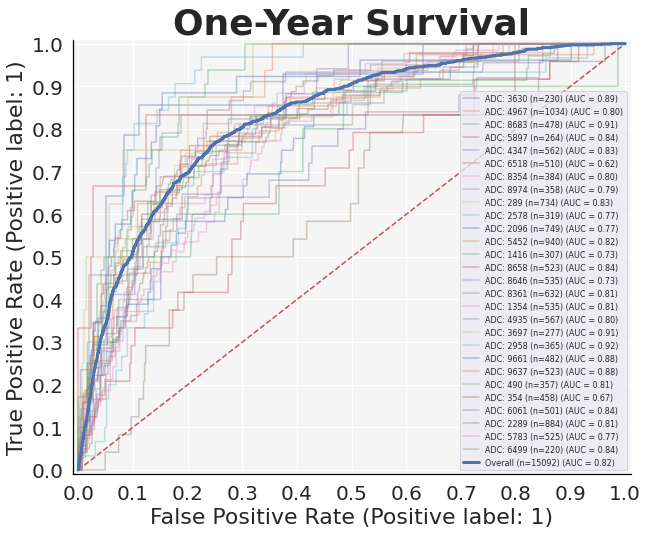

In [ ]:
#verify performance within each ADC in the test set
X1_ADC = [x_test1[x_test1['NACCADC'] == adc][feature_subset] for adc in OYS_ADCs] + [x_test1_new] #append entire dataset
Y1_ADC = [y_test1[x_test1['NACCADC'] == adc] for adc in OYS_ADCs] + [y_test1]
NAMES1_ADC = [f'ADC: {adc} (n={sum(x_test1.NACCADC==adc)})' for adc in OYS_ADCs]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('One-Year Survival', fontdict = {'weight': 'bold', 'size': 36})
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate', fontdict={'weight': 'normal', 'size': 22})
plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=20)
plt.xlim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontdict={'weight': 'normal', 'size': 22})
plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=20) 

for i in range(len(X1_ADC)):
  if i == len(X1_ADC)-1: #for the last ADC (overall)
    RocCurveDisplay.from_estimator(estimator=dec1_opt, X=X1_ADC[i], y=Y1_ADC[i], name = f'Overall (n={len(x_test1_new)})', color='b', lw=3, ax=ax)
  else:
    RocCurveDisplay.from_estimator(estimator=dec1_opt, X=X1_ADC[i], y=Y1_ADC[i], name = NAMES1_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower right', prop={'size': 8})
plt.savefig('NACC_Prediction/out/roc_oys_adcs.svg', bbox_inches = 'tight', dpi =300)
plt.show()

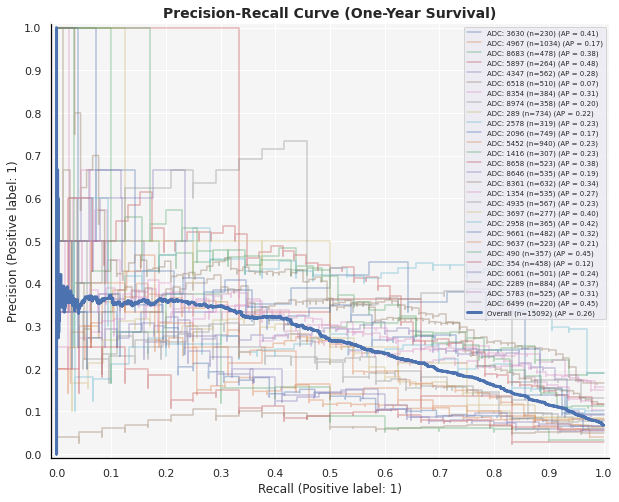

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Precision-Recall Curve (One-Year Survival)', fontdict = {'weight': 'bold', 'size': 18})
plt.plot([0, 0], [1, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('Precision', fontdict={'weight': 'normal', 'size': 14})
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.xlim([-0.01, 1.01])
plt.xlabel('Recall', fontdict={'weight': 'normal', 'size': 14})
plt.xticks(np.arange(0.0, 1.1, step=0.1)) 

for i in range(len(X1_ADC)):
  if i == len(X1_ADC)-1: #for the last ADC (overall)
    PrecisionRecallDisplay.from_estimator(estimator=dec1_opt, X=X1_ADC[i], y=Y1_ADC[i], name = f"Overall (n={len(x_test1_new)})", color='b', lw=3, ax=ax)
  else:
    PrecisionRecallDisplay.from_estimator(estimator=dec1_opt, X=X1_ADC[i], y=Y1_ADC[i], name = NAMES1_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'upper right', prop={'size': 7})
plt.savefig('NACC_Prediction/out/pr_oys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

### TYS

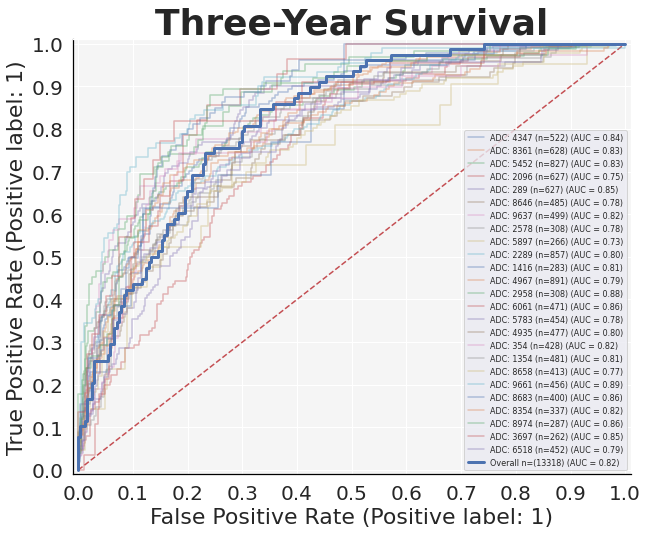

In [ ]:
#TYS
X3_ADC = [x_test3[x_test3['NACCADC'] == adc][feature_subset] for adc in TYS_ADCs]
Y3_ADC = [y_test3[x_test3['NACCADC'] == adc] for adc in TYS_ADCs]
NAMES3_ADC = [f'ADC: {adc} (n={sum(x_test3.NACCADC==adc)})' for adc in TYS_ADCs]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Three-Year Survival', fontdict = {'weight': 'bold', 'size': 36})
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate', fontdict={'weight': 'normal', 'size': 22})
plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=20)
plt.xlim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontdict={'weight': 'normal', 'size': 22})
plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=20) 

for i in range(len(X3_ADC)):
  if i == len(X3_ADC)-1: #for the last ADC (overall)
    RocCurveDisplay.from_estimator(estimator=dec3_opt, X=X3_ADC[i], y=Y3_ADC[i], name = f"Overall n=({len(x_test3_new)})", color='b', lw=3, ax=ax)
  else:
    RocCurveDisplay.from_estimator(estimator=dec3_opt, X=X3_ADC[i], y=Y3_ADC[i], name = NAMES3_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower right', prop={'size': 8})
plt.savefig('NACC_Prediction/out/roc_tys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

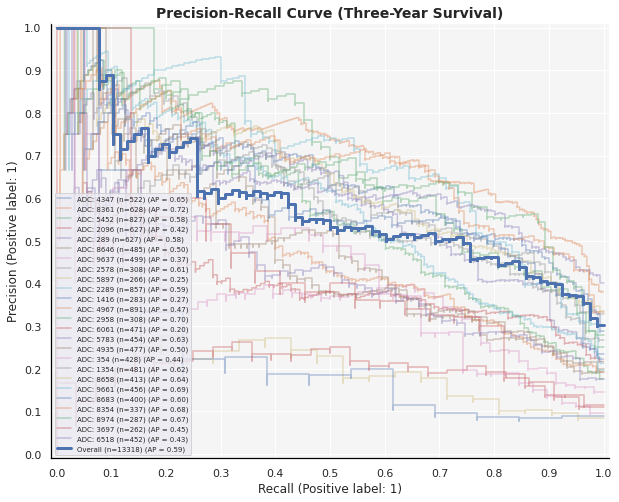

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Precision-Recall Curve (Three-Year Survival)', fontdict = {'weight': 'bold', 'size': 18})
plt.plot([0, 0], [1, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('Precision', fontdict={'weight': 'normal', 'size': 14})
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.xlim([-0.01, 1.01])
plt.xlabel('Recall', fontdict={'weight': 'normal', 'size': 14})
plt.xticks(np.arange(0.0, 1.1, step=0.1)) 

for i in range(len(X3_ADC)):
  if i == len(X3_ADC)-1: #for the last ADC (overall)
    PrecisionRecallDisplay.from_estimator(estimator=dec3_opt, X=X3_ADC[i], y=Y3_ADC[i], name = f"Overall (n={len(x_test3_new)})", color='b', lw=3, ax=ax)
  else:
    PrecisionRecallDisplay.from_estimator(estimator=dec3_opt, X=X3_ADC[i], y=Y3_ADC[i], name = NAMES3_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower left', prop={'size': 7})
plt.savefig('NACC_Prediction/out/pr_tys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

### FYS

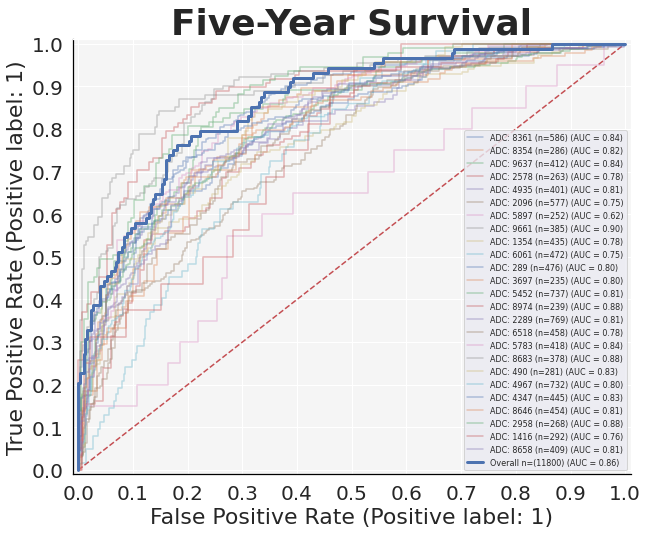

In [ ]:
#FYS
X5_ADC = [x_test5[x_test5['NACCADC'] == adc][feature_subset] for adc in FYS_ADCs]
Y5_ADC = [y_test5[x_test5['NACCADC'] == adc] for adc in FYS_ADCs]
NAMES5_ADC = [f'ADC: {adc} (n={sum(x_test5.NACCADC==adc)})' for adc in FYS_ADCs]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Five-Year Survival', fontdict = {'weight': 'bold', 'size': 36})
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate', fontdict={'weight': 'normal', 'size': 22})
plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=20)
plt.xlim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontdict={'weight': 'normal', 'size': 22})
plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=20) 

for i in range(len(X5_ADC)):
  if i == len(X5_ADC)-1: #for the last ADC (overall)
    RocCurveDisplay.from_estimator(estimator=dec5_opt, X=X5_ADC[i], y=Y5_ADC[i], name = f"Overall n=({len(x_test5_new)})", color='b', lw=3, ax=ax)
  else:
    RocCurveDisplay.from_estimator(estimator=dec5_opt, X=X5_ADC[i], y=Y5_ADC[i], name = NAMES5_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower right', prop={'size': 8})
plt.savefig('NACC_Prediction/out/roc_fys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

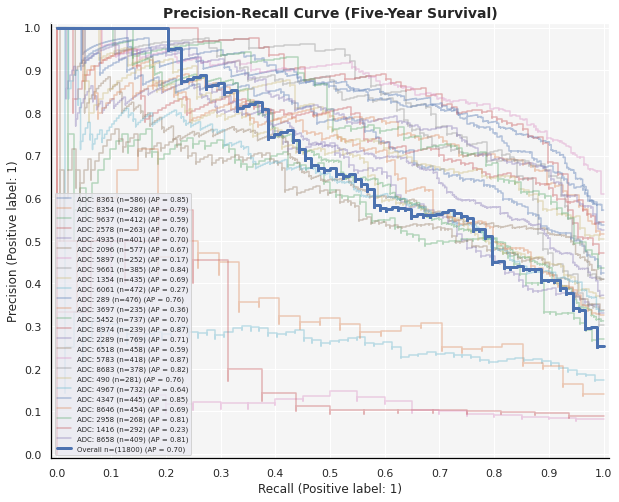

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Precision-Recall Curve (Five-Year Survival)', fontdict = {'weight': 'bold', 'size': 18})
plt.plot([0, 0], [1, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('Precision', fontdict={'weight': 'normal', 'size': 14})
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.xlim([-0.01, 1.01])
plt.xlabel('Recall', fontdict={'weight': 'normal', 'size': 14})
plt.xticks(np.arange(0.0, 1.1, step=0.1)) 

for i in range(len(X5_ADC)):
  if i == len(X5_ADC)-1: #for the last ADC (overall)
    PrecisionRecallDisplay.from_estimator(estimator=dec5_opt, X=X5_ADC[i], y=Y5_ADC[i], name = f"Overall n=({len(x_test5_new)})", color='b', lw=3, ax=ax)
  else:
    PrecisionRecallDisplay.from_estimator(estimator=dec5_opt, X=X5_ADC[i], y=Y5_ADC[i], name = NAMES5_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower left', prop={'size': 7})
plt.savefig('NACC_Prediction/out/pr_fys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

### TenYS

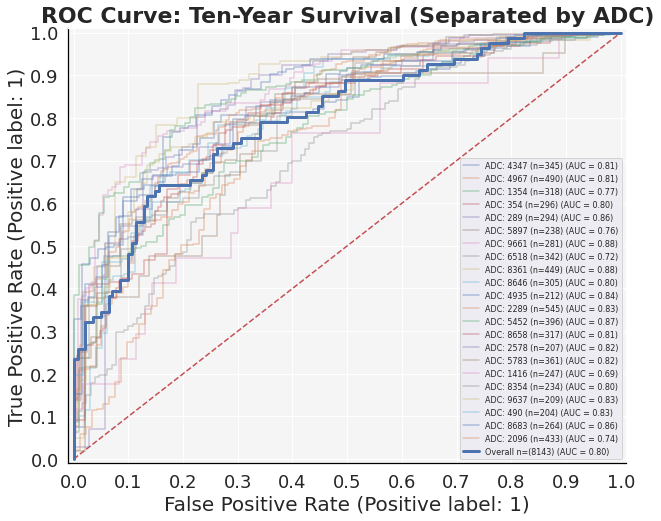

In [ ]:
#TenYS
X10_ADC = [x_test10[x_test10['NACCADC'] == adc][feature_subset] for adc in TenYS_ADCs]
Y10_ADC = [y_test10[x_test10['NACCADC'] == adc] for adc in TenYS_ADCs]
NAMES10_ADC = [f'ADC: {adc} (n={sum(x_test10.NACCADC==adc)})' for adc in TenYS_ADCs]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Ten-Year Survival', fontdict = {'weight': 'bold', 'size': 22})
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate', fontdict={'weight': 'normal', 'size': 20})
plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=18)
plt.xlim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontdict={'weight': 'normal', 'size': 20})
plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=18) 

for i in range(len(X10_ADC)):
  if i == len(X10_ADC)-1: #for the last ADC (overall)
    RocCurveDisplay.from_estimator(estimator=dec10_opt, X=X10_ADC[i], y=Y10_ADC[i], name = f"Overall n=({len(x_test10_new)})", color='b', lw=3, ax=ax)
  else:
    RocCurveDisplay.from_estimator(estimator=dec10_opt, X=X10_ADC[i], y=Y10_ADC[i], name = NAMES10_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower right', prop={'size': 8})
plt.savefig('NACC_Prediction/out/roc_tenys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

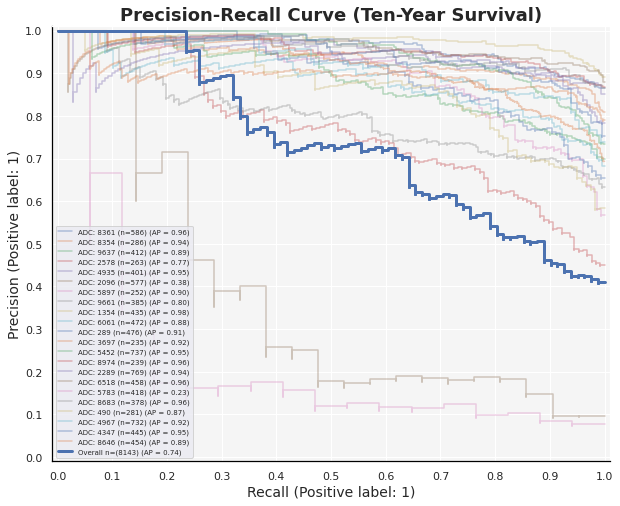

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))

plt.title('Precision-Recall Curve (Ten-Year Survival)', fontdict = {'weight': 'bold', 'size': 18})
plt.plot([0, 0], [1, 1],'r--')
plt.ylim([-0.01, 1.01])
plt.ylabel('Precision', fontdict={'weight': 'normal', 'size': 14})
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.xlim([-0.01, 1.01])
plt.xlabel('Recall', fontdict={'weight': 'normal', 'size': 14})
plt.xticks(np.arange(0.0, 1.1, step=0.1)) 

for i in range(len(X10_ADC)):
  if i == len(X10_ADC)-1: #for the last ADC (overall)
    PrecisionRecallDisplay.from_estimator(estimator=dec10_opt, X=X10_ADC[i], y=Y10_ADC[i], name = f"Overall n=({len(x_test10_new)})", color='b', lw=3, ax=ax)
  else:
    PrecisionRecallDisplay.from_estimator(estimator=dec10_opt, X=X10_ADC[i], y=Y10_ADC[i], name = NAMES5_ADC[i], alpha=0.4, ax=ax)

plt.legend(loc = 'lower left', prop={'size': 7})
plt.savefig('NACC_Prediction/out/pr_tenys_adcs.svg', bbox_inches = 'tight', dpi =300)

plt.show()

# Two-Feature Models (NACCAGE + CDRGLOB)

## One-Year Survival


In [ ]:
#bayesian optimization (OYS)
dec1_age_cdr_opt = bo_tune_xgb(x_train1[['NACCAGE', 'CDRGLOB']], y_train1)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.814    |  0.5337   |  10.46    |  0.1333   |  6.642    |  20.6     |  93.4     |  15.08    |  0.9542   |
|  2        |  0.8139   |  0.4963   |  1.086    |  0.05463  |  3.557    |  24.39    |  165.1    |  15.08    |  0.2052   |
|  3        |  0.8127   |  0.2004   |  2.448    |  0.08099  |  6.734    |  3.55     |  193.8    |  15.08    |  0.3753   |
|  4        |  0.8135   |  0.6474   |  11.71    |  0.03765  |  9.203    |  14.26    |  244.5    |  15.08    |  0.9636   |
|  5        |  0.8137   |  0.6058   |  12.92    |  0.1795   |  6.323    |  12.61    |  290.9    |  15.08    |  0.6558   |
|  6        |  0.8139   |  0.6461   |  14.46    |  0.1535   |  2.269    |  12.39    |  169.9    |  15.08    |  0.4953   |
|  7        |  0.8142   

In [ ]:
dec1_age_cdr_opt = XGBClassifier(**{'colsample_bytree': 1.0, 'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 25, 'n_estimators': 211, 'scale_pos_weight': 15.080713905167821, 'subsample': 1.0})

In [ ]:
dec1_age_cdr_opt.fit(x_train1[['NACCAGE','CDRGLOB']], y_train1)

XGBClassifier(colsample_bytree=1.0, gamma=0.01, learning_rate=0.2, max_depth=2,
              min_child_weight=25, n_estimators=211,
              scale_pos_weight=15.080713905167821, subsample=1.0)

In [ ]:
get_performance_metrics(dec1_age_cdr_opt, x_test1[['NACCAGE', 'CDRGLOB']], y_test1)

Accuracy: 0.7466207262125629
Precision: 0.16923796166432914
Recall/Sensitivity/TPR: 0.7283702213279678
Specificity/1-FPR: 0.7479075046105831
ROC-AUC: 0.8044033458803609
PR-AUC: 0.23972511665445265


In [ ]:
get_performance_metrics(dec1_age_cdr_opt, x_val1[['NACCAGE', 'CDRGLOB']], y_val1)

Accuracy: 0.7852975495915986
Precision: 0.1722354813046937
Recall/Sensitivity/TPR: 0.7732142857142857
Specificity/1-FPR: 0.7859934183463595
ROC-AUC: 0.8533249838396897
PR-AUC: 0.2771005669853501


In [ ]:
boot_1_age_cdr = bootstrap(dec1_age_cdr_opt, feature_one[['NACCAGE', 'CDRGLOB']], target_one, 50)

In [ ]:
#to get 95% CIs
for stat in boot_1_age_cdr.keys():
  print(f'{stat}: {getCI(boot_1_age_cdr[stat], 0.05)}')

accuracy: (0.733012506626027, 0.770635866684336)
precision: (0.15459443864837166, 0.1742858518249527)
sensitivity: (0.7068460539073105, 0.7754091329146303)
specificity: (0.7301370309528628, 0.7742938692704234)
roc_auc: (0.7986582114693879, 0.8235963910472813)
pr_auc: (0.2151857762674669, 0.2639925411289458)


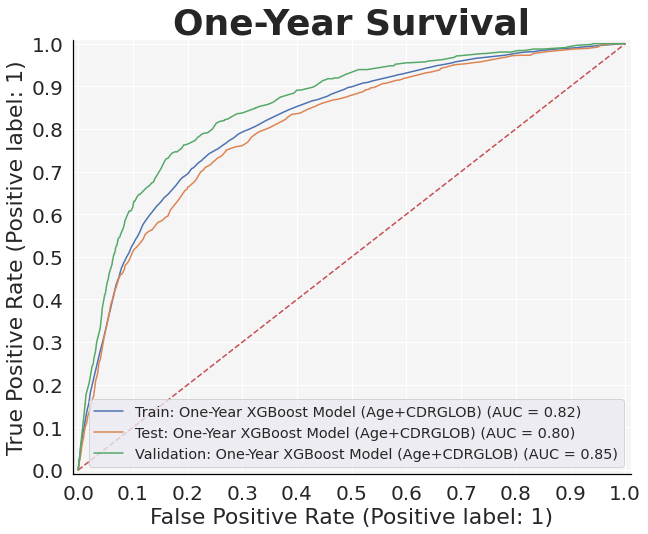

In [ ]:
X1_age_cdr = [x_train1[['NACCAGE', 'CDRGLOB']], x_test1[['NACCAGE', 'CDRGLOB']], x_val1[['NACCAGE', 'CDRGLOB']]]
Y1_age_cdr = [y_train1, y_test1, y_val1]
NAMES1_age_cdr = ['Train: One-Year XGBoost Model (Age+CDRGLOB)', 'Test: One-Year XGBoost Model (Age+CDRGLOB)', 'Validation: One-Year XGBoost Model (Age+CDRGLOB)']
draw_roc_curve(dec1_age_cdr_opt, X1_age_cdr, Y1_age_cdr, NAMES1_age_cdr, title="One-Year Survival", f_name = 'roc_oys_all_dementia_age_cdr.svg', save=True)

## Three-Year Survival


In [ ]:
#bayesian optimization (OYS)
dec3_age_cdr_opt = bo_tune_xgb(x_train3[['NACCAGE', 'CDRGLOB']], y_train3)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7828   |  0.2503   |  7.694    |  0.1969   |  8.15     |  18.36    |  165.4    |  3.862    |  0.777    |
|  2        |  0.7824   |  0.9468   |  2.633    |  0.01073  |  9.874    |  18.9     |  262.2    |  3.862    |  0.6015   |
|  3        |  0.7832   |  0.54     |  2.703    |  0.1558   |  6.554    |  7.511    |  116.2    |  3.862    |  0.7765   |
|  4        |  0.7798   |  0.4899   |  13.66    |  0.01191  |  2.832    |  23.9     |  283.6    |  3.862    |  0.6515   |
|  5        |  0.7829   |  0.6008   |  6.936    |  0.199    |  5.731    |  21.21    |  110.3    |  3.862    |  0.6333   |
|  6        |  0.7829   |  0.6797   |  4.941    |  0.1061   |  9.715    |  23.38    |  141.1    |  3.862    |  0.6175   |
|  7        |  0.7826   

In [ ]:
dec3_age_cdr_opt=XGBClassifier(colsample_bytree=0.7962446402532868, gamma=1.6226798209040185,
              learning_rate=0.14205188664271604, max_depth=2,
              min_child_weight=17, n_estimators=214,
              scale_pos_weight=3.8619147576891484,
              subsample=0.34391922607577385)

In [ ]:
dec3_age_cdr_opt.fit(x_train3[['NACCAGE','CDRGLOB']], y_train3)

XGBClassifier(colsample_bytree=0.7962446402532868, gamma=1.6226798209040185,
              learning_rate=0.14205188664271604, max_depth=2,
              min_child_weight=17, n_estimators=214,
              scale_pos_weight=3.8619147576891484,
              subsample=0.34391922607577385)

In [ ]:
get_performance_metrics(dec3_age_cdr_opt, x_test3[['NACCAGE', 'CDRGLOB']], y_test3)

Accuracy: 0.7442558942784202
Precision: 0.41830367460134044
Recall/Sensitivity/TPR: 0.6706187476843275
Specificity/1-FPR: 0.7629720312647142
ROC-AUC: 0.787001449825983
PR-AUC: 0.4935499648458843


In [ ]:
get_performance_metrics(dec3_age_cdr_opt, x_val3[['NACCAGE', 'CDRGLOB']], y_val3)

Accuracy: 0.7770948753462604
Precision: 0.41473812423873324
Recall/Sensitivity/TPR: 0.6759305210918114
Specificity/1-FPR: 0.7984691202684282
ROC-AUC: 0.8083329885874813
PR-AUC: 0.4816658659531581


In [ ]:
boot_3_age_cdr = bootstrap(dec3_age_cdr_opt, feature_three[['NACCAGE', 'CDRGLOB']], target_three, 50)

In [ ]:
#to get 95% CIs
for stat in boot_3_age_cdr.keys():
  print(f'{stat}: {getCI(boot_3_age_cdr[stat], 0.05)}')

accuracy: (0.7301298806127047, 0.757381288481754)
precision: (0.4037478705977317, 0.44417067298364193)
sensitivity: (0.6494591601116467, 0.7022854415546974)
specificity: (0.7411683424796627, 0.7792329374900447)
roc_auc: (0.7775956966045415, 0.7947556616114947)
pr_auc: (0.47515260507995155, 0.5180030898712548)


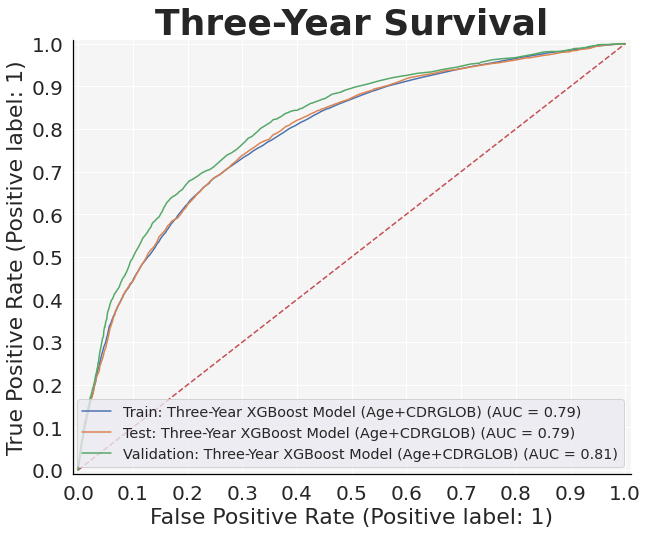

In [ ]:
X3_age_cdr = [x_train3[['NACCAGE', 'CDRGLOB']], x_test3[['NACCAGE', 'CDRGLOB']], x_val3[['NACCAGE', 'CDRGLOB']]]
Y3_age_cdr = [y_train3, y_test3, y_val3]
NAMES3_age_cdr = ['Train: Three-Year XGBoost Model (Age+CDRGLOB)', 'Test: Three-Year XGBoost Model (Age+CDRGLOB)', 'Validation: Three-Year XGBoost Model (Age+CDRGLOB)']
draw_roc_curve(dec3_age_cdr_opt, X3_age_cdr, Y3_age_cdr, NAMES3_age_cdr, title="Three-Year Survival", f_name = 'roc_tys_all_dementia_age_cdr.svg', save=True)

## Five-Year Survival


In [ ]:
#bayesian optimization (OYS)
dec5_age_cdr_opt = bo_tune_xgb(x_train5[['NACCAGE', 'CDRGLOB']], y_train5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7704   |  0.9954   |  13.38    |  0.05873  |  9.005    |  14.93    |  289.9    |  1.872    |  0.7525   |
|  2        |  0.7717   |  0.8703   |  2.244    |  0.08313  |  2.233    |  24.43    |  226.1    |  1.872    |  0.6289   |
|  3        |  0.771    |  0.8214   |  8.259    |  0.1426   |  8.321    |  7.108    |  215.5    |  1.872    |  0.9954   |
|  4        |  0.7715   |  0.3948   |  4.495    |  0.05779  |  4.952    |  7.268    |  70.76    |  1.872    |  0.3747   |
|  5        |  0.7652   |  0.3116   |  4.687    |  0.0187   |  5.161    |  18.13    |  214.7    |  1.872    |  0.7407   |
|  6        |  0.7697   |  0.5348   |  12.42    |  0.1885   |  5.423    |  12.2     |  175.4    |  1.872    |  0.7415   |
|  7        |  0.7714   

In [ ]:
dec5_age_cdr_opt = XGBClassifier(colsample_bytree=0.9125916306382786, gamma=0.5963234304953899,
              learning_rate=0.030451671661596187, max_depth=2,
              min_child_weight=16, n_estimators=146,
              scale_pos_weight=1.8720258017404003,
              subsample=0.3774477625649415)

In [ ]:
dec5_age_cdr_opt.fit(x_train5[['NACCAGE','CDRGLOB']], y_train5)

XGBClassifier(colsample_bytree=0.9125916306382786, gamma=0.5963234304953899,
              learning_rate=0.030451671661596187, max_depth=2,
              min_child_weight=16, n_estimators=146,
              scale_pos_weight=1.8720258017404003,
              subsample=0.3774477625649415)

In [ ]:
get_performance_metrics(dec5_age_cdr_opt, x_test5[['NACCAGE', 'CDRGLOB']], y_test5)

Accuracy: 0.7201694915254238
Precision: 0.5884791621208815
Recall/Sensitivity/TPR: 0.6557257476294676
Specificity/1-FPR: 0.7546507089892025
ROC-AUC: 0.7744562663871429
PR-AUC: 0.6431685464832906


In [ ]:
get_performance_metrics(dec5_age_cdr_opt, x_val5[['NACCAGE', 'CDRGLOB']], y_val5)

Accuracy: 0.7324530308401276
Precision: 0.5388223032829599
Recall/Sensitivity/TPR: 0.623454929152849
Specificity/1-FPR: 0.777833563449228
ROC-AUC: 0.7722299541381488
PR-AUC: 0.5771572533160385


In [ ]:
boot_5_age_cdr = bootstrap(dec5_age_cdr_opt, feature_five[['NACCAGE', 'CDRGLOB']], target_five, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_age_cdr.keys():
  print(f'{stat}: {getCI(boot_5_age_cdr[stat], 0.05)}')

accuracy: (0.7085811228813559, 0.7304845974576272)
precision: (0.5671650784287727, 0.6082402317822958)
sensitivity: (0.634999261440306, 0.6754674460367379)
specificity: (0.7313799402547305, 0.7742903781210391)
roc_auc: (0.7642437774006127, 0.7808318032605261)
pr_auc: (0.628105011597144, 0.6582971810239874)


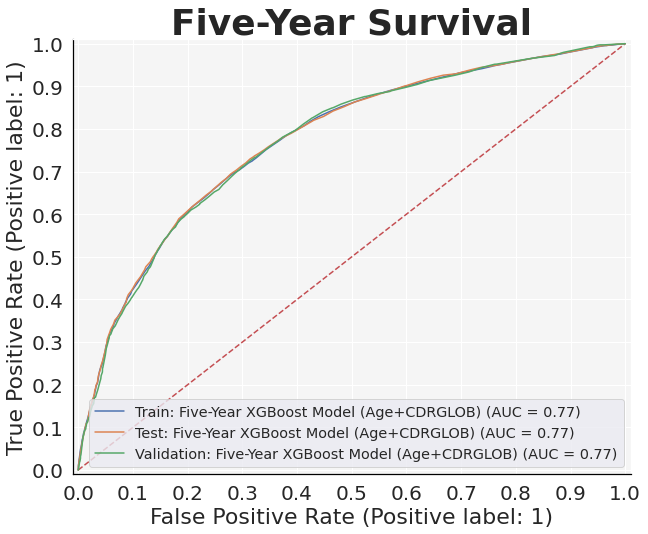

In [ ]:
X5_age_cdr = [x_train5[['NACCAGE', 'CDRGLOB']], x_test5[['NACCAGE', 'CDRGLOB']], x_val5[['NACCAGE', 'CDRGLOB']]]
Y5_age_cdr = [y_train5, y_test5, y_val5]
NAMES5_age_cdr = ['Train: Five-Year XGBoost Model (Age+CDRGLOB)', 'Test: Five-Year XGBoost Model (Age+CDRGLOB)', 'Validation: Five-Year XGBoost Model (Age+CDRGLOB)']
draw_roc_curve(dec5_age_cdr_opt, X5_age_cdr, Y5_age_cdr, NAMES5_age_cdr, title="Five-Year Survival", f_name = 'roc_fys_all_dementia_age_cdr.svg', save=True)

## Ten-Year Survival


In [ ]:
#bayesian optimization (OYS)
dec10_age_cdr_opt = bo_tune_xgb(x_train10[['NACCAGE', 'CDRGLOB']], y_train10)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7519   |  0.3656   |  4.051    |  0.02674  |  7.507    |  8.106    |  78.35    |  0.4755   |  0.6439   |
|  2        |  0.7432   |  0.2951   |  12.14    |  0.02133  |  7.331    |  8.121    |  121.4    |  0.4755   |  0.3954   |
|  3        |  0.7528   |  0.702    |  1.279    |  0.0137   |  7.766    |  22.34    |  79.17    |  0.4755   |  0.2442   |
|  4        |  0.7456   |  0.4346   |  11.92    |  0.1677   |  6.936    |  15.67    |  276.6    |  0.4755   |  0.232    |
|  5        |  0.7481   |  0.9813   |  11.45    |  0.05133  |  3.118    |  15.03    |  226.4    |  0.4755   |  0.5024   |
|  6        |  0.7539   |  0.6939   |  2.369    |  0.1779   |  2.29     |  4.452    |  251.9    |  0.4755   |  0.6645   |
|  7        |  0.7516   

In [ ]:
dec10_age_cdr_opt = XGBClassifier(colsample_bytree=1.0, gamma=0.01,
              learning_rate=0.10634951624144048, max_depth=2,
              min_child_weight=8, n_estimators=234,
              scale_pos_weight=0.47551307026684186, subsample=0.2)

In [ ]:
dec10_age_cdr_opt.fit(x_train10[['NACCAGE','CDRGLOB']], y_train10)

XGBClassifier(colsample_bytree=1.0, gamma=0.01,
              learning_rate=0.10634951624144048, max_depth=2,
              min_child_weight=8, n_estimators=234,
              scale_pos_weight=0.47551307026684186, subsample=0.2)

In [ ]:
get_performance_metrics(dec10_age_cdr_opt, x_test10[['NACCAGE', 'CDRGLOB']], y_test10)

Accuracy: 0.7006017438290556
Precision: 0.8251331203407881
Recall/Sensitivity/TPR: 0.7055181205609179
Specificity/1-FPR: 0.6904223227752639
ROC-AUC: 0.7675303314102633
PR-AUC: 0.8645015929334336


In [ ]:
get_performance_metrics(dec10_age_cdr_opt, x_val10[['NACCAGE', 'CDRGLOB']], y_val10)

Accuracy: 0.6560379918588873
Precision: 0.572937293729373
Recall/Sensitivity/TPR: 0.6374150908757114
Specificity/1-FPR: 0.6690113825297352
ROC-AUC: 0.7140184925165578
PR-AUC: 0.6356146543673387


In [ ]:
boot_10_age_cdr = bootstrap(dec10_age_cdr_opt, feature_ten[['NACCAGE', 'CDRGLOB']], target_ten, 50)

In [ ]:
#to get 95% CIs
for stat in boot_10_age_cdr.keys():
  print(f'{stat}: {getCI(boot_10_age_cdr[stat], 0.05)}')

accuracy: (0.6721952597322854, 0.704991127348643)
precision: (0.8099112305215043, 0.8416447050577882)
sensitivity: (0.6479758968665047, 0.7217490934444519)
specificity: (0.6495249699072926, 0.7249918488593156)
roc_auc: (0.7494967370028455, 0.7696644833914917)
pr_auc: (0.8544315180036848, 0.8748457609137319)


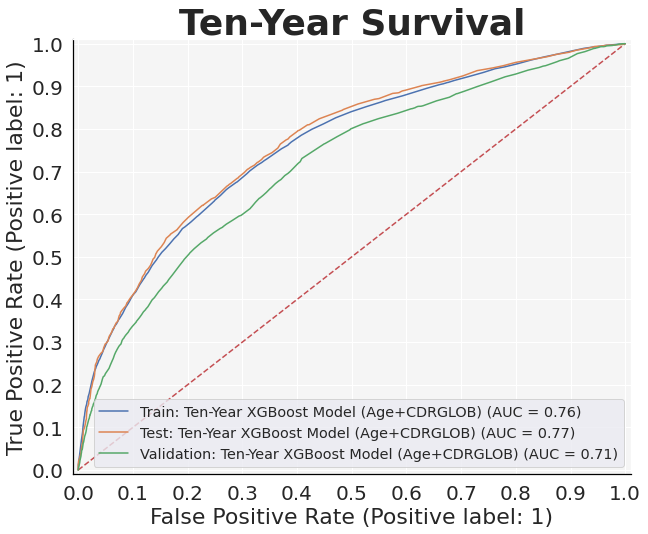

In [ ]:
X10_age_cdr = [x_train10[['NACCAGE', 'CDRGLOB']], x_test10[['NACCAGE', 'CDRGLOB']], x_val10[['NACCAGE', 'CDRGLOB']]]
Y10_age_cdr = [y_train10, y_test10, y_val10]
NAMES10_age_cdr = ['Train: Ten-Year XGBoost Model (Age+CDRGLOB)', 'Test: Ten-Year XGBoost Model (Age+CDRGLOB)', 'Validation: Ten-Year XGBoost Model (Age+CDRGLOB)']
draw_roc_curve(dec10_age_cdr_opt, X10_age_cdr, Y10_age_cdr, NAMES10_age_cdr, title="Ten-Year Survival", f_name = 'roc_tenys_all_dementia_age_cdr.svg', save=True)

# Dementia Subtype Models (FYS)




Focus sub-dementia analysis only on FYS. Include dementia subtypes with at least 1000 patients in the 2019 FYS dataset.

Text(0.5, 1.0, 'Dementia Subtypes')

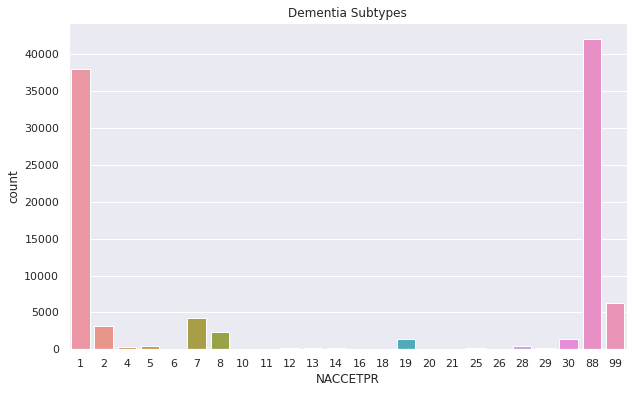

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x=FYS_2019_data.NACCETPR).set_title('Dementia Subtypes')

In [ ]:
#separate FYS dataset into separate datasets by dementia subtype
FYS_2019_data_no_dementia = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 88]
FYS_2019_data_ad = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 1]
FYS_2019_data_unknown = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 99]
FYS_2019_data_ftld = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 7]
FYS_2019_data_lbd = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 2]
FYS_2019_data_vbi = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 8]
FYS_2019_data_other = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 30]
FYS_2019_data_dep = FYS_2019_data.copy()[FYS_2019_data['NACCETPR'] == 19]

#validation set
FYS_2021_data_no_dementia = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 88]
FYS_2021_data_ad = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 1]
FYS_2021_data_unknown = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 99]
FYS_2021_data_ftld = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 7]
FYS_2021_data_lbd = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 2]
FYS_2021_data_vbi = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 8]
FYS_2021_data_other = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 30]
FYS_2021_data_dep = FYS_2021_data.copy()[FYS_2021_data['NACCETPR'] == 19]

## Not applicable, not cognitively impaired

If the subject was not cognitively impaired, then NACCETPR =  88.

In [ ]:
target_five_no_dementia = FYS_2019_data_no_dementia['FYS']
feature_five_no_dementia = FYS_2019_data_no_dementia[FYS_2019_data_no_dementia.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_no_dementia, x_test5_no_dementia, y_train5_no_dementia, y_test5_no_dementia = train_test_split(feature_five_no_dementia, target_five_no_dementia, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val5_no_dementia, y_val5_no_dementia = FYS_2021_data_no_dementia[FYS_2021_data_no_dementia.columns.difference(['FYS'])], FYS_2021_data_no_dementia['FYS']

In [ ]:
#bayesian optimization
dec5_no_dementia_opt = bo_tune_xgb(x_train5_no_dementia, y_train5_no_dementia)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8846   |  0.483    |  0.1536   |  0.01582  |  7.664    |  3.524    |  121.3    |  8.609    |  0.9067   |
|  2        |  0.8642   |  0.537    |  6.792    |  0.07238  |  6.048    |  5.576    |  222.8    |  8.609    |  0.6337   |
|  3        |  0.8576   |  0.81     |  4.884    |  0.125    |  9.295    |  7.345    |  274.5    |  8.609    |  0.3395   |
|  4        |  0.8377   |  0.3144   |  13.03    |  0.06705  |  2.404    |  10.39    |  231.9    |  8.609    |  0.4279   |
|  5        |  0.8607   |  0.4804   |  9.174    |  0.04441  |  7.821    |  7.396    |  155.0    |  8.609    |  0.9642   |
|  6        |  0.8404   |  0.4247   |  14.52    |  0.02391  |  7.909    |  15.36    |  281.2    |  8.609    |  0.377    |
|  7        |  0.8525   

In [ ]:
dec5_no_dementia_opt = XGBClassifier(colsample_bytree=0.2186, 
                                     gamma = 1.009, 
                                     learning_rate = 0.04309, 
                                     max_depth = 10, 
                                     min_child_weight=24, 
                                     n_estimators = 78, 
                                     scale_pos_weight = 8.609, 
                                     subsample = 0.9679)

In [ ]:
dec5_no_dementia_opt.fit(x_train5_no_dementia, y_train5_no_dementia)

XGBClassifier(colsample_bytree=0.2186, gamma=1.009, learning_rate=0.04309,
              max_depth=10, min_child_weight=24, n_estimators=78,
              scale_pos_weight=8.609, subsample=0.9679)

In [ ]:
get_performance_metrics(dec5_no_dementia_opt, x_test5_no_dementia, y_test5_no_dementia)

Accuracy: 0.8341046635813457
Precision: 0.3509933774834437
Recall/Sensitivity/TPR: 0.7412587412587412
Specificity/1-FPR: 0.8446294094332144
ROC-AUC: 0.8728815334047201
PR-AUC: 0.5132835091973951


In [ ]:
get_performance_metrics(dec5_no_dementia_opt, x_val5_no_dementia, y_val5_no_dementia)

Accuracy: 0.6958474576271186
Precision: 0.15422276621787026
Recall/Sensitivity/TPR: 0.824607329842932
Specificity/1-FPR: 0.6869336716201522
ROC-AUC: 0.8422567314206338
PR-AUC: 0.3356429690509391


In [ ]:
boot_5_no_dementia = bootstrap(dec5_no_dementia_opt, feature_five_no_dementia, target_five_no_dementia, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_no_dementia.keys():
  print(f'{stat}: {getCI(boot_5_no_dementia[stat], 0.05)}')

accuracy: (0.8273465052806456, 0.8444097246944345)
precision: (0.33202662808388295, 0.37695734285702537)
sensitivity: (0.6837538693496017, 0.7412560673430615)
specificity: (0.8405228462451302, 0.8587522367938465)
roc_auc: (0.858557405747505, 0.8794328317532654)
pr_auc: (0.4749111999581236, 0.5455506044388774)


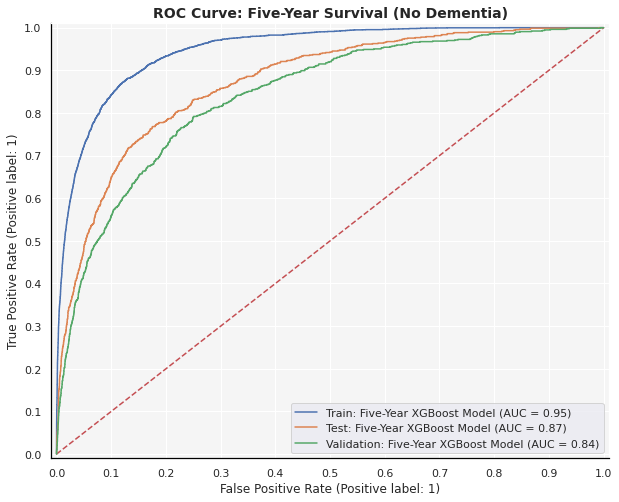

In [ ]:
X5_no_dementia = [x_train5_no_dementia, x_test5_no_dementia, x_val5_no_dementia]
Y5_no_dementia = [y_train5_no_dementia, y_test5_no_dementia, y_val5_no_dementia]
NAMES5_no_dementia = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_no_dementia_opt, X5_no_dementia, Y5_no_dementia, NAMES5_no_dementia, title="ROC Curve: Five-Year Survival (No Dementia)")

No handles with labels found to put in legend.


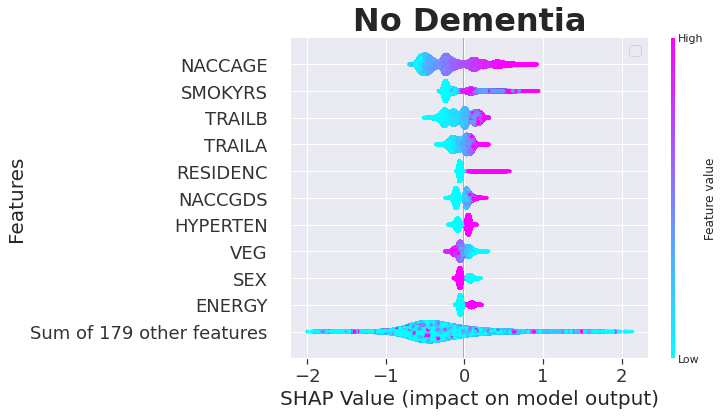

In [ ]:
#bootstrap SHAP plot
shap_exp_no_dementia = shapPlotBoot(dec5_no_dementia_opt, feature_five_no_dementia, target_five_no_dementia, 50, 10, "beeswarm", title="No Dementia", f_name="shap_no_dementia.svg", save=True)

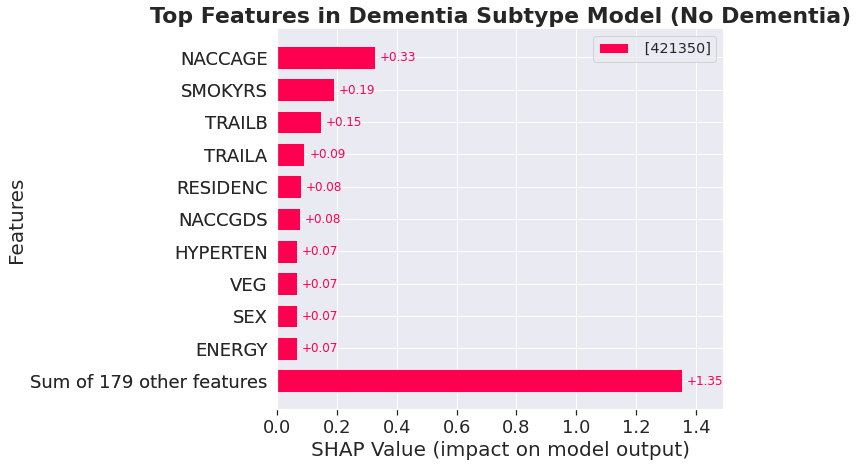

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_no_dementia = shapPlotBoot(dec5_no_dementia_opt, feature_five_no_dementia, target_five_no_dementia, 50, 10, "bar", title="Top Features in Dementia Subtype Model (No Dementia)")

In [ ]:
shap_no_dementia_df = create_shap_df(FEATURES, shap_exp_no_dementia.values)

In [ ]:
shap_no_dementia_df[:20]

Feature  Mean Absolute SHAP Value  Relative SHAP Value
112   NACCAGE                  0.325818             0.129023
165   SMOKYRS                  0.190689             0.075512
177    TRAILB                  0.145510             0.057621
174    TRAILA                  0.091661             0.036298
160  RESIDENC                  0.078597             0.031124
123   NACCGDS                  0.075043             0.029717
87   HYPERTEN                  0.067335             0.026664
184       VEG                  0.067151             0.026592
163       SEX                  0.065056             0.025762
72     ENERGY                  0.065037             0.025754
94   MARISTAT                  0.053230             0.021079
48     CVAFIB                  0.052267             0.020698
110   NACCADC                  0.049282             0.019516
144  NPSYCLOC                  0.046706             0.018495
120   NACCFAM                  0.045717             0.018104
116   NACCBMI                  0.045306             0.017941
83      HRATE                  0.042486             0.016824
172  TOBAC100                  0.041807             0.016555
185    WEIGHT                  0.038865             0.015390
90    INCONTU                  0.037434             0.014824

## Alzheimer’s disease (AD)

In [ ]:
target_five_ad = FYS_2019_data_ad['FYS']
feature_five_ad = FYS_2019_data_ad[FYS_2019_data_ad.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_ad, x_test5_ad, y_train5_ad, y_test5_ad = train_test_split(feature_five_ad, target_five_ad, test_size= 0.2, random_state=88)

#use 2021 data as validation set
x_val5_ad, y_val5_ad = FYS_2021_data_ad[FYS_2021_data_ad.columns.difference(['FYS'])], FYS_2021_data_ad['FYS']

In [ ]:
#bayesian optimization
dec5_ad_opt = bo_tune_xgb(x_train5_ad, y_train5_ad)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8317   |  0.3231   |  0.4395   |  0.0953   |  14.45    |  2.796    |  237.5    |  0.3364   |
|  2        |  0.8347   |  0.2909   |  0.3537   |  0.1817   |  4.781    |  6.274    |  193.0    |  0.2765   |
|  3        |  0.8376   |  0.2717   |  0.2605   |  0.0824   |  9.85     |  3.307    |  86.29    |  0.3016   |
|  4        |  0.8616   |  0.2308   |  0.3471   |  0.07561  |  10.12    |  8.126    |  107.4    |  0.8939   |
|  5        |  0.7995   |  0.2887   |  0.2249   |  0.1999   |  14.66    |  3.458    |  167.8    |  0.3773   |
|  6        |  0.812    |  0.6741   |  0.06212  |  0.1631   |  17.13    |  6.595    |  176.3    |  0.3841   |
|  7        |  0.8238   |  0.471    |  0.8168   |  0.1814   |  14.08    |  4.884    |  196.0    |  0.4479   |
|  8      

In [ ]:
dec5_ad_opt = XGBClassifier(**{'colsample_bytree': 0.5611037669784689, 
                               'gamma': 0.1630861957353944, 
                               'learning_rate': 0.06534236938787352, 
                               'max_depth': 7, 
                               'min_child_weight': 9, 
                               'n_estimators': 107, 
                               'subsample': 0.9139442444839396, 
                               'scale_pos_weight': 1.7484174353409296})

In [ ]:
dec5_ad_opt.fit(x_train5_ad, y_train5_ad)

XGBClassifier(colsample_bytree=0.5611037669784689, gamma=0.1630861957353944,
              learning_rate=0.06534236938787352, max_depth=7,
              min_child_weight=9, n_estimators=107,
              scale_pos_weight=1.7484174353409296,
              subsample=0.9139442444839396)

In [ ]:
get_performance_metrics(dec5_ad_opt, x_test5_ad, y_test5_ad)

Accuracy: 0.7741510923927349
Precision: 0.6745466321243523
Recall/Sensitivity/TPR: 0.7455261274158912
Specificity/1-FPR: 0.7907993338884263
ROC-AUC: 0.8539191198339251
PR-AUC: 0.7902285027744721


In [ ]:
get_performance_metrics(dec5_ad_opt, x_val5_ad, y_val5_ad)

Accuracy: 0.6829002856754183
Precision: 0.490041928721174
Recall/Sensitivity/TPR: 0.8292682926829268
Specificity/1-FPR: 0.6181318681318682
ROC-AUC: 0.8268560707585098
PR-AUC: 0.6950802967857912


In [ ]:
boot_5_ad = bootstrap(dec5_ad_opt, feature_five_ad, target_five_ad, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_ad.keys():
  print(f'{stat}: {getCI(boot_5_ad[stat], 0.05)}')

accuracy: (0.7661226638589103, 0.7834892076862333)
precision: (0.6463052742478443, 0.6873848730429102)
sensitivity: (0.7375657605007765, 0.7734933392707128)
specificity: (0.7712635894910521, 0.8000945830030978)
roc_auc: (0.8451927914235606, 0.8627714873595165)
pr_auc: (0.7690651580578679, 0.8051637258005221)


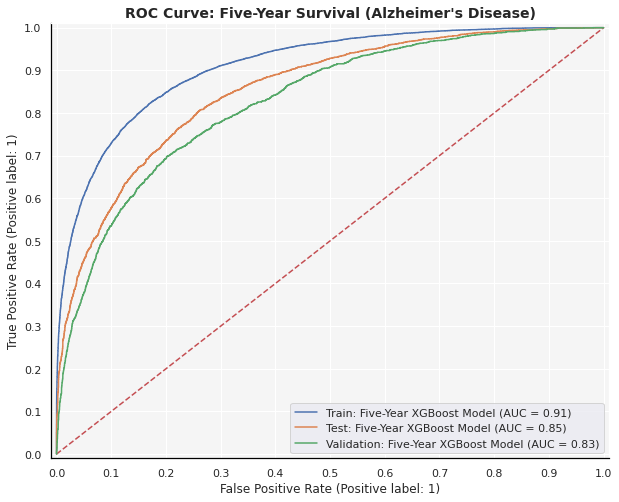

In [ ]:
X5_ad = [x_train5_ad, x_test5_ad, x_val5_ad]
Y5_ad = [y_train5_ad, y_test5_ad, y_val5_ad]
NAMES5_ad = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_ad_opt, X5_ad, Y5_ad, NAMES5_ad, title="ROC Curve: Five-Year Survival (Alzheimer's Disease)")

No handles with labels found to put in legend.


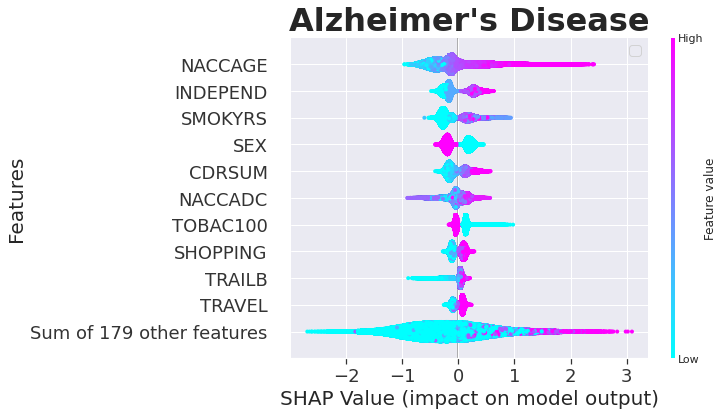

In [ ]:
#bootstrap SHAP plot
shap_exp_ad = shapPlotBoot(dec5_ad_opt, feature_five_ad, target_five_ad, 50, 10, "beeswarm", title="Alzheimer's Disease", f_name="shap_ad.svg", save=True)

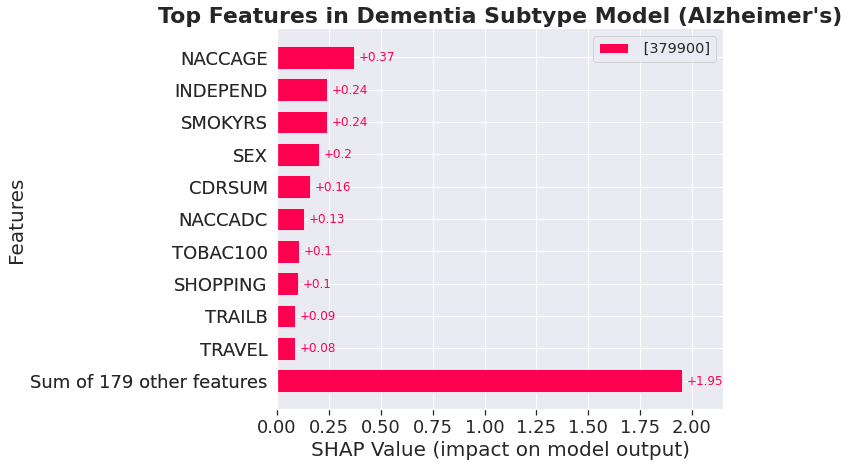

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_ad = shapPlotBoot(dec5_ad_opt, feature_five_ad, target_five_ad, 50, 10, "bar", title="Top Features in Dementia Subtype Model (Alzheimer's)")

In [ ]:
shap_ad_df = create_shap_df(FEATURES, shap_exp_ad.values)

In [ ]:
shap_ad_df

Feature  Mean Absolute SHAP Value  Relative SHAP Value
112   NACCAGE                  0.371579             0.101130
91   INDEPEND                  0.241285             0.065669
165   SMOKYRS                  0.240134             0.065356
163       SEX                  0.203516             0.055390
32     CDRSUM                  0.158343             0.043095
..        ...                       ...                  ...
41    COGOTH3                  0.000000             0.000000
155     PRION                  0.000000             0.000000
119  NACCETPR                  0.000000             0.000000
84       HUNT                  0.000000             0.000000
114  NACCAPSA                  0.000000             0.000000

[189 rows x 3 columns]

## Missing/unknown

If the subject was cognitively impaired but does not have an etiologic diagnosis, then NACCETPR = 99.

In [ ]:
target_five_unknown = FYS_2019_data_unknown['FYS']
feature_five_unknown = FYS_2019_data_unknown[FYS_2019_data_unknown.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_unknown, x_test5_unknown, y_train5_unknown, y_test5_unknown = train_test_split(feature_five_unknown, target_five_unknown, test_size= 0.2, random_state=88)

#use 2021 data as validation set
x_val5_unknown, y_val5_unknown = FYS_2021_data_unknown[FYS_2021_data_unknown.columns.difference(['FYS'])], FYS_2021_data_unknown['FYS']

In [ ]:
#bayesian optimization
dec5_unknown_opt = bo_tune_xgb(x_train5_unknown, y_train5_unknown)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8243   |  0.3334   |  8.134    |  0.07631  |  6.766    |  4.999    |  260.4    |  6.715    |  0.6873   |
|  2        |  0.7807   |  0.7502   |  4.907    |  0.1978   |  9.091    |  13.26    |  158.4    |  6.715    |  0.2211   |
|  3        |  0.8319   |  0.6389   |  1.816    |  0.05321  |  4.957    |  18.44    |  73.53    |  6.715    |  0.968    |
|  4        |  0.8197   |  0.5989   |  6.095    |  0.05818  |  8.923    |  4.142    |  233.8    |  6.715    |  0.2142   |
|  5        |  0.8333   |  0.6505   |  1.64     |  0.05376  |  3.727    |  13.41    |  214.5    |  6.715    |  0.8382   |
|  6        |  0.8171   |  0.7267   |  7.43     |  0.176    |  6.893    |  5.561    |  162.8    |  6.715    |  0.7227   |
|  7        |  0.8027   

In [ ]:
dec5_unknown_opt = XGBClassifier(**{'colsample_bytree': 0.6504823455636677, 
                                    'gamma': 1.6399092410917497, 
                                    'learning_rate': 0.05375558337676697, 
                                    'max_depth': 3, 
                                    'min_child_weight': 13, 
                                    'n_estimators': 214, 
                                    'scale_pos_weight': 6.7145038167938935, 
                                    'subsample': 0.8382441050883598})

In [ ]:
dec5_unknown_opt.fit(x_train5_unknown, y_train5_unknown)

XGBClassifier(colsample_bytree=0.6504823455636677, gamma=1.6399092410917497,
              learning_rate=0.05375558337676697, min_child_weight=13,
              n_estimators=214, scale_pos_weight=6.7145038167938935,
              subsample=0.8382441050883598)

In [ ]:
get_performance_metrics(dec5_unknown_opt, x_test5_unknown, y_test5_unknown)

Accuracy: 0.807753164556962
Precision: 0.37142857142857144
Recall/Sensitivity/TPR: 0.7222222222222222
Specificity/1-FPR: 0.8203266787658802
ROC-AUC: 0.861525621204992
PR-AUC: 0.5042868197786675


In [ ]:
get_performance_metrics(dec5_unknown_opt, x_val5_unknown, y_val5_unknown)

Accuracy: 0.837696335078534
Precision: 0.03225806451612903
Recall/Sensitivity/TPR: 0.5
Specificity/1-FPR: 0.8412698412698413
ROC-AUC: 0.7936507936507936
PR-AUC: 0.2626582278481013


In [ ]:
boot_5_unknown = bootstrap(dec5_unknown_opt, feature_five_unknown, target_five_unknown, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_unknown.keys():
  print(f'{stat}: {getCI(boot_5_unknown[stat], 0.05)}')

accuracy: (0.7729818037974684, 0.8338123022151899)
precision: (0.312746505665371, 0.43955929225237)
sensitivity: (0.6085446293370202, 0.7698902543409145)
specificity: (0.7874841109120168, 0.8626883818820891)
roc_auc: (0.8132203040980706, 0.8866835374663872)
pr_auc: (0.47668947288926095, 0.6290599331226681)


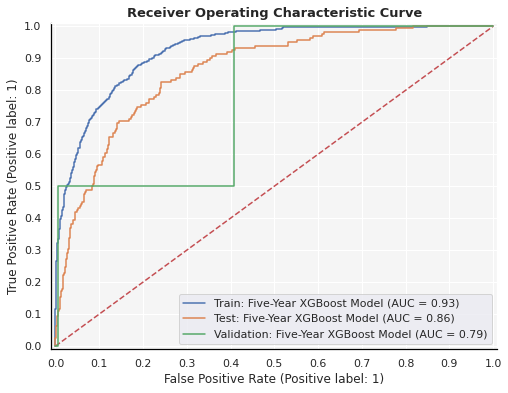

In [ ]:
X5_unknown = [x_train5_unknown, x_test5_unknown, x_val5_unknown]
Y5_unknown = [y_train5_unknown, y_test5_unknown, y_val5_unknown]
NAMES5_unknown = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_unknown_opt, X5_unknown, Y5_unknown, NAMES5_unknown)

No handles with labels found to put in legend.


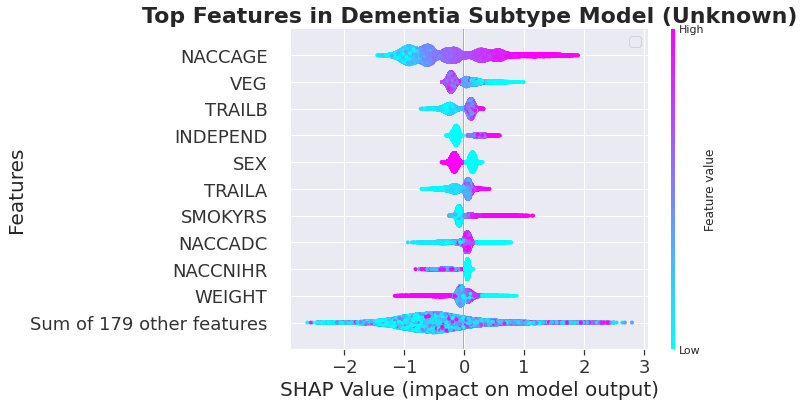

In [ ]:
#bootstrap SHAP plot
shap_exp_unknown = shapPlotBoot(dec5_unknown_opt, feature_five_unknown, target_five_unknown, 50, 10, "beeswarm", title="Top Features in Dementia Subtype Model (Unknown)", f_name="shap_unknown.svg", save=True)

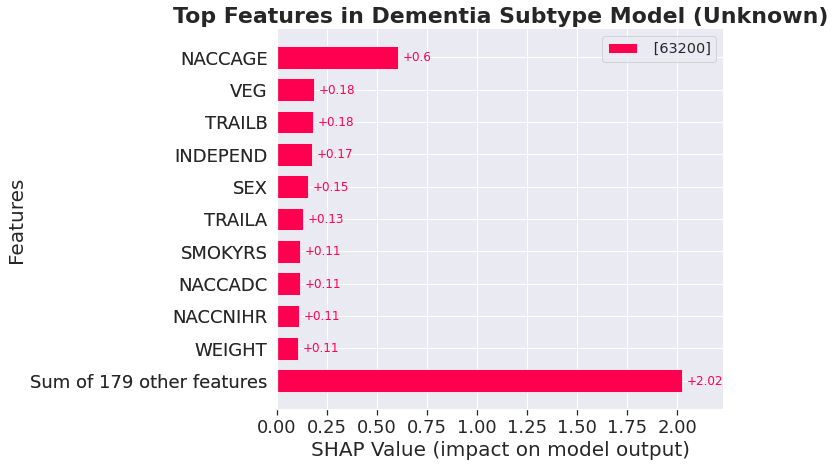

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_unknown = shapPlotBoot(dec5_unknown_opt, feature_five_unknown, target_five_unknown, 50, 10, "bar", title="Top Features in Dementia Subtype Model (Unknown)")

In [ ]:
shap_unknown_df = create_shap_df(FEATURES, shap_exp_unknown.values)

In [ ]:
shap_unknown_df

Feature  Mean Absolute SHAP Value  Relative SHAP Value
112   NACCAGE                  0.604633             0.155370
184       VEG                  0.183993             0.047280
177    TRAILB                  0.181672             0.046683
91   INDEPEND                  0.173458             0.044573
163       SEX                  0.154357             0.039665
..        ...                       ...                  ...
140      NEOP                  0.000000             0.000000
143   NORMCOG                  0.000000             0.000000
149      PARK                  0.000000             0.000000
155     PRION                  0.000000             0.000000
0    ABUSOTHR                  0.000000             0.000000

[189 rows x 3 columns]

## FTLD, other 

Subjects completing visits using v1.2 or v2 of the UDS who had bvFTD or PPA indicated as their primary etiologic diagnosis will have NACCETPR =  7.

In [ ]:
target_five_ftld = FYS_2019_data_ftld['FYS']
feature_five_ftld = FYS_2019_data_ftld[FYS_2019_data_ftld.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_ftld, x_test5_ftld, y_train5_ftld, y_test5_ftld = train_test_split(feature_five_ftld, target_five_ftld, test_size= 0.2, random_state=88)

#use 2021 data as validation set
x_val5_ftld, y_val5_ftld = FYS_2021_data_ftld[FYS_2021_data_ftld.columns.difference(['FYS'])], FYS_2021_data_ftld['FYS']

In [ ]:
dec5_ftld_opt = bo_tune_xgb(x_train5_ftld, y_train5_ftld)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7742   |  0.4904   |  1.231    |  0.1656   |  5.957    |  24.24    |  214.9    |  1.061    |  0.257    |
|  2        |  0.7519   |  0.3171   |  14.5     |  0.1282   |  9.168    |  23.84    |  89.95    |  1.061    |  0.5891   |
|  3        |  0.7613   |  0.9215   |  6.693    |  0.1385   |  6.201    |  17.47    |  100.7    |  1.061    |  0.5158   |
|  4        |  0.7484   |  0.4796   |  10.74    |  0.1945   |  3.408    |  18.99    |  143.5    |  1.061    |  0.2761   |
|  5        |  0.7762   |  0.8535   |  3.031    |  0.1625   |  3.361    |  7.053    |  293.0    |  1.061    |  0.5083   |
|  6        |  0.7942   |  0.4079   |  2.127    |  0.1421   |  7.692    |  18.73    |  146.3    |  1.061    |  0.5583   |
|  7        |  0.7716   

In [ ]:
dec5_ftld_opt = XGBClassifier(**{'colsample_bytree': 0.2, 
                                 'gamma': 0.01, 
                                 'learning_rate': 0.01, 
                                 'max_depth': 10, 
                                 'min_child_weight': 8, 
                                 'n_estimators': 149, 
                                 'scale_pos_weight': 1.0612612612612613, 
                                 'subsample': 1.0})

In [ ]:
dec5_ftld_opt.fit(x_train5_ftld, y_train5_ftld)

XGBClassifier(colsample_bytree=0.2, gamma=0.01, learning_rate=0.01,
              max_depth=10, min_child_weight=8, n_estimators=149,
              scale_pos_weight=1.0612612612612613, subsample=1.0)

In [ ]:
get_performance_metrics(dec5_ftld_opt, x_test5_ftld, y_test5_ftld)

Accuracy: 0.7144522144522144
Precision: 0.7319587628865979
Recall/Sensitivity/TPR: 0.668235294117647
Specificity/1-FPR: 0.7598152424942263
ROC-AUC: 0.7962342073087896
PR-AUC: 0.8104127146830784


In [ ]:
get_performance_metrics(dec5_ftld_opt, x_val5_ftld, y_val5_ftld)

Accuracy: 0.6947069943289225
Precision: 0.5413870246085011
Recall/Sensitivity/TPR: 0.6722222222222223
Specificity/1-FPR: 0.7063037249283668
ROC-AUC: 0.7720113021330787
PR-AUC: 0.6766532127853075


In [ ]:
boot_5_ftld = bootstrap(dec5_ftld_opt, feature_five_ftld, target_five_ftld, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_ftld.keys():
  print(f'{stat}: {getCI(boot_5_ftld[stat], 0.05)}')

accuracy: (0.682983682983683, 0.7446695804195804)
precision: (0.638208862203418, 0.7579889853001225)
sensitivity: (0.6212106934941316, 0.7194314243202241)
specificity: (0.7030835471873547, 0.7817717386873216)
roc_auc: (0.759821045300825, 0.8206139514586014)
pr_auc: (0.7351725961276684, 0.819275333376648)


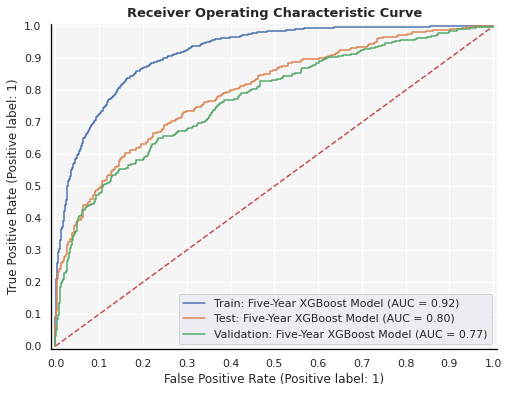

In [ ]:
X5_ftld = [x_train5_ftld, x_test5_ftld, x_val5_ftld]
Y5_ftld = [y_train5_ftld, y_test5_ftld, y_val5_ftld]
NAMES5_ftld = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_ftld_opt, X5_ftld, Y5_ftld, NAMES5_ftld)

No handles with labels found to put in legend.


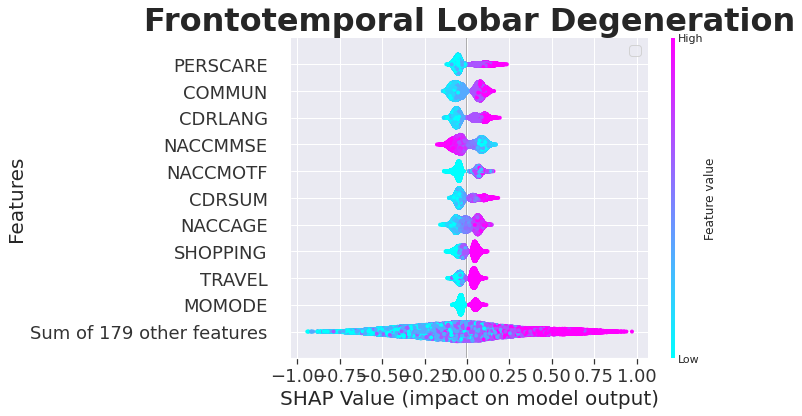

In [ ]:
#bootstrap SHAP plot
shap_exp_ftld = shapPlotBoot(dec5_ftld_opt, feature_five_ftld, target_five_ftld, 50, 10, "beeswarm", title="Frontotemporal Lobar Degeneration", f_name="shap_ftld.svg", save=True)

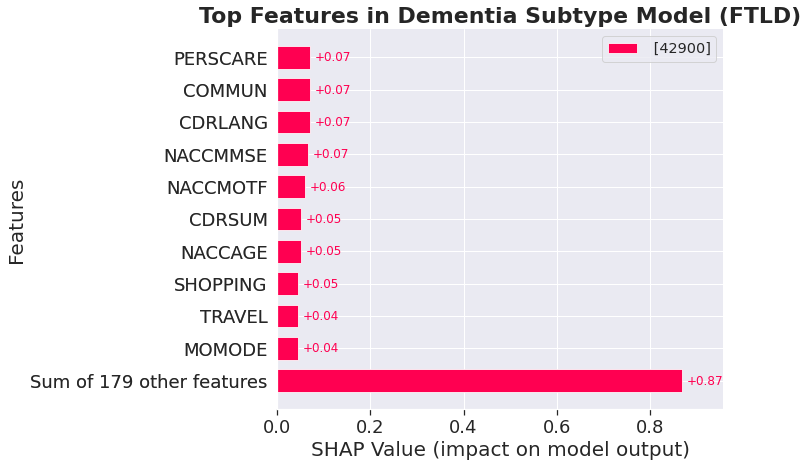

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_ftld = shapPlotBoot(dec5_ftld_opt, feature_five_ftld, target_five_ftld, 50, 10, "bar", title="Top Features in Dementia Subtype Model (FTLD)")

In [ ]:
shap_ftld_df = create_shap_df(FEATURES, shap_exp_ftld.values)

In [ ]:
shap_ftld_df[:20]

Feature  Mean Absolute SHAP Value  Relative SHAP Value
153  PERSCARE                  0.071383             0.049433
45     COMMUN                  0.070332             0.048705
31    CDRLANG                  0.070268             0.048661
126  NACCMMSE                  0.065587             0.045419
127  NACCMOTF                  0.060426             0.041845
32     CDRSUM                  0.052067             0.036056
112   NACCAGE                  0.050463             0.034945
164  SHOPPING                  0.045620             0.031592
183    TRAVEL                  0.044922             0.031109
105    MOMODE                  0.044589             0.030878
91   INDEPEND                  0.041208             0.028537
177    TRAILB                  0.039537             0.027379
106    MOSLOW                  0.037481             0.025956
165   SMOKYRS                  0.032145             0.022260
5     ANIMALS                  0.029560             0.020470
168     STOVE                  0.028733             0.019898
179  TRAILBRR                  0.024611             0.017043
30    CDRGLOB                  0.022558             0.015621
104    MOGAIT                  0.021505             0.014892
185    WEIGHT                  0.020499             0.014196

## Lewy body dementia (LBD)

In [ ]:
target_five_lbd = FYS_2019_data_lbd['FYS']
feature_five_lbd = FYS_2019_data_lbd[FYS_2019_data_lbd.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_lbd, x_test5_lbd, y_train5_lbd, y_test5_lbd = train_test_split(feature_five_lbd, target_five_lbd, test_size= 0.2, random_state=88)

#use 2021 data as validation set
x_val5_lbd, y_val5_lbd = FYS_2021_data_lbd[FYS_2021_data_lbd.columns.difference(['FYS'])], FYS_2021_data_lbd['FYS']

In [ ]:
dec5_lbd_opt = bo_tune_xgb(x_train5_lbd, y_train5_lbd)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7799   |  0.264    |  9.713    |  0.06726  |  7.771    |  15.29    |  79.05    |  1.038    |  0.3086   |
|  2        |  0.7886   |  0.2454   |  7.551    |  0.09848  |  8.863    |  9.156    |  268.8    |  1.038    |  0.4698   |
|  3        |  0.8255   |  0.7512   |  2.681    |  0.1146   |  7.629    |  23.95    |  169.4    |  1.038    |  0.5084   |
|  4        |  0.7778   |  0.764    |  11.36    |  0.1018   |  4.979    |  11.15    |  224.3    |  1.038    |  0.4395   |
|  5        |  0.7929   |  0.6419   |  4.523    |  0.1184   |  3.557    |  15.08    |  123.5    |  1.038    |  0.268    |
|  6        |  0.7653   |  0.894    |  11.84    |  0.09807  |  5.84     |  17.59    |  60.02    |  1.038    |  0.2037   |
|  7        |  0.8319   

In [ ]:
dec5_lbd_opt = XGBClassifier(**{'colsample_bytree': 0.2, 
                                'gamma': 0.01, 
                                'learning_rate': 0.01, 
                                'max_depth': 10, 
                                'min_child_weight': 25, 
                                'n_estimators': 141, 
                                'scale_pos_weight': 1.0376301040832665, 
                                'subsample': 1.0})

In [ ]:
dec5_lbd_opt.fit(x_train5_lbd, y_train5_lbd)

XGBClassifier(colsample_bytree=0.2, gamma=0.01, learning_rate=0.01,
              max_depth=10, min_child_weight=25, n_estimators=141,
              scale_pos_weight=1.0376301040832665, subsample=1.0)

In [ ]:
get_performance_metrics(dec5_lbd_opt, x_test5_lbd, y_test5_lbd)

Accuracy: 0.7189952904238619
Precision: 0.7105263157894737
Recall/Sensitivity/TPR: 0.7523219814241486
Specificity/1-FPR: 0.6847133757961783
ROC-AUC: 0.7964445583798386
PR-AUC: 0.8055005903722559


In [ ]:
get_performance_metrics(dec5_lbd_opt, x_val5_lbd, y_val5_lbd)

Accuracy: 0.7165775401069518
Precision: 0.6705426356589147
Recall/Sensitivity/TPR: 0.7004048582995951
Specificity/1-FPR: 0.7292993630573248
ROC-AUC: 0.8069057995306739
PR-AUC: 0.7630221425494672


In [ ]:
boot_5_lbd = bootstrap(dec5_lbd_opt, feature_five_lbd, target_five_lbd, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_lbd.keys():
  print(f'{stat}: {getCI(boot_5_lbd[stat], 0.05)}')

accuracy: (0.6955051020408163, 0.7690961538461538)
precision: (0.6827868812092168, 0.7701808291108205)
sensitivity: (0.6863657684726695, 0.7883809047496128)
specificity: (0.6699045191722459, 0.7829000056831098)
roc_auc: (0.7797405636660905, 0.8420473319078845)
pr_auc: (0.7710773643504079, 0.8455644284151008)


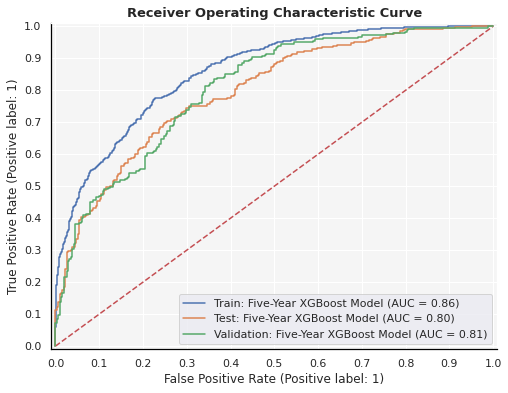

In [ ]:
X5_lbd = [x_train5_lbd, x_test5_lbd, x_val5_lbd]
Y5_lbd = [y_train5_lbd, y_test5_lbd, y_val5_lbd]
NAMES5_lbd = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_lbd_opt, X5_lbd, Y5_lbd, NAMES5_lbd)

No handles with labels found to put in legend.


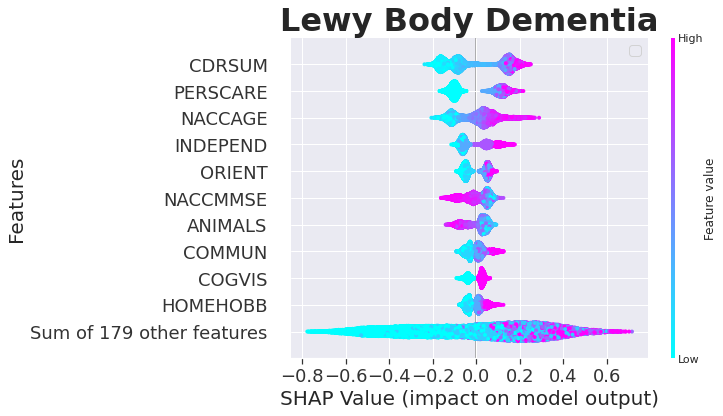

In [ ]:
#bootstrap SHAP plot
shap_exp_lbd = shapPlotBoot(dec5_lbd_opt, feature_five_lbd, target_five_lbd, 50, 10, "beeswarm", title="Lewy Body Dementia", f_name="shap_lbd.svg", save=True)

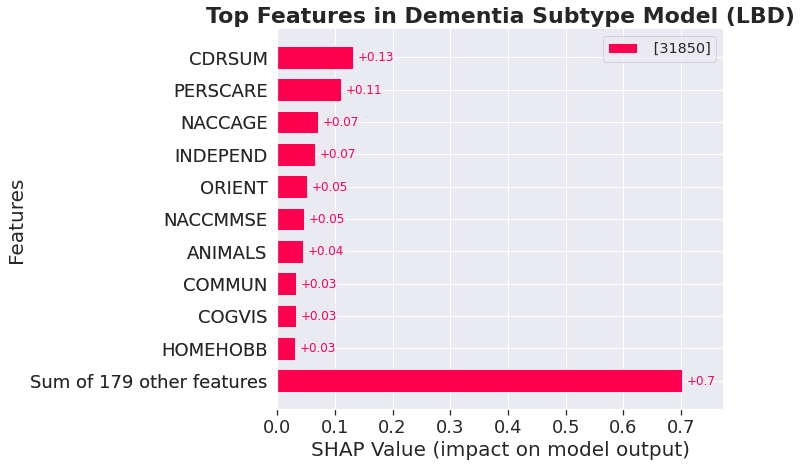

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_lbd = shapPlotBoot(dec5_lbd_opt, feature_five_lbd, target_five_lbd, 50, 10, "bar", title="Top Features in Dementia Subtype Model (LBD)")

In [ ]:
shap_lbd_df = create_shap_df(FEATURES, shap_exp_lbd.values)

In [ ]:
shap_lbd_df

Feature  Mean Absolute SHAP Value  Relative SHAP Value
32     CDRSUM                  0.131075             0.099296
153  PERSCARE                  0.110002             0.083332
112   NACCAGE                  0.070973             0.053766
91   INDEPEND                  0.066525             0.050396
146    ORIENT                  0.051182             0.038773
..        ...                       ...                  ...
66      DOWNS                  0.000000             0.000000
147    OTHPSY                  0.000000             0.000000
109  NACCACSF                  0.000000             0.000000
55    DECCLIN                  0.000000             0.000000
0    ABUSOTHR                  0.000000             0.000000

[189 rows x 3 columns]

## Vascular brain injury or vascular dementia including stroke

For the purpose of this variable, subjects reported as having either a stroke, possible vascular dementia, or probable vascular dementia (v1.2 –  v2) or any significant vascular brain injury (symptomatic stroke; cystic infarct in cognitive networks; and/or cystic infarct in cognitive networks, extensive white matter hyperintensity, and executive dysfunction) (v3) as the primary cause of the observed cognitive impairment will have NACCETPR = 8.

In [ ]:
target_five_vbi = FYS_2019_data_vbi['FYS']
feature_five_vbi = FYS_2019_data_vbi[FYS_2019_data_vbi.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_vbi, x_test5_vbi, y_train5_vbi, y_test5_vbi = train_test_split(feature_five_vbi, target_five_vbi, test_size= 0.2, random_state=88)

#use 2021 data as validation set
x_val5_vbi, y_val5_vbi = FYS_2021_data_vbi[FYS_2021_data_vbi.columns.difference(['FYS'])], FYS_2021_data_vbi['FYS']

In [ ]:
dec5_vbi_opt = bo_tune_xgb(x_train5_vbi, y_train5_vbi)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7957   |  0.2959   |  4.024    |  0.1424   |  2.337    |  19.02    |  74.78    |  2.05     |  0.2563   |
|  2        |  0.7804   |  0.6743   |  9.679    |  0.0162   |  7.305    |  19.15    |  162.3    |  2.05     |  0.9889   |
|  3        |  0.7793   |  0.6025   |  13.27    |  0.1553   |  3.159    |  12.33    |  298.2    |  2.05     |  0.66     |
|  4        |  0.795    |  0.2516   |  8.123    |  0.1005   |  5.717    |  5.604    |  167.4    |  2.05     |  0.5038   |
|  5        |  0.7821   |  0.3902   |  14.64    |  0.05308  |  9.702    |  21.45    |  135.8    |  2.05     |  0.6675   |
|  6        |  0.8242   |  0.4024   |  0.3572   |  0.0394   |  3.881    |  8.756    |  237.1    |  2.05     |  0.6894   |
|  7        |  0.8308   

In [ ]:
dec5_vbi_opt = XGBClassifier(**{'colsample_bytree': 1.0, 
                                'gamma': 0.01, 
                                'learning_rate': 0.01, 
                                'max_depth': 10, 
                                'min_child_weight': 22, 
                                'n_estimators': 218, 
                                'scale_pos_weight': 2.05, 
                                'subsample': 1.0})

In [ ]:
dec5_vbi_opt.fit(x_train5_vbi, y_train5_vbi)

XGBClassifier(colsample_bytree=1.0, gamma=0.01, learning_rate=0.01,
              max_depth=10, min_child_weight=22, n_estimators=218,
              scale_pos_weight=2.05, subsample=1.0)

In [ ]:
get_performance_metrics(dec5_vbi_opt, x_test5_vbi, y_test5_vbi)

Accuracy: 0.7510917030567685
Precision: 0.6082474226804123
Recall/Sensitivity/TPR: 0.7564102564102564
Specificity/1-FPR: 0.7483443708609272
ROC-AUC: 0.8388308711156393
PR-AUC: 0.7516684823877275


In [ ]:
get_performance_metrics(dec5_vbi_opt, x_val5_vbi, y_val5_vbi)

Accuracy: 0.7120315581854043
Precision: 0.4724770642201835
Recall/Sensitivity/TPR: 0.7686567164179104
Specificity/1-FPR: 0.6916890080428955
ROC-AUC: 0.7970069224920973
PR-AUC: 0.6404621090259149


In [ ]:
boot_5_vbi = bootstrap(dec5_vbi_opt, feature_five_vbi, target_five_vbi, 50)

In [ ]:
#95% CIs
for stat in boot_5_vbi.keys():
  print(f'{stat}: {getCI(boot_5_vbi[stat], 0.05)}')

accuracy: (0.7271277292576419, 0.8033329694323144)
precision: (0.5355223331581713, 0.6907822240208213)
sensitivity: (0.6475660980148884, 0.7926227450469238)
specificity: (0.7136972768803559, 0.827383669087659)
roc_auc: (0.7960955614766043, 0.871419411913285)
pr_auc: (0.6810119943769816, 0.815401940486112)


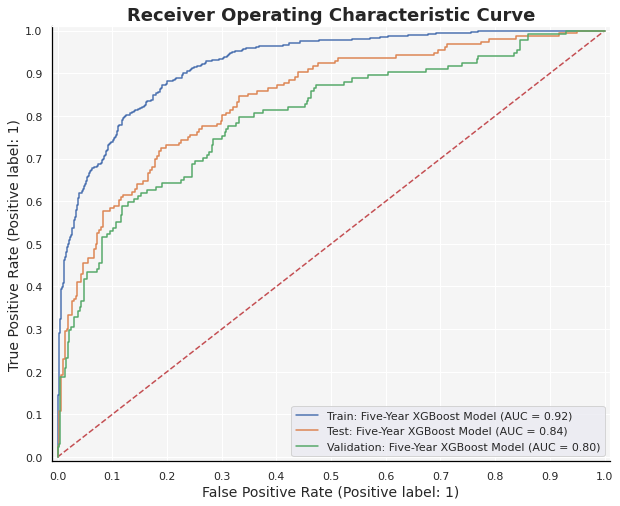

In [ ]:
X5_vbi = [x_train5_vbi, x_test5_vbi, x_val5_vbi]
Y5_vbi = [y_train5_vbi, y_test5_vbi, y_val5_vbi]
NAMES5_vbi = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_vbi_opt, X5_vbi, Y5_vbi, NAMES5_vbi)

No handles with labels found to put in legend.


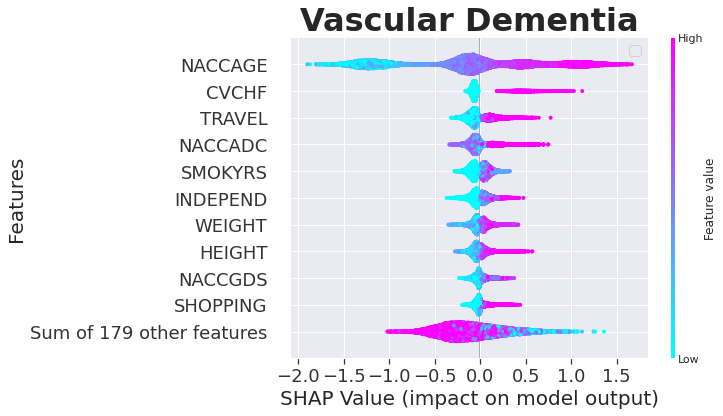

In [ ]:
#bootstrap SHAP plot
shap_exp_vbi = shapPlotBoot(dec5_vbi_opt, feature_five_vbi, target_five_vbi, 50, 10, "beeswarm", title="Vascular Dementia", f_name="shap_vbi.svg", save=True)

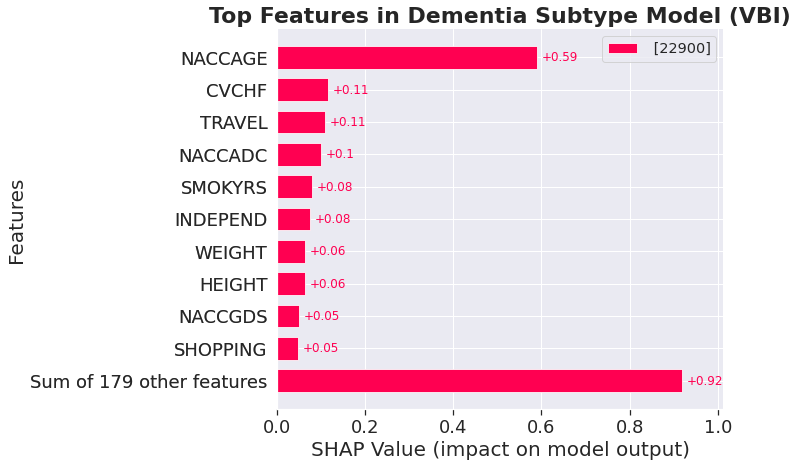

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_vbi = shapPlotBoot(dec5_vbi_opt, feature_five_vbi, target_five_vbi, 50, 10, "bar", title="Top Features in Dementia Subtype Model (VBI)")

In [ ]:
shap_vbi_df = create_shap_df(FEATURES, shap_exp_vbi.values)

In [ ]:
shap_vbi_df

Feature  Mean Absolute SHAP Value  Relative SHAP Value
112   NACCAGE                  0.589969             0.267085
51      CVCHF                  0.114440             0.051808
183    TRAVEL                  0.108569             0.049151
110   NACCADC                  0.099816             0.045188
165   SMOKYRS                  0.079112             0.035815
..        ...                       ...                  ...
147    OTHPSY                  0.000000             0.000000
149      PARK                  0.000000             0.000000
75       HALL                  0.000000             0.000000
151        PD                  0.000000             0.000000
0    ABUSOTHR                  0.000000             0.000000

[189 rows x 3 columns]

## Cognitive impairment for other specified reasons (i.e., written-in values)


In [ ]:
target_five_other = FYS_2019_data_other['FYS']
feature_five_other = FYS_2019_data_other[FYS_2019_data_other.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_other, x_test5_other, y_train5_other, y_test5_other = train_test_split(feature_five_other, target_five_other, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val5_other, y_val5_other = FYS_2021_data_other[FYS_2021_data_other.columns.difference(['FYS'])], FYS_2021_data_other['FYS']

In [ ]:
dec5_other_opt = bo_tune_xgb(x_train5_other, y_train5_other)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8311   |  0.4948   |  2.698    |  0.02296  |  3.814    |  15.43    |  69.14    |  3.862    |  0.543    |
|  2        |  0.8033   |  0.3968   |  7.736    |  0.06258  |  6.699    |  16.66    |  190.3    |  3.862    |  0.7598   |
|  3        |  0.8107   |  0.8601   |  5.764    |  0.08387  |  7.452    |  22.27    |  178.5    |  3.862    |  0.9247   |
|  4        |  0.8085   |  0.2292   |  7.263    |  0.08124  |  7.99     |  6.758    |  241.1    |  3.862    |  0.5056   |
|  5        |  0.796    |  0.9512   |  12.25    |  0.01787  |  4.868    |  7.516    |  190.0    |  3.862    |  0.842    |
|  6        |  0.7972   |  0.3788   |  1.645    |  0.146    |  4.299    |  3.131    |  235.7    |  3.862    |  0.3864   |
|  7        |  0.782    

In [ ]:
dec5_other_opt = XGBClassifier(**{'colsample_bytree': 0.21843622975638458, 
                                  'gamma': 0.7507223340239331, 
                                  'learning_rate': 0.10017229225716098, 
                                  'max_depth': 2, 
                                  'min_child_weight': 15,
                                  'n_estimators': 126, 
                                  'scale_pos_weight': 3.861607142857143, 
                                  'subsample': 0.5221796941624343}
)

In [ ]:
dec5_other_opt.fit(x_train5_other, y_train5_other)

XGBClassifier(colsample_bytree=0.21843622975638458, gamma=0.7507223340239331,
              learning_rate=0.10017229225716098, max_depth=2,
              min_child_weight=15, n_estimators=126,
              scale_pos_weight=3.861607142857143, subsample=0.5221796941624343)

In [ ]:
get_performance_metrics(dec5_other_opt, x_test5_other, y_test5_other)

Accuracy: 0.7802197802197802
Precision: 0.5662650602409639
Recall/Sensitivity/TPR: 0.6619718309859155
Specificity/1-FPR: 0.8217821782178217
ROC-AUC: 0.8322409705759307
PR-AUC: 0.6652565269552319


In [ ]:
get_performance_metrics(dec5_other_opt, x_val5_other, y_val5_other)

Accuracy: 0.7858585858585858
Precision: 0.27692307692307694
Recall/Sensitivity/TPR: 0.75
Specificity/1-FPR: 0.7897091722595079
ROC-AUC: 0.8331002982848619
PR-AUC: 0.42063573489516715


In [ ]:
boot_5_other = bootstrap(dec5_other_opt, feature_five_other, target_five_other, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_other.keys():
  print(f'{stat}: {getCI(boot_5_other[stat], 0.05)}')

accuracy: (0.7436346153846154, 0.827793956043956)
precision: (0.3812622767857143, 0.6264695605953224)
sensitivity: (0.5277269116186692, 0.8747164351851852)
specificity: (0.7422627392170701, 0.8513179394991321)
roc_auc: (0.7954814898335111, 0.8956767048408057)
pr_auc: (0.4686708749583761, 0.7310967271366144)


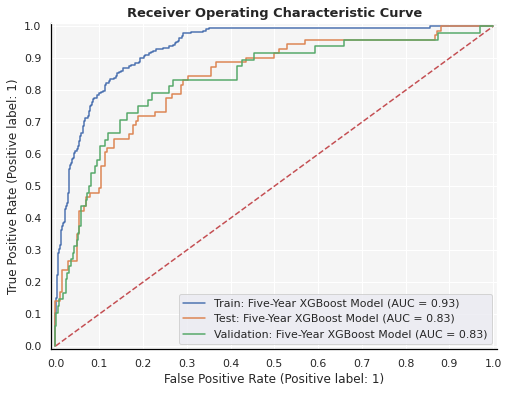

In [ ]:
dec5_other_opt.fit(x_train5_other, y_train5_other)

X5_other = [x_train5_other, x_test5_other, x_val5_other]
Y5_other = [y_train5_other, y_test5_other, y_val5_other]
NAMES5_other = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_other_opt, X5_other, Y5_other, NAMES5_other)

No handles with labels found to put in legend.


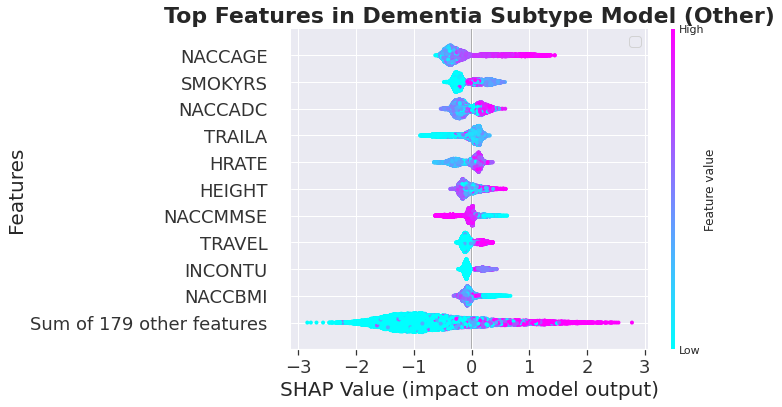

In [ ]:
#bootstrap SHAP plot
shap_exp_other = shapPlotBoot(dec5_other_opt, feature_five_other, target_five_other, 50, 10, "beeswarm", title="Top Features in Dementia Subtype Model (Other)", f_name="shap_other.svg", save=True)

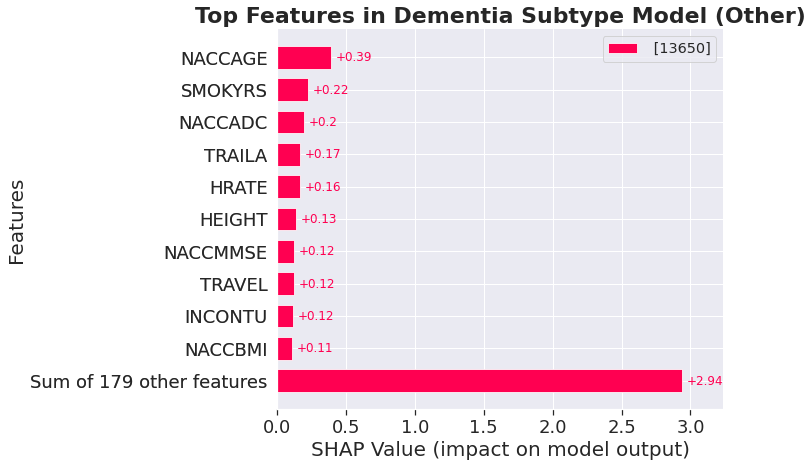

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_other = shapPlotBoot(dec5_other_opt, feature_five_other, target_five_other, 50, 10, "bar", title="Top Features in Dementia Subtype Model (Other)")

In [ ]:
shap_other_df = create_shap_df(FEATURES, shap_exp_other.values)

In [ ]:
shap_other_df

Feature  Mean Absolute SHAP Value  Relative SHAP Value
112   NACCAGE                  0.389262             0.083073
165   SMOKYRS                  0.222713             0.047530
110   NACCADC                  0.195497             0.041722
174    TRAILA                  0.169803             0.036238
83      HRATE                  0.162980             0.034782
..        ...                       ...                  ...
96       MEDS                  0.000000             0.000000
85     HYCEPH                  0.000000             0.000000
84       HUNT                  0.000000             0.000000
76     HANDED                  0.000000             0.000000
0    ABUSOTHR                  0.000000             0.000000

[189 rows x 3 columns]

## Depression


In [ ]:
target_five_dep = FYS_2019_data_dep['FYS']
feature_five_dep = FYS_2019_data_dep[FYS_2019_data_dep.columns.difference(['FYS'])]

#split datasets into training and testing dataset
x_train5_dep, x_test5_dep, y_train5_dep, y_test5_dep = train_test_split(feature_five_dep, target_five_dep, test_size= 0.2, random_state=88)

#use 2021 dataset as a separate validation cohort
x_val5_dep, y_val5_dep = FYS_2021_data_dep[FYS_2021_data_dep.columns.difference(['FYS'])], FYS_2021_data_dep['FYS']

In [ ]:
dec5_dep_opt = bo_tune_xgb(x_train5_dep, y_train5_dep)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8037   |  0.3248   |  6.704    |  0.07505  |  3.414    |  18.1     |  53.68    |  10.4     |  0.958    |
|  2        |  0.7963   |  0.589    |  0.9661   |  0.154    |  7.994    |  21.93    |  236.8    |  10.4     |  0.3577   |
|  3        |  0.8162   |  0.8569   |  13.7     |  0.0329   |  7.098    |  3.41     |  116.0    |  10.4     |  0.5099   |
|  4        |  0.8238   |  0.5772   |  5.819    |  0.07519  |  5.673    |  15.09    |  292.0    |  10.4     |  0.4868   |
|  5        |  0.8095   |  0.2919   |  0.3898   |  0.08241  |  8.657    |  5.096    |  100.4    |  10.4     |  0.6808   |
|  6        |  0.817    |  0.245    |  8.225    |  0.112    |  7.155    |  13.56    |  81.46    |  10.4     |  0.6709   |
|  7        |  0.81     

In [ ]:
dec5_dep_opt = XGBClassifier(**{'colsample_bytree': 0.7350798284589715, 
                                'gamma': 5.690552348260176, 
                                'learning_rate': 0.019269195760837264,
                                'max_depth': 8, 
                                'min_child_weight': 16, 
                                'n_estimators': 146, 
                                'scale_pos_weight': 10.4, 
                                'subsample': 0.5382793625230087})

In [ ]:
dec5_dep_opt.fit(x_train5_dep, y_train5_dep)

XGBClassifier(colsample_bytree=0.7350798284589715, gamma=5.690552348260176,
              learning_rate=0.019269195760837264, max_depth=8,
              min_child_weight=16, n_estimators=146, scale_pos_weight=10.4,
              subsample=0.5382793625230087)

In [ ]:
get_performance_metrics(dec5_dep_opt, x_test5_dep, y_test5_dep)

Accuracy: 0.8154981549815498
Precision: 0.3103448275862069
Recall/Sensitivity/TPR: 0.6428571428571429
Specificity/1-FPR: 0.8353909465020576
ROC-AUC: 0.7996766607877719
PR-AUC: 0.4084639987474871


In [ ]:
get_performance_metrics(dec5_dep_opt, x_val5_dep, y_val5_dep)

Accuracy: 0.8127659574468085
Precision: 0.25
Recall/Sensitivity/TPR: 0.5
Specificity/1-FPR: 0.8450704225352113
ROC-AUC: 0.7848911651728554
PR-AUC: 0.42076088404797735


In [ ]:
boot_5_dep = bootstrap(dec5_dep_opt, feature_five_dep, target_five_dep, 50)

In [ ]:
#to get 95% CIs
for stat in boot_5_dep.keys():
  print(f'{stat}: {getCI(boot_5_dep[stat], 0.05)}')

accuracy: (0.7897130996309962, 0.8892988929889298)
precision: (0.21186378205128206, 0.5516465643274854)
sensitivity: (0.4064561298076923, 0.8877999999999998)
specificity: (0.8059655870445345, 0.9266479178689944)
roc_auc: (0.7324375171600666, 0.8949434146341464)
pr_auc: (0.22835374407575812, 0.6061726778296952)


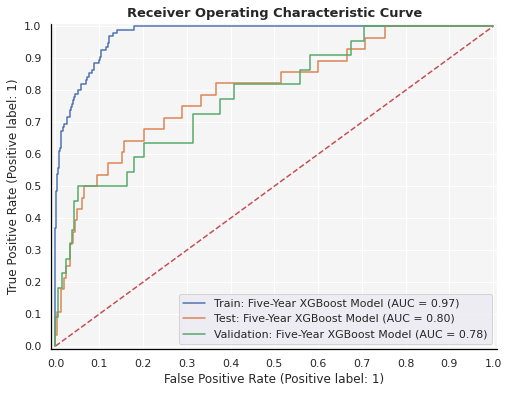

In [ ]:
X5_dep = [x_train5_dep, x_test5_dep, x_val5_dep]
Y5_dep = [y_train5_dep, y_test5_dep, y_val5_dep]
NAMES5_dep = ['Train: Five-Year XGBoost Model', 'Test: Five-Year XGBoost Model', 'Validation: Five-Year XGBoost Model']
draw_roc_curve(dec5_dep_opt, X5_dep, Y5_dep, NAMES5_dep)

No handles with labels found to put in legend.


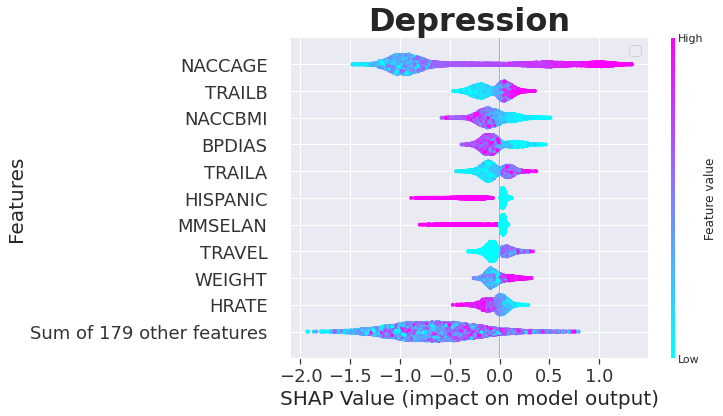

.values =
array([[ 0.        ,  0.01792403, -0.00546185, ...,  0.02874821,
         0.        ,  0.01719095],
       [ 0.        , -0.00351058,  0.01118501, ..., -0.02370251,
         0.        , -0.01387606],
       [ 0.        , -0.00305324, -0.00546185, ..., -0.01556457,
         0.        ,  0.00840655],
       ...,
       [ 0.        , -0.00029981,  0.00146775, ..., -0.01144934,
        -0.00043297, -0.00835729],
       [ 0.        , -0.00130578, -0.02446654, ..., -0.01290325,
         0.00226219, -0.02094794],
       [ 0.        , -0.00122164,  0.00294218, ..., -0.01052833,
        -0.00302091, -0.01962619]], dtype=float32)

.base_values =
array([0.39328173, 0.39328173, 0.39328173, ..., 0.37734288, 0.37734288,
       0.37734288], dtype=float32)

.data =
array([[0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 2., 1., 0.],
       [0., 0., 0., ..., 2., 0., 1.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 1., ..., 2., 1., 0.],
       [0., 0., 0., ..., 2.,

In [ ]:
#bootstrap SHAP plot
shapPlotBoot(dec5_dep_opt, feature_five_dep, target_five_dep, 50, 10, "beeswarm", title="Depression", f_name="shap_dep.svg", save=True)

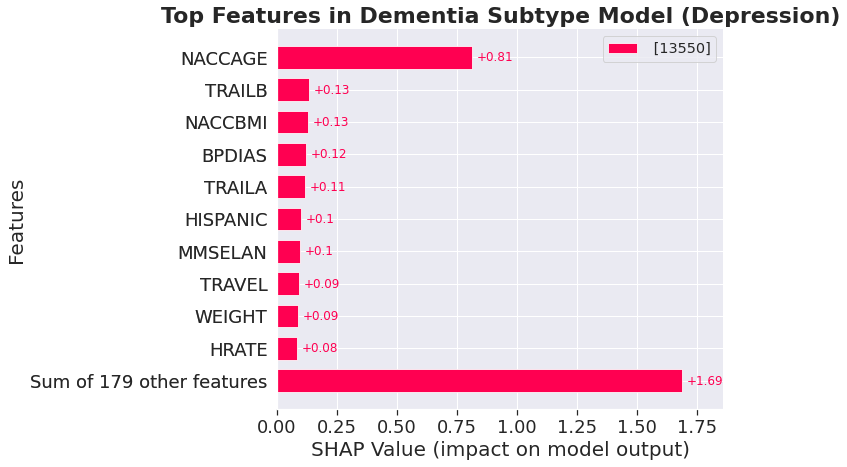

In [ ]:
#use bar plot instead of beeswarm plot to generate SHAP values for table (strange glitch with beeswarm plot)
shap_exp_dep = shapPlotBoot(dec5_dep_opt, feature_five_dep, target_five_dep, 50, 10, "bar", title="Top Features in Dementia Subtype Model (Depression)")

In [ ]:
shap_dep_df = create_shap_df(FEATURES, shap_exp_dep.values)

In [ ]:
shap_dep_df

Feature  Mean Absolute SHAP Value  Relative SHAP Value
112   NACCAGE                  0.811727             0.234553
177    TRAILB                  0.132834             0.038383
116   NACCBMI                  0.130566             0.037728
25     BPDIAS                  0.121960             0.035241
174    TRAILA                  0.114743             0.033156
..        ...                       ...                  ...
119  NACCETPR                  0.000000             0.000000
117    NACCC1                  0.000000             0.000000
15    BEDISIN                  0.000000             0.000000
114  NACCAPSA                  0.000000             0.000000
0    ABUSOTHR                  0.000000             0.000000

[189 rows x 3 columns]

## Pan-Dementia Feature Heatmap

In [ ]:
FEATURES = x_train5.columns

def create_shap_df(features, shap_values):
  #taken from https://github.com/slundberg/shap/issues/632
  vals= np.abs(shap_values).mean(0)
  feature_importance = pd.DataFrame(list(zip(features, vals)), columns=['Feature','Mean Absolute SHAP Value'])
  feature_importance["Mean Absolute SHAP Value"] = np.abs(feature_importance["Mean Absolute SHAP Value"])
  feature_importance["Relative SHAP Value"] = feature_importance["Mean Absolute SHAP Value"]/sum(feature_importance["Mean Absolute SHAP Value"])
  feature_importance.sort_values(by=['Mean Absolute SHAP Value'], ascending=False,inplace=True)

  return feature_importance

In [ ]:
#selected features with a relative SHAP value > 0.025 in any of the dementia subtype models
NEW_FEATURES = ['ANIMALS','BPDIAS','CDRLANG','CDRSUM','COMMUN','CVCHF','ENERGY','HEIGHT','HISPANIC','HRATE','HYPERCHO','HYPERTEN',
                'INDEPEND','MMSELAN','MOMODE','MOSLOW','NACCADC','NACCAGE','NACCBMI','NACCGDS','NACCMMSE','NACCMOTF','NACCNIHR',
                'ORIENT','PERSCARE','RESIDENC','SEX','SHOPPING','SMOKYRS','TOBAC100','TRAILA','TRAILB','TRAVEL','VEG','WEIGHT']
  
DEMENTIA_SUBTYPES = ['No Dementia', 'Alzheimer\'s Disease', 'Unknown', 'Frontotemporal Lobar Dementia', 'Lewy Body Dementia',
                     'Vascular Brain Injury', 'Other', 'Depression']

def get_relative_shap_values(shap_df):
  shap_df = shap_df.sort_index()
  return shap_df[shap_df['Feature'].isin(NEW_FEATURES)]['Relative SHAP Value']

def aggregate_relative_shap_values(shap_df1, shap_df2, *argv):
  all_relative_shap_values = [get_relative_shap_values(shap_df1), get_relative_shap_values(shap_df2)]

  for arg in argv:
    all_relative_shap_values.append(get_relative_shap_values(arg))

  return np.array(all_relative_shap_values)

In [ ]:
relative_shap_array = aggregate_relative_shap_values(shap_no_dementia_df, shap_ad_df, shap_unknown_df, shap_ftld_df, shap_lbd_df, shap_vbi_df, shap_other_df, shap_dep_df)

In [ ]:
subtype_shap_df = pd.DataFrame(relative_shap_array, columns=NEW_FEATURES)
subtype_shap_df['Dementia Subtype'] = DEMENTIA_SUBTYPES
subtype_shap_df.set_index('Dementia Subtype', inplace=True)
subtype_shap_df.to_csv(r'NACC_Prediction/out/subtype_shap_df.csv', index=False)
subtype_shap_df

In [ ]:
subtype_shap_df = pd.read_csv('NACC_Prediction/out/subtype_shap_df.csv')
subtype_shap_df['Dementia Subtype'] = DEMENTIA_SUBTYPES
subtype_shap_df.set_index('Dementia Subtype', inplace=True)
subtype_shap_df.rename(index={"Vascular Brain Injury": "Vascular Dementia"}, inplace=True)
subtype_shap_df *= 100 #multiply all relative SHAP values by 100 to get percentages
subtype_shap_df

ANIMALS    BPDIAS   CDRLANG    CDRSUM  \
Dementia Subtype                                                        
No Dementia                    0.922579  0.839838  0.004327  0.137061   
Alzheimer's Disease            0.808157  0.499593  0.605256  4.309498   
Unknown                        0.455518  0.773527  0.297522  1.006866   
Frontotemporal Lobar Dementia  2.047039  1.084250  4.866089  3.605645   
Lewy Body Dementia             3.377068  0.477795  0.436738  9.929602   
Vascular Dementia              0.283437  0.975711  0.322653  0.590760   
Other                          0.810001  1.524901  0.495029  0.800475   
Depression                     1.281471  3.524083  0.115720  0.775954   

                                 COMMUN     CVCHF    ENERGY    HEIGHT  \
Dementia Subtype                                                        
No Dementia                    0.020820  0.876427  2.575441  1.438470   
Alzheimer's Disease            0.661470  0.829430  0.112536  1.718457   
Unknown                        0.217464  1.691977  0.070006  0.866878   
Frontotemporal Lobar Dementia  4.870499  0.000000  0.212148  1.290271   
Lewy Body Dementia             2.504872  0.000000  0.080682  1.338342   
Vascular Dementia              0.306864  5.180825  0.123318  2.852794   
Other                          0.386686  0.000000  0.630002  2.873530   
Depression                     0.208151  1.508408  0.310672  1.420313   

                               HISPANIC     HRATE  ...  RESIDENC       SEX  \
Dementia Subtype                                   ...                       
No Dementia                    0.966654  1.682441  ...  3.112436  2.576190   
Alzheimer's Disease            1.317003  0.506924  ...  2.049245  5.538957   
Unknown                        0.175111  1.948199  ...  1.231943  3.966464   
Frontotemporal Lobar Dementia  0.025509  0.886629  ...  0.791922  0.890092   
Lewy Body Dementia             0.000000  0.324821  ...  0.586144  0.571317   
Vascular Dementia              0.000000  1.900974  ...  1.568519  0.514143   
Other                          0.021406  3.478206  ...  1.320916  0.267771   
Depression                     2.913493  2.447962  ...  0.851636  0.572983   

                               SHOPPING   SMOKYRS  TOBAC100    TRAILA  \
Dementia Subtype                                                        
No Dementia                    0.600369  7.551245  1.655547  3.629762   
Alzheimer's Disease            2.759779  6.535550  2.849424  2.007822   
Unknown                        1.468768  2.897861  0.053789  3.293379   
Frontotemporal Lobar Dementia  3.159210  2.226039  0.224681  1.027979   
Lewy Body Dementia             2.188212  2.169174  0.119452  1.798771   
Vascular Dementia              2.117273  3.581469  0.081183  1.188516   
Other                          2.159134  4.752993  0.927892  3.623815   
Depression                     0.138842  1.170287  0.279642  3.315570   

                                 TRAILB    TRAVEL       VEG    WEIGHT  
Dementia Subtype                                                       
No Dementia                    5.762143  0.625510  2.659151  1.539044  
Alzheimer's Disease            2.377017  2.293779  1.627949  0.880390  
Unknown                        4.668343  0.214212  4.728007  2.742572  
Frontotemporal Lobar Dementia  2.737917  3.110855  0.619234  1.419579  
Lewy Body Dementia             0.997737  1.098523  1.350926  0.655000  
Vascular Dementia              0.819735  4.915054  1.813430  2.906013  
Other                          1.247818  2.631452  0.545282  1.103992  
Depression                     3.838314  2.691261  1.121010  2.468210  

[8 rows x 35 columns]

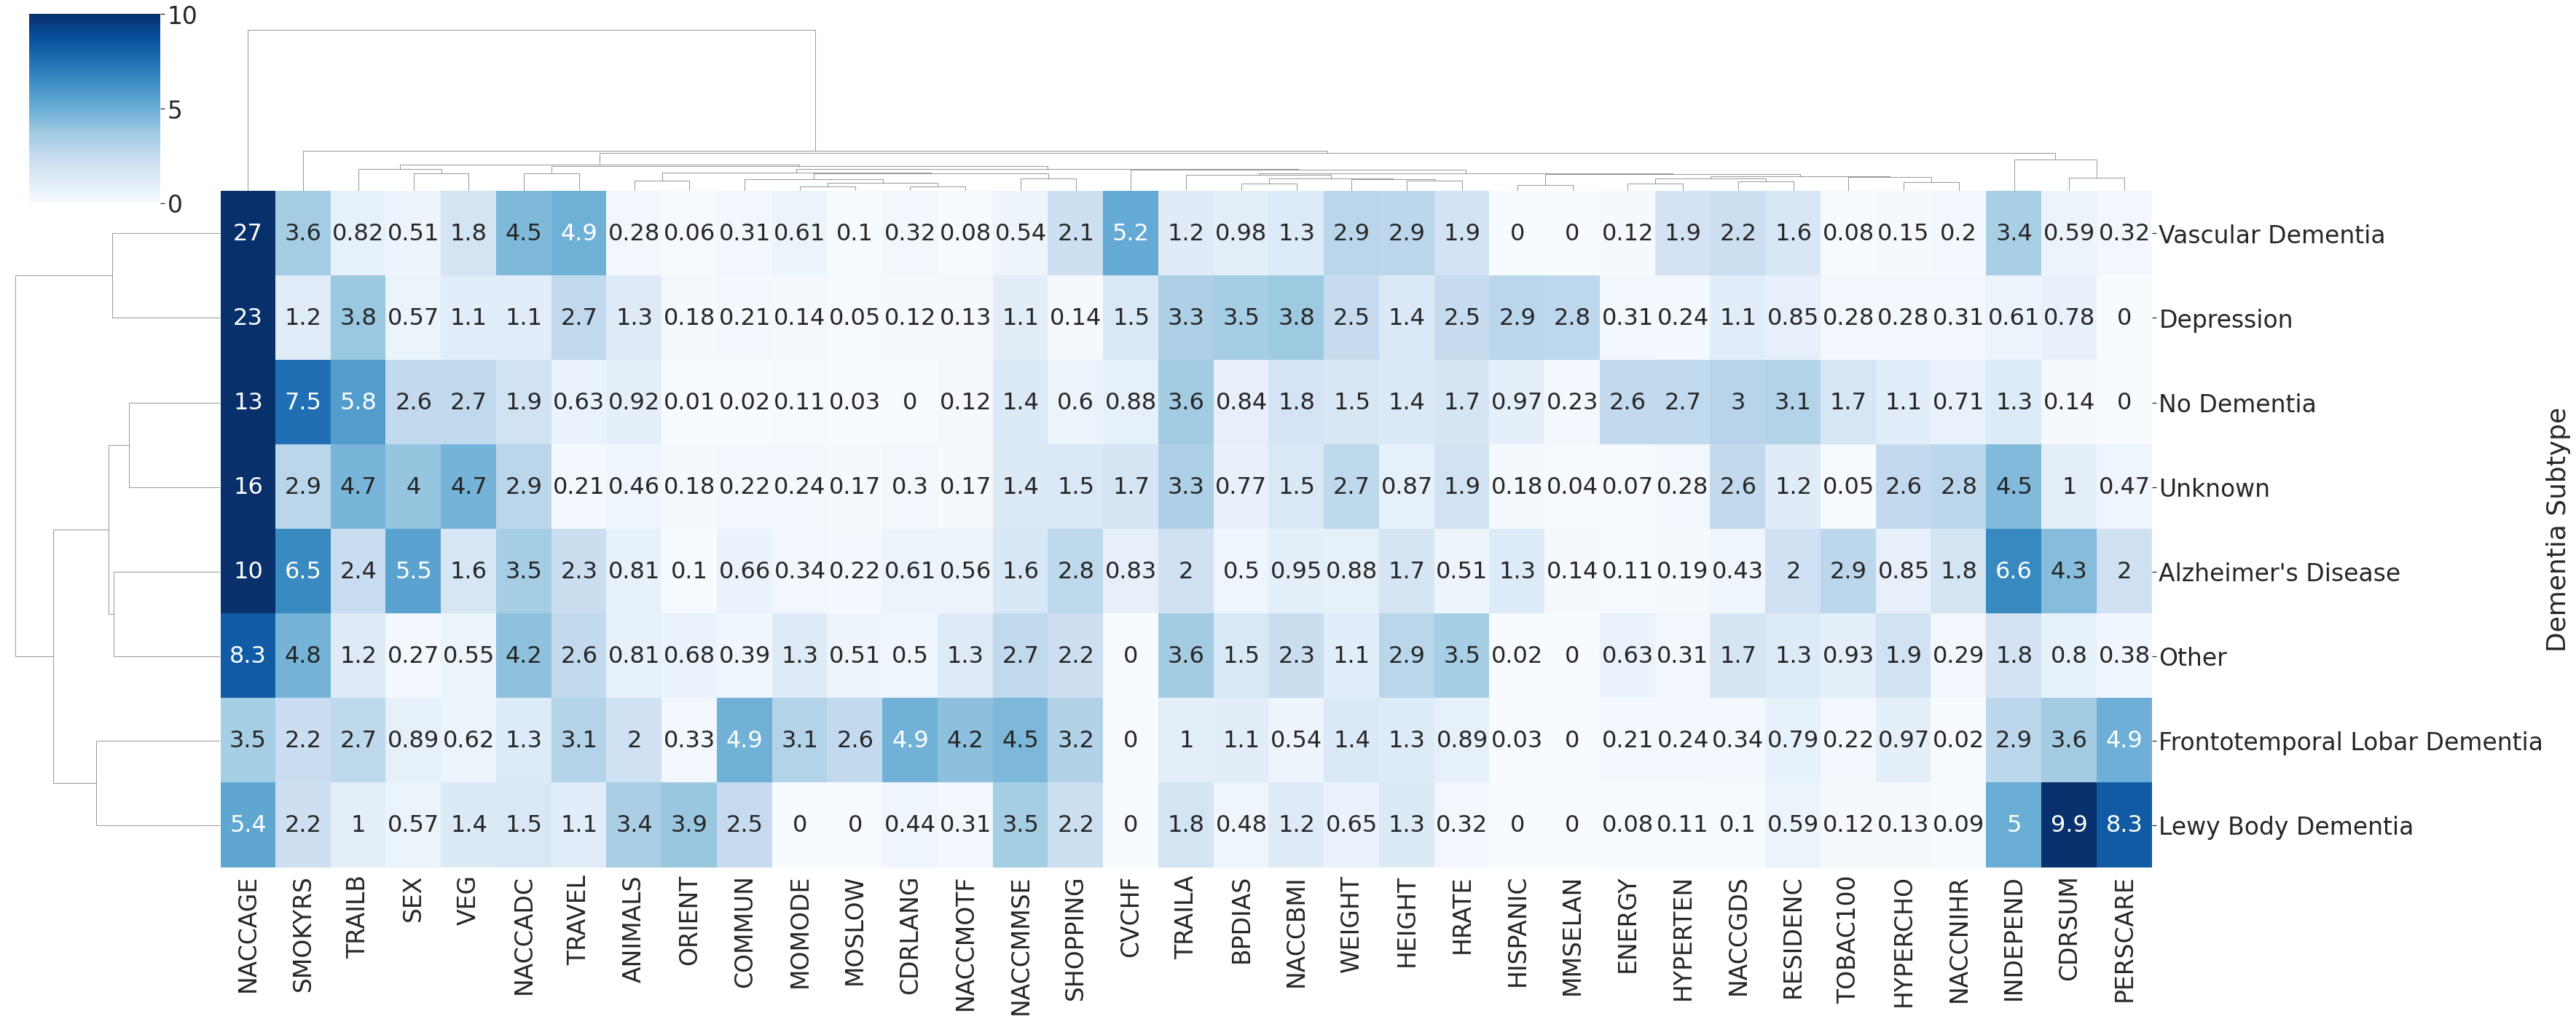

In [ ]:
#round values to 3 decimal places in df
subtype_shap_df = subtype_shap_df.round(2)

#clustermap
sns.set(font_scale=3)
shap_clust = sns.clustermap(subtype_shap_df, 
               figsize=(50,20), 
               annot=True, 
               cmap='Blues', 
               annot_kws={"size": 32}, 
               vmin=0,
               dendrogram_ratio=(.1, .2), 
               vmax=10
               )
plt.savefig('NACC_Prediction/out/clustermap.svg', dpi=300)

# Testing Deep Learning (ANN)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation

## Additional Preprocessing

### Skew Transformations

### Normalization/Feature Scaling

In [ ]:
feature_subset = ['NACCAGE', 'INDEPEND', 'PERSCARE', 'TRAILB', 'SEX', 'SMOKYRS', 'TRAILBRR', 'EDUC']

#normalize features
sc = StandardScaler()
x_train5_ann = sc.fit_transform(x_train5[feature_subset])
x_test5_ann = sc.fit_transform(x_test5[feature_subset])
x_val5_ann = sc.fit_transform(x_val5[feature_subset])

#convert target variable into np array
y_train5_ann = np.asarray(y_train5).reshape((-1,1))
y_test5_ann = np.asarray(y_test5).reshape((-1,1))
y_val5_ann = np.asarray(y_val5).reshape((-1,1))

## Build and Test Model


In [ ]:
#build neural network architecture
dec_deep_ann = tf.keras.Sequential()
dec_deep_ann.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = 8))
dec_deep_ann.add(Dropout(0.1))
dec_deep_ann.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
dec_deep_ann.add(Dense(1, kernel_initializer='uniform', activation=tf.nn.sigmoid))

In [ ]:
#compile and fit the model
dec_deep_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
dec_deep_ann.fit(x_train5_ann, y_train5_ann, batch_size=25, epochs=50, validation_split=0.2)

Epoch 1/50
1511/1511 [==============================] - 7s 3ms/step - loss: 0.5135 - accuracy: 0.7527 - auc: 0.7947 - val_loss: 0.5108 - val_accuracy: 0.7497 - val_auc: 0.8002
Epoch 2/50
1511/1511 [==============================] - 5s 3ms/step - loss: 0.5039 - accuracy: 0.7574 - auc: 0.8038 - val_loss: 0.5076 - val_accuracy: 0.7535 - val_auc: 0.8040
Epoch 3/50
1511/1511 [==============================] - 5s 3ms/step - loss: 0.5017 - accuracy: 0.7566 - auc: 0.8058 - val_loss: 0.5067 - val_accuracy: 0.7529 - val_auc: 0.8054
Epoch 4/50
1511/1511 [==============================] - 5s 3ms/step - loss: 0.5015 - accuracy: 0.7593 - auc: 0.8064 - val_loss: 0.5047 - val_accuracy: 0.7540 - val_auc: 0.8074
Epoch 5/50
1511/1511 [==============================] - 5s 3ms/step - loss: 0.5002 - accuracy: 0.7582 - auc: 0.8074 - val_loss: 0.5059 - val_accuracy: 0.7535 - val_auc: 0.8063
Epoch 6/50
1511/1511 [==============================] - 4s 3ms/step - loss: 0.4998 - accuracy: 0.7577 - auc: 0.8077 - va

In [ ]:
dec_deep_ann.evaluate(x_train5_ann, y_train5_ann)

1475/1475 [==============================] - 3s 2ms/step - loss: 0.4824 - accuracy: 0.7682 - auc: 0.8242


[0.4824279546737671, 0.7681583166122437, 0.8241513967514038]

In [ ]:
dec_deep_ann.evaluate(x_test5_ann, y_test5_ann)

369/369 [==============================] - 1s 2ms/step - loss: 0.4948 - accuracy: 0.7581 - auc: 0.8127


[0.4948466420173645, 0.7581356167793274, 0.8127211332321167]

In [ ]:
dec_deep_ann.evaluate(x_val5_ann, y_val5_ann)

353/353 [==============================] - 1s 2ms/step - loss: 0.5018 - accuracy: 0.7612 - auc: 0.8079


[0.5018332600593567, 0.7611662745475769, 0.807948648929596]